In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import time

In [29]:
file_path = "Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.001.csv"
data = pd.read_csv(file_path)
filtered_data = data[data['PEEQ'] <= 3]
PEEQ = filtered_data["PEEQ"].to_numpy()
PEEQ_fit = np.linspace(np.min(PEEQ), np.max(PEEQ), 200)

Parameter: C1, R^2: 0.7031, Coefficients: [-2.22181865e+06 -1.23963294e+00  2.21074509e+03  1.12938741e-39
  1.00543915e+03  1.00002989e+00]
Parameter: C2, R^2: 0.8012, Coefficients: [ 0.05479138  0.67821633  0.25008246  0.01078543 -0.04780041  0.3628666 ]
Parameter: C3, R^2: 0.9351, Coefficients: [ -0.40025513   3.4953917  -11.48472162  16.3328281  -15.61830665
   0.86618693]
Parameter: C4, R^2: 0.9279, Coefficients: [-4.51757455e-03 -6.15676559e-01 -5.30721137e+00 -1.48591965e-02
  3.94405259e-01  1.22275415e-01]
Parameter: C5, R^2: 0.8707, Coefficients: [7.26615123e+02 1.22371030e+05 4.54909746e+02 2.24369152e+02
 3.51138891e+01 7.37048214e+00]
Parameter: C6, R^2: 0.8057, Coefficients: [  96.42598704 1535.90009551  184.50508606   18.18920627 -112.04311374
  301.30181704]


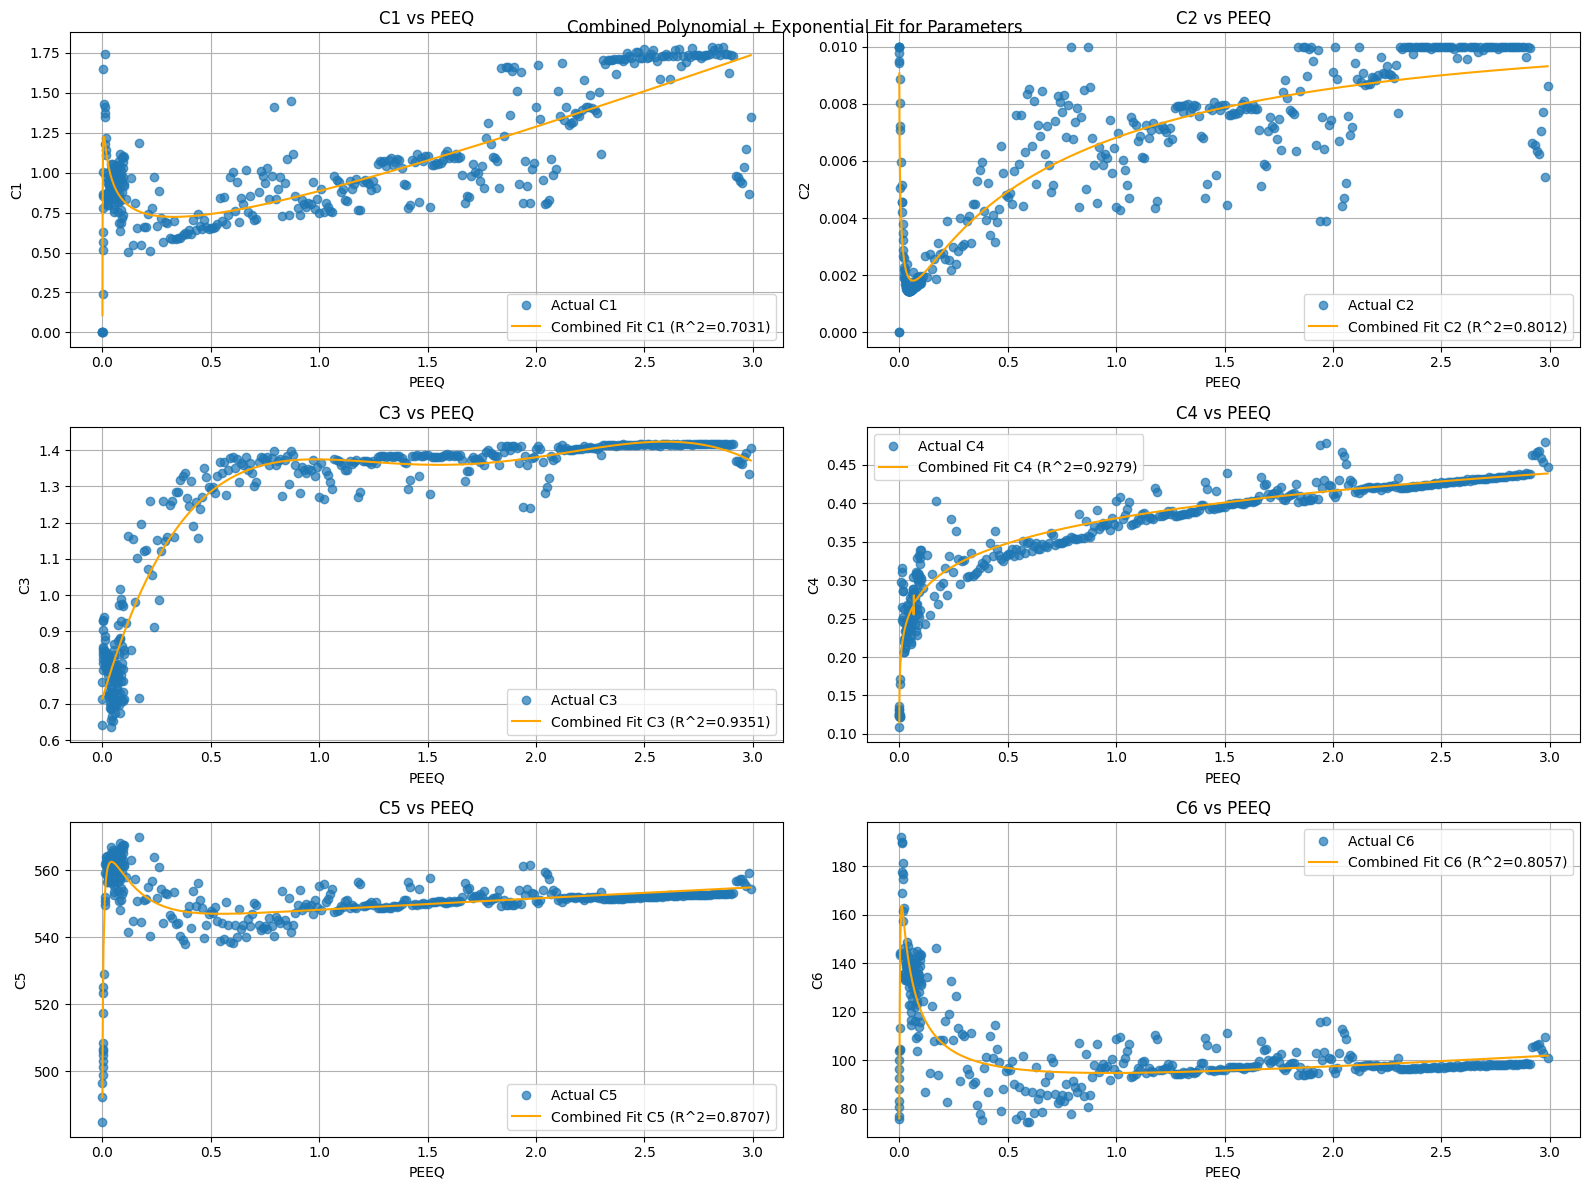

In [30]:
df_para_fit = pd.DataFrame(PEEQ, columns=["PEEQ"])

# Define the combined polynomial + exponential function
def combined_fit(x, a, b, c, d, e, f, C):
    if C == 'C4' or C == 'C2' or C == 'C1':
        return (a*x)/(x**b + c) + d + e * (x**f)
    elif C == 'C5' or C == 'C6': 
        #return a * (x**2) + b * x + c + d * np.exp(e * x)
        return (a * (x**2) + b * x + c)/(d*x + 1) + e * np.exp(-f * x)
    else :
        return a * (x**3) + b * (x**2) + c * x + d + e * np.exp(-f * x)

# Function to fit the combined model and calculate R^2 score
def fit_combined_model(data, parameter):
    x = data['PEEQ']
    y = data[parameter]
    
    # Apply initial guesses and bounds only for 'C5' and 'C6'
    if parameter in ['C1', 'C5']:
        initial_guess = [100, -50, 580, 1, 50, 1]
        bounds = ([-np.inf, -np.inf, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        fit_kwargs = {'p0': initial_guess, 'bounds': bounds}
    else:
        fit_kwargs = {}  # No initial guess or bounds for other parameters

    # Fit the combined model
    try:
        popt, _ = curve_fit(lambda x, a, b, c, d, e, f: combined_fit(x, a, b, c, d, e, f, parameter), x, y, maxfev=200000, **fit_kwargs)
        y_pred = combined_fit(x, *popt, parameter)
        r2 = r2_score(y, y_pred)
    except RuntimeError:
        popt = None
        y_pred = None
        r2 = -np.inf  # Indicate failed fit
    
    if popt is not None:
        print(f'Parameter: {parameter}, R^2: {r2:.4f}, Coefficients: {popt}')
    else:
        print(f'Parameter: {parameter} - Fit failed')
    
    return popt, y_pred, r2

# List of parameters to fit
parameters = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Fit models and plot results
plt.figure(figsize=(16, 12))

for i, param in enumerate(parameters):
    popt, y_pred, r2 = fit_combined_model(data, param)
    x = data['PEEQ']
    y_actual = data[param]
    df_para_fit[param] = y_pred
    
    plt.subplot(3, 2, i + 1)
    plt.plot(x, y_actual, 'o', label=f'Actual {param}', alpha=0.7)
    
    # Plot fitted combined model if successful
    if y_pred is not None:
        plt.plot(x, y_pred, '-', color='orange', label=f'Combined Fit {param} (R^2={r2:.4f})')
    
    plt.xlabel('PEEQ')
    plt.ylabel(param)
    plt.title(f'{param} vs PEEQ')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Combined Polynomial + Exponential Fit for Parameters')
plt.show()

In [31]:
df_para_fit.to_csv('para_fit_results_0.001.csv', index=False)
# Assuming the file is one level up from the current directory
file_path = "Fitted_FC_TmpDpn_RD_StrRt0.001_ref.csv"
stress_data = pd.read_csv(file_path)

fitted_para = pd.read_csv('para_fit_results_0.001.csv')

Validation (better fit from 30th row forward)

[0.4815976  0.44172149 0.48869714 0.47787062 0.57064533]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


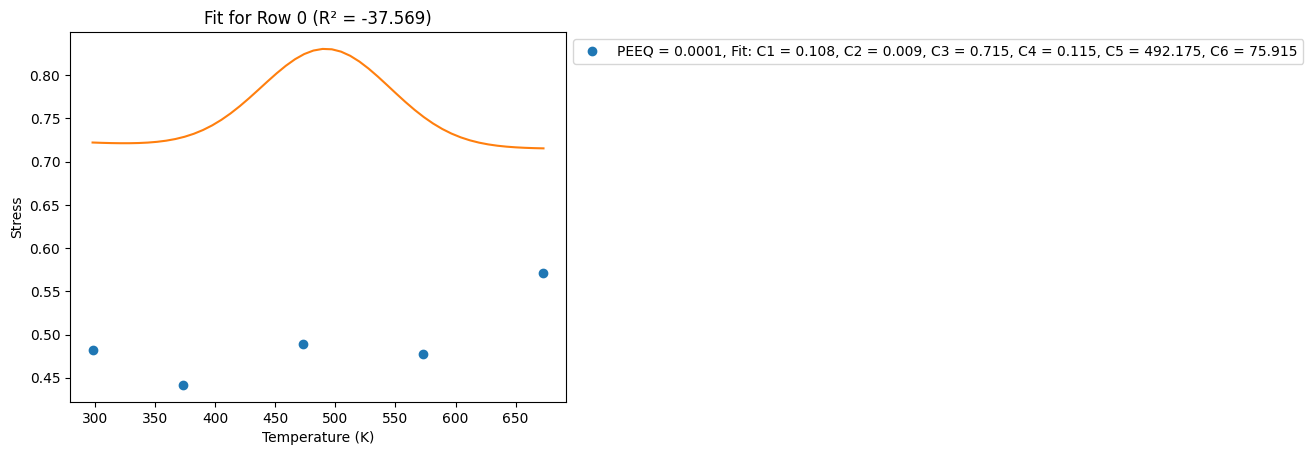

[0.67986511 0.72430089 0.83655173 0.75488067 0.74631593]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


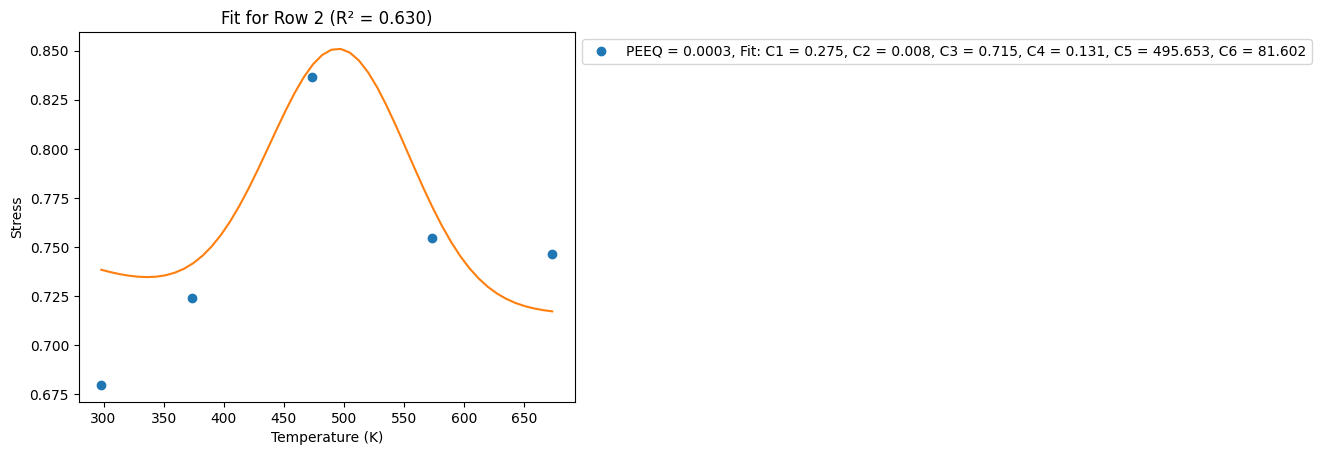

[0.79110903 0.80653391 0.9120024  0.8518493  0.79749993]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


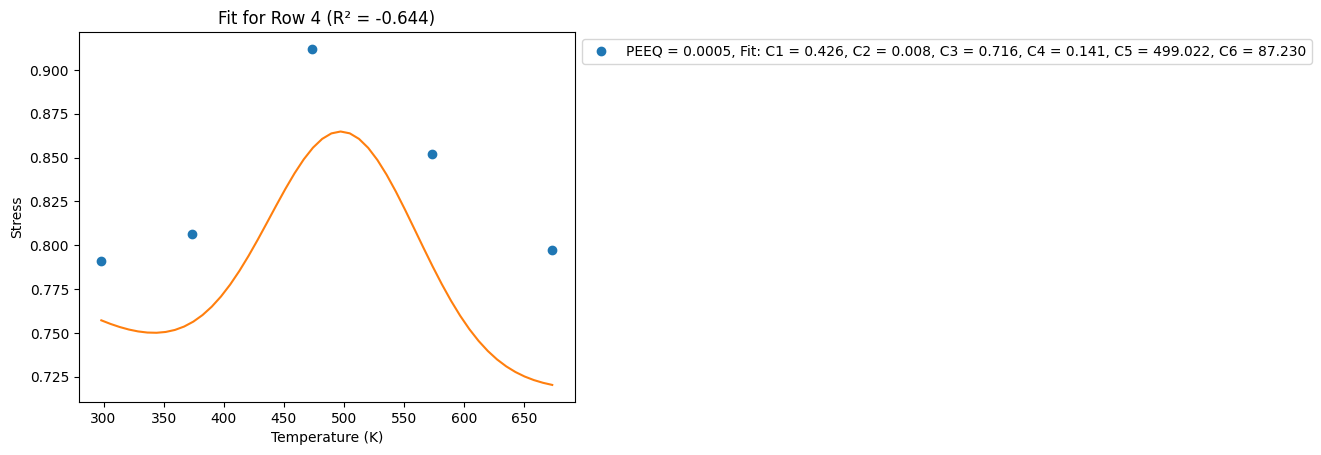

[0.85118774 0.8541365  0.94238591 0.89706747 0.82909505]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


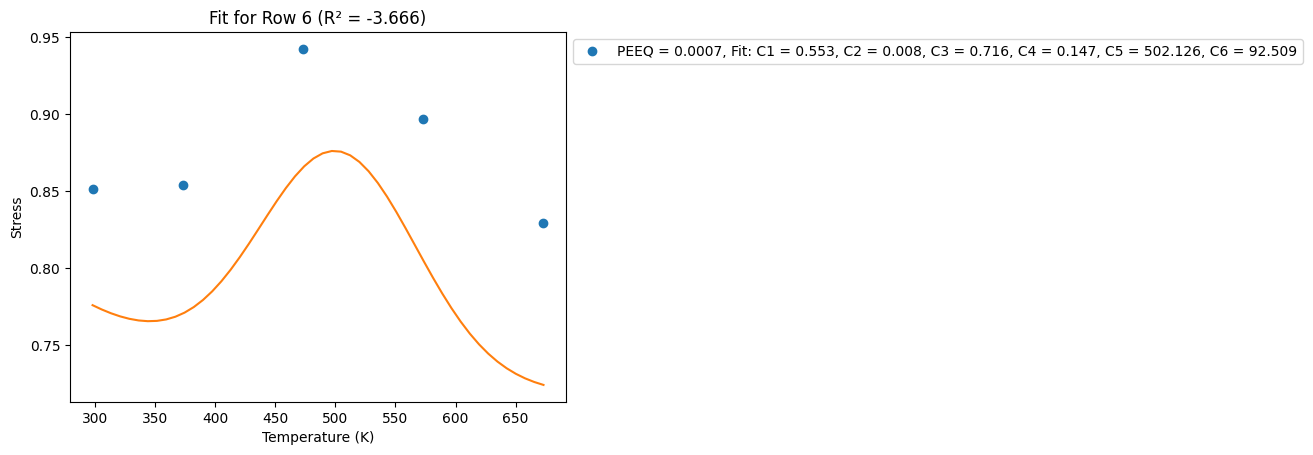

[0.89165639 0.88731807 0.96311072 0.92533986 0.85221753]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


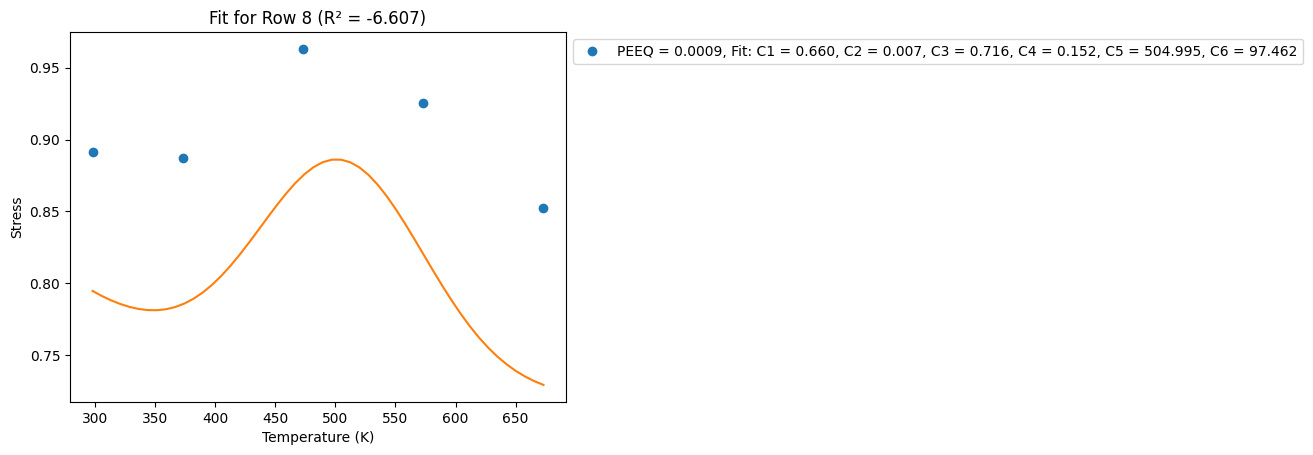

[0.92189443 0.91266789 0.9802331  0.94670556 0.87056589]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


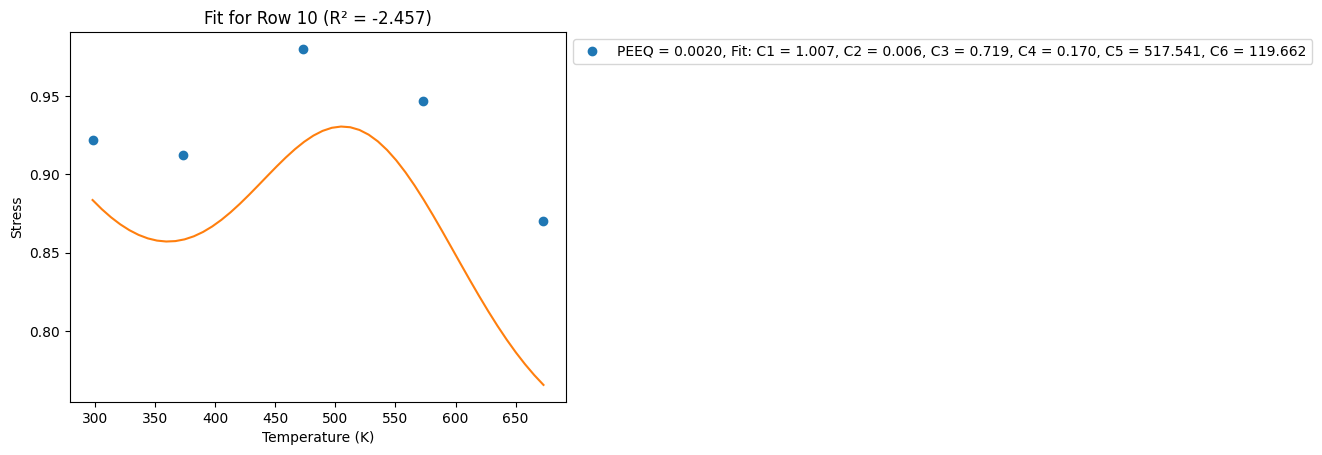

[1.0589375  1.03342602 1.08079608 1.06041682 0.96635457]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


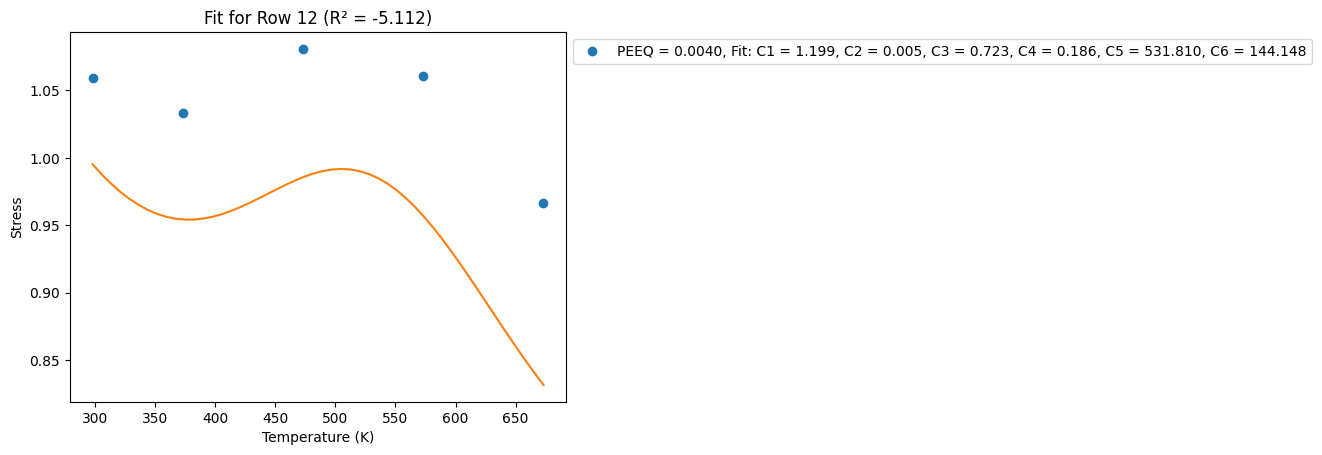

[1.11815168 1.08865993 1.13309312 1.11771852 1.01322897]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


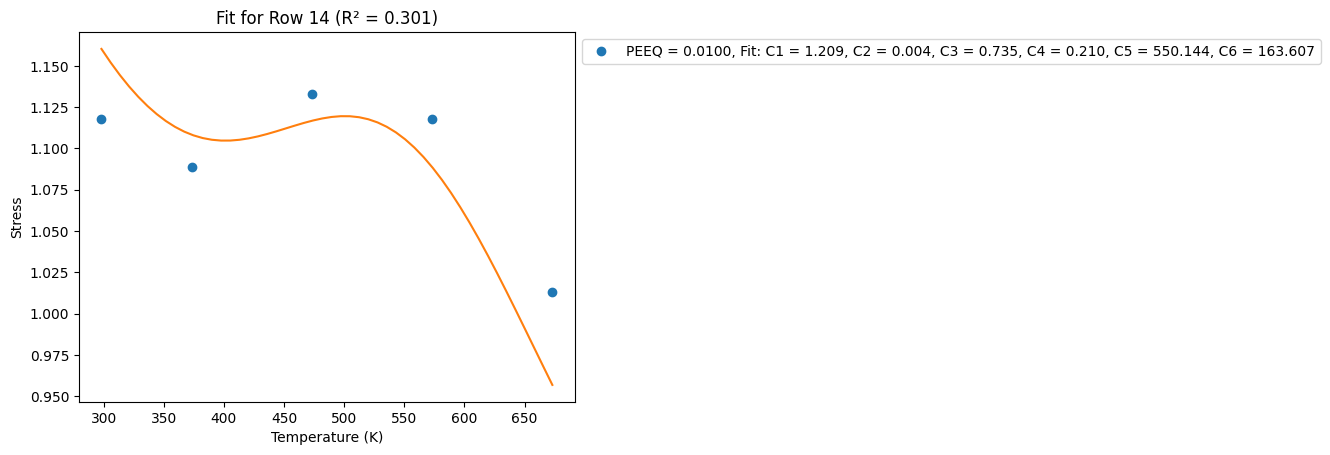

[1.20634361 1.17403137 1.21470766 1.20858911 1.08383554]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


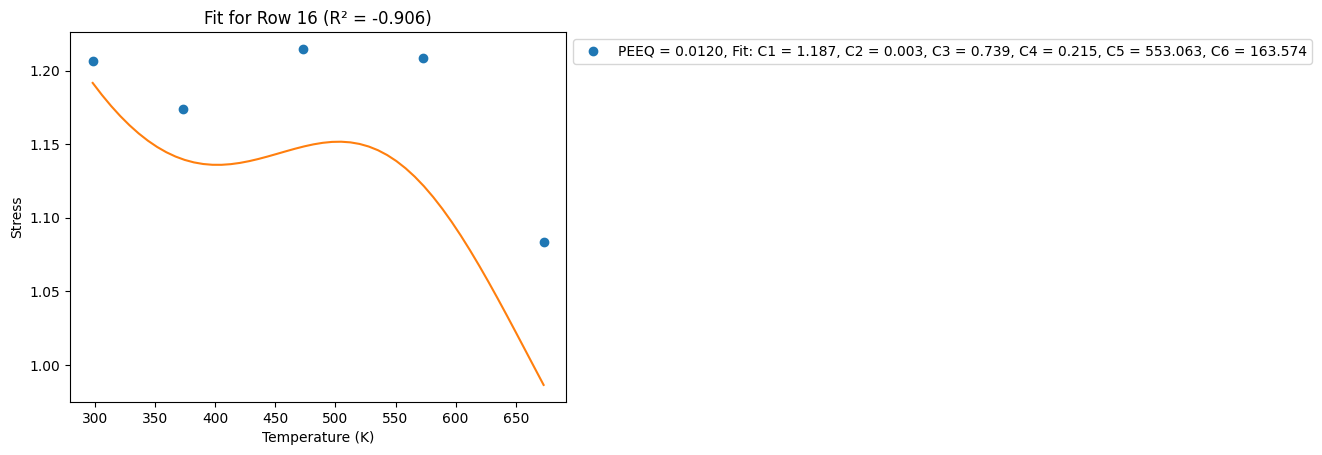

[1.22433313 1.19176778 1.2317461  1.22802572 1.09796444]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


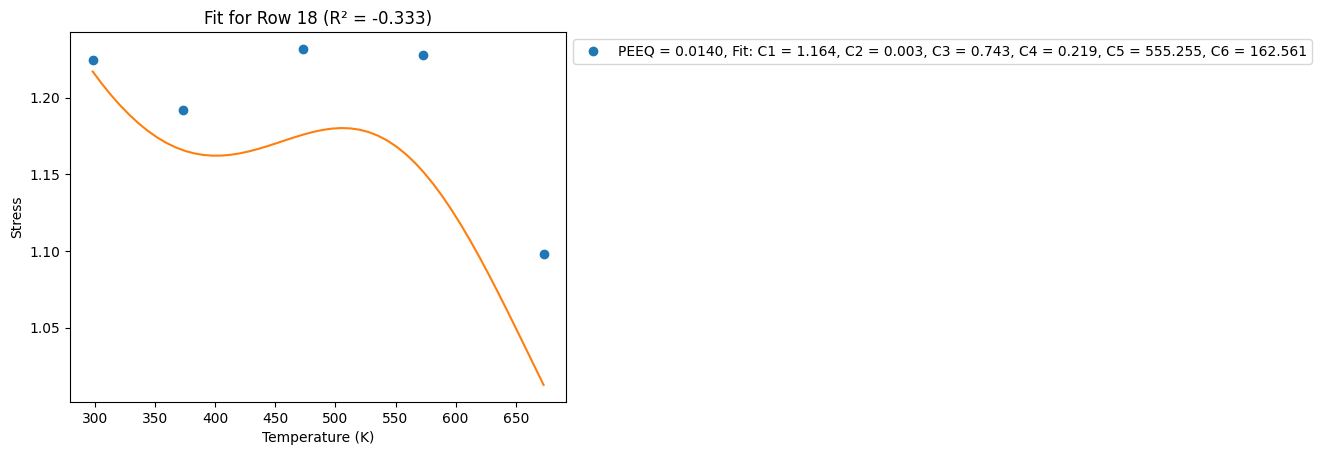

[1.23940505 1.20666763 1.2462144  1.24469802 1.10979872]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


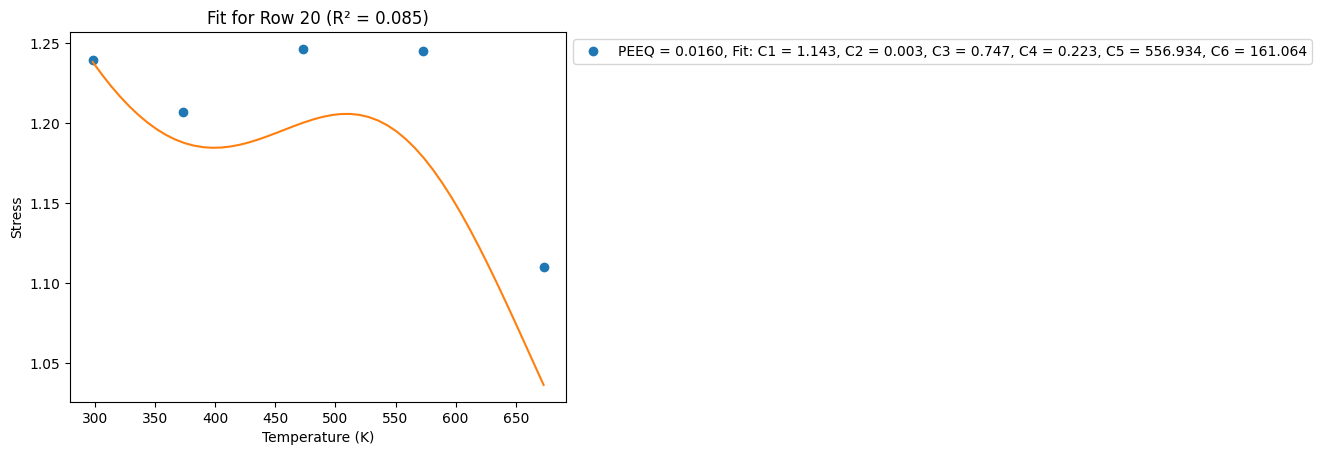

[1.25226408 1.21939282 1.25876089 1.25929121 1.11996547]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


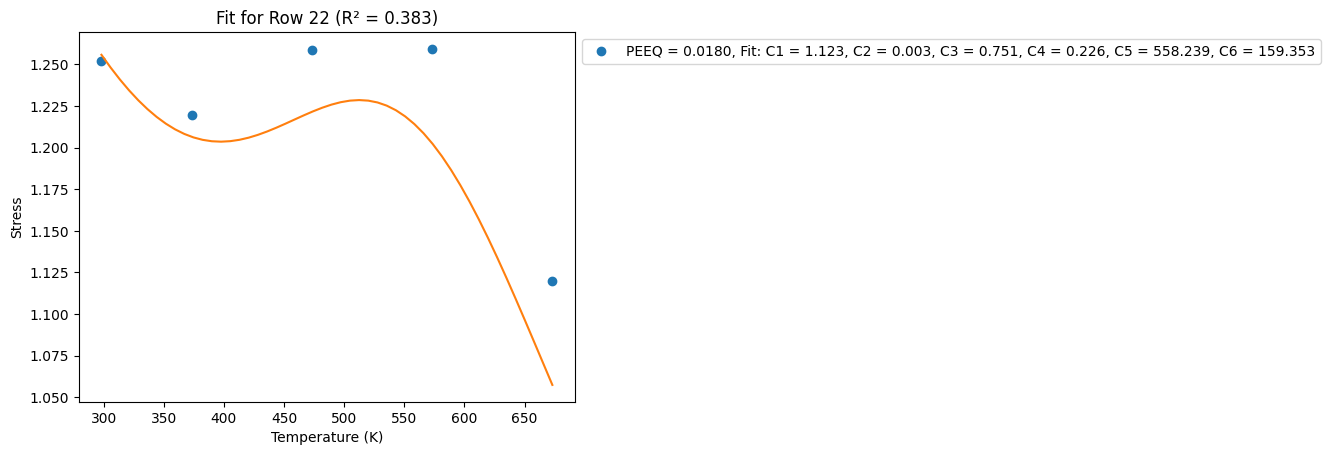

[1.26338697 1.23039864 1.26981855 1.272264   1.12887675]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


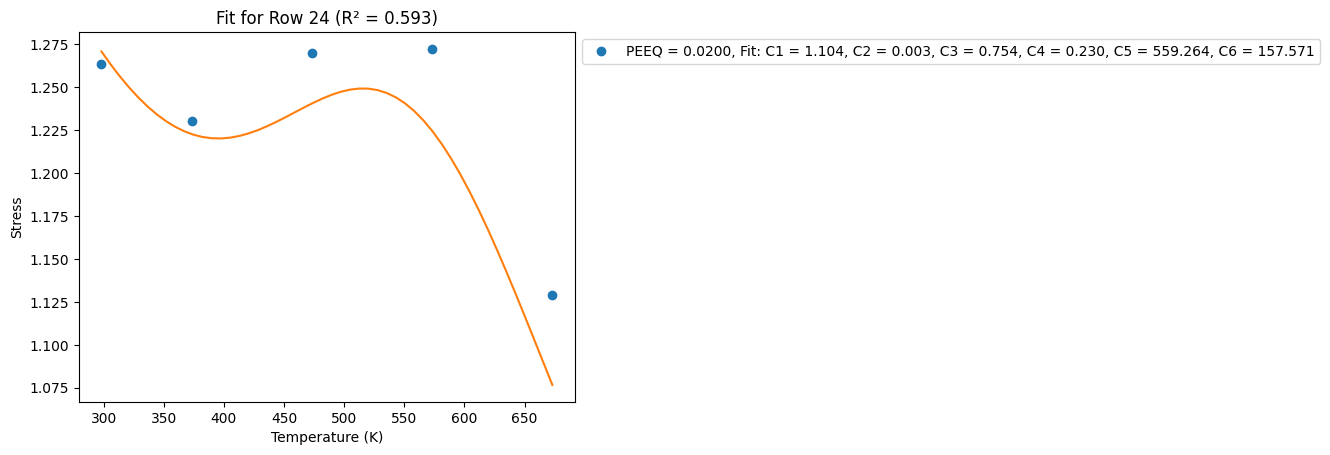

[1.27311384 1.24001459 1.27969042 1.28393851 1.13681386]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


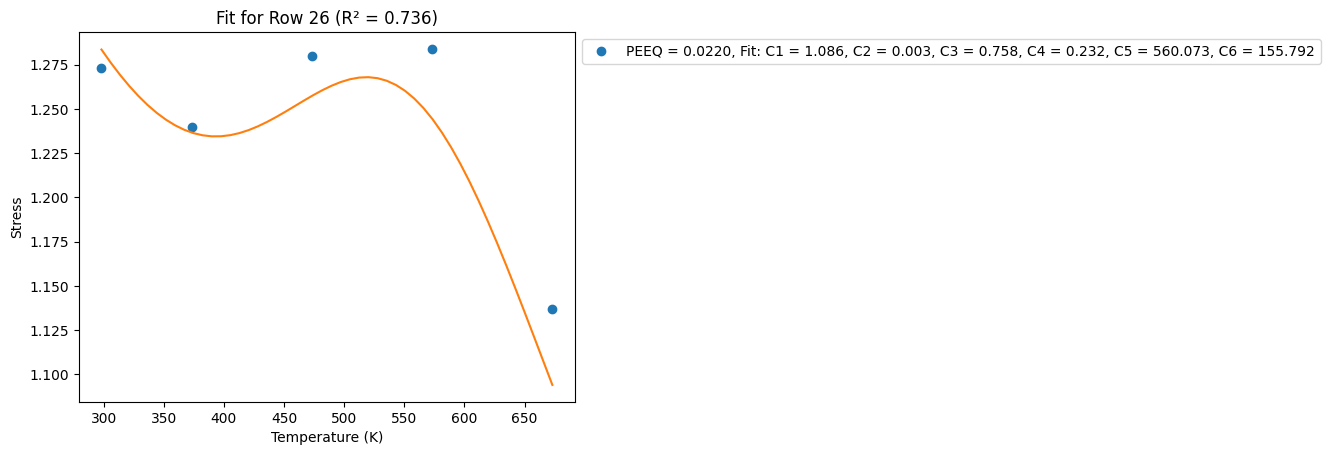

[1.28169716 1.24848823 1.28859665 1.29454961 1.14397509]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


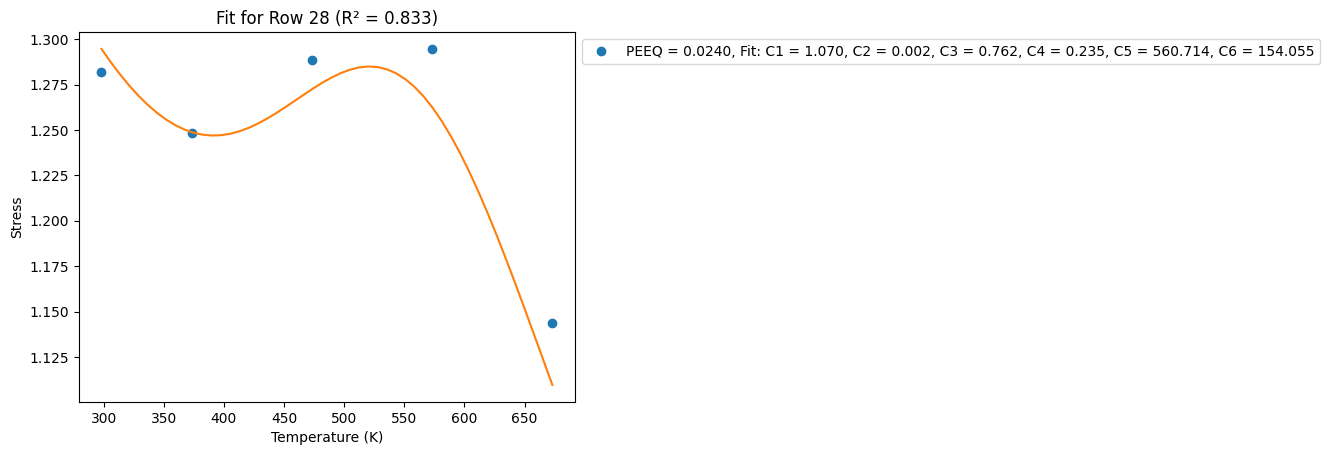

[1.28933018 1.25601087 1.29670201 1.30427379 1.15050424]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


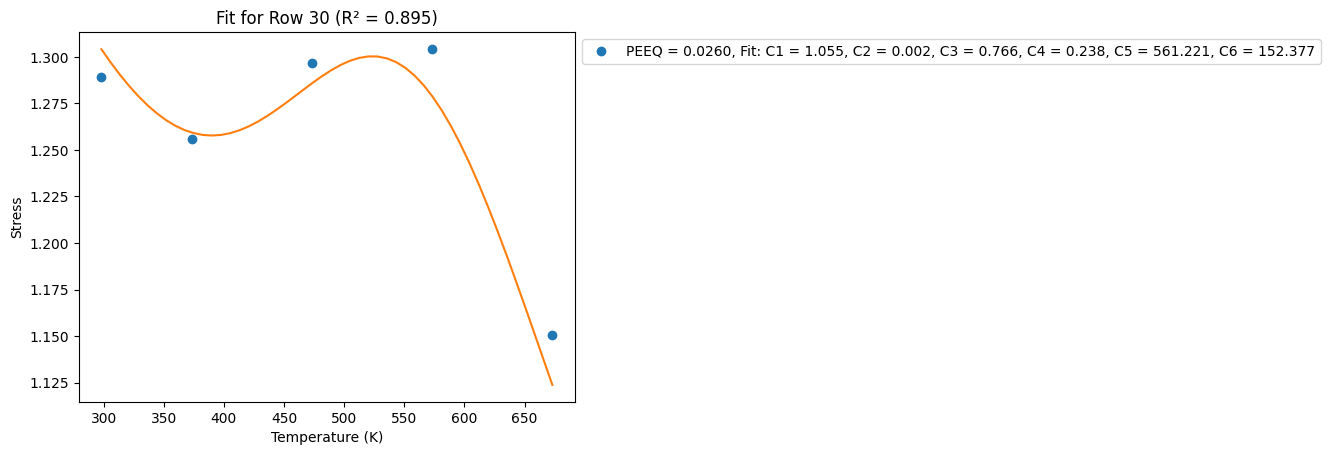

[1.29616433 1.26273359 1.30413294 1.31324706 1.15650831]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


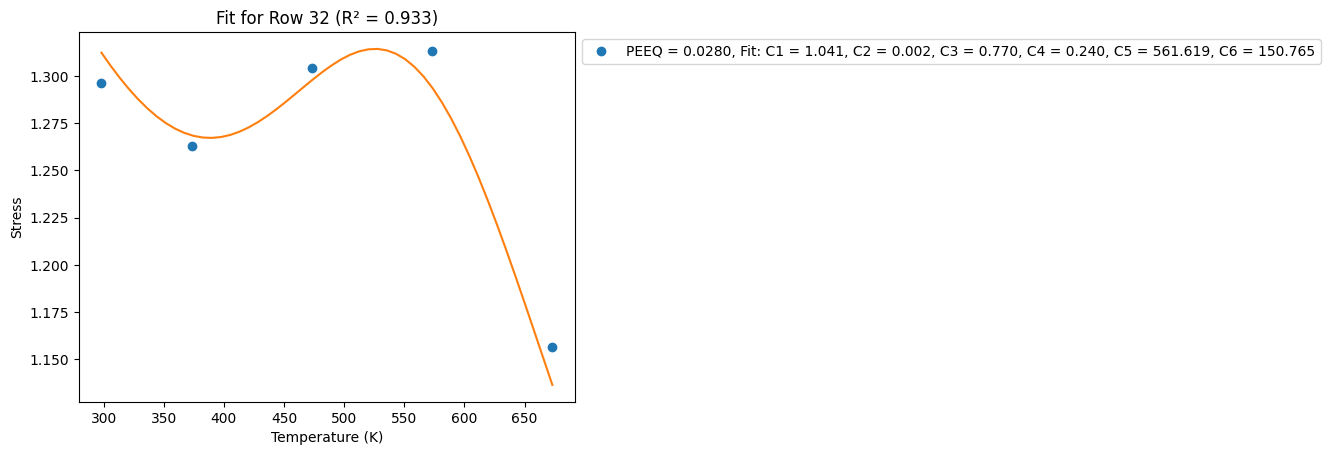

[1.30232053 1.26877772 1.31098851 1.32157639 1.16206881]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


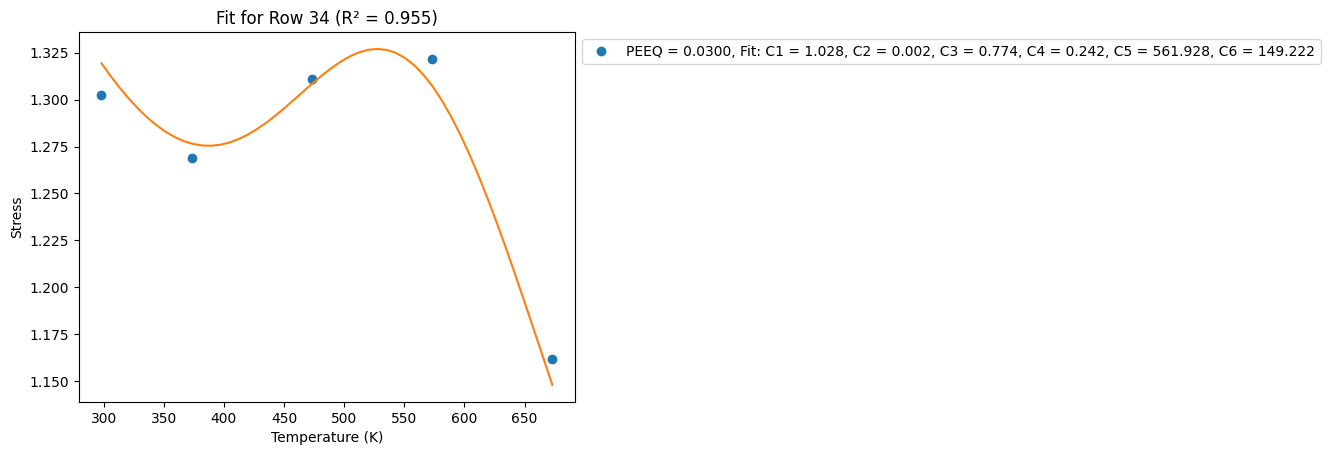

[1.30789679 1.27424204 1.31734776 1.32934746 1.16724917]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


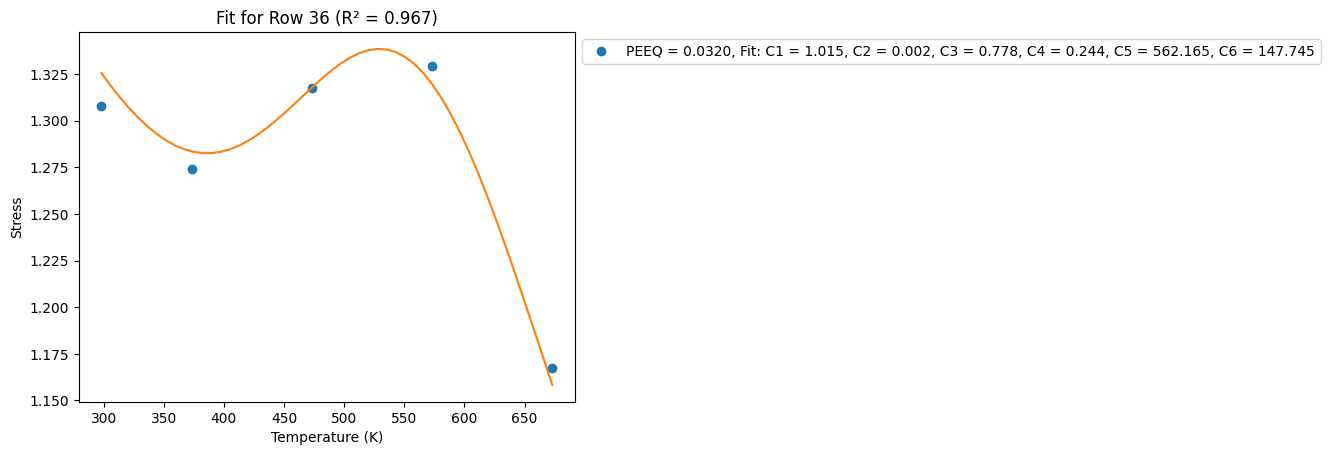

[1.31297356 1.27920783 1.3232747  1.33662995 1.17209973]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


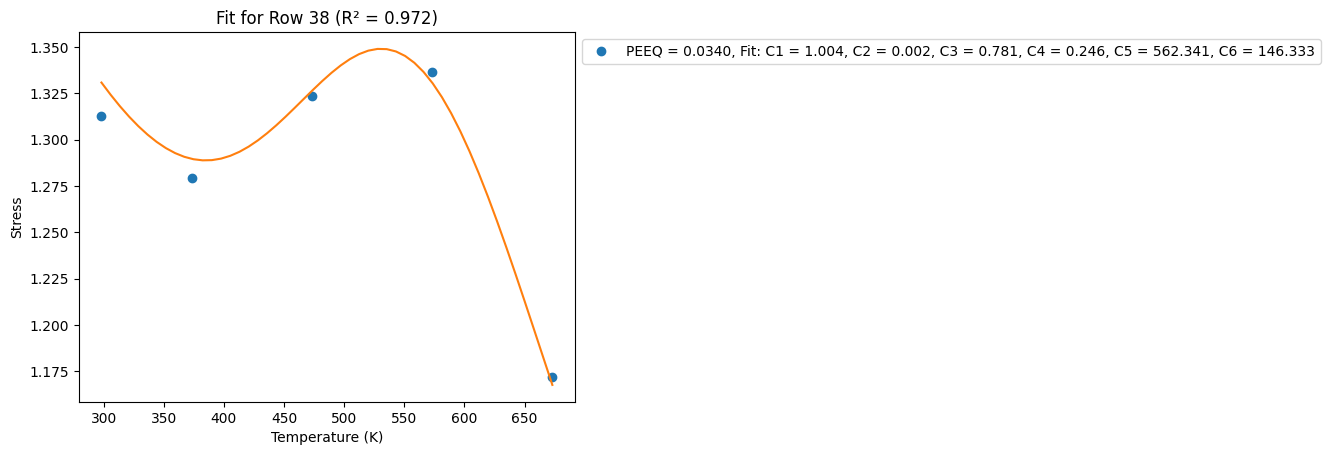

[1.3176175  1.28374258 1.32882186 1.34348129 1.17666112]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


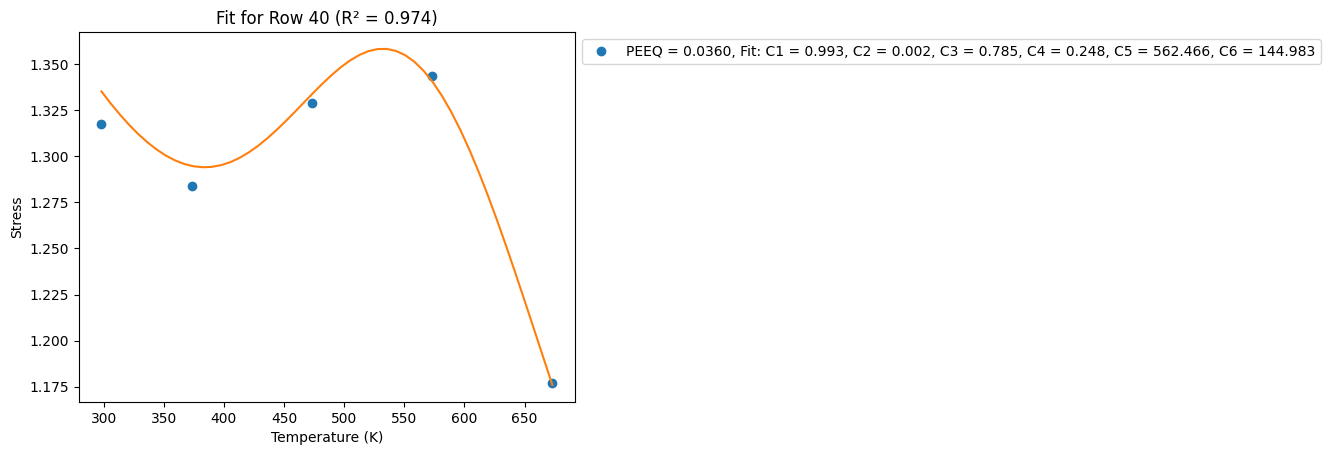

[1.32188437 1.28790274 1.33403291 1.34994935 1.18096666]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


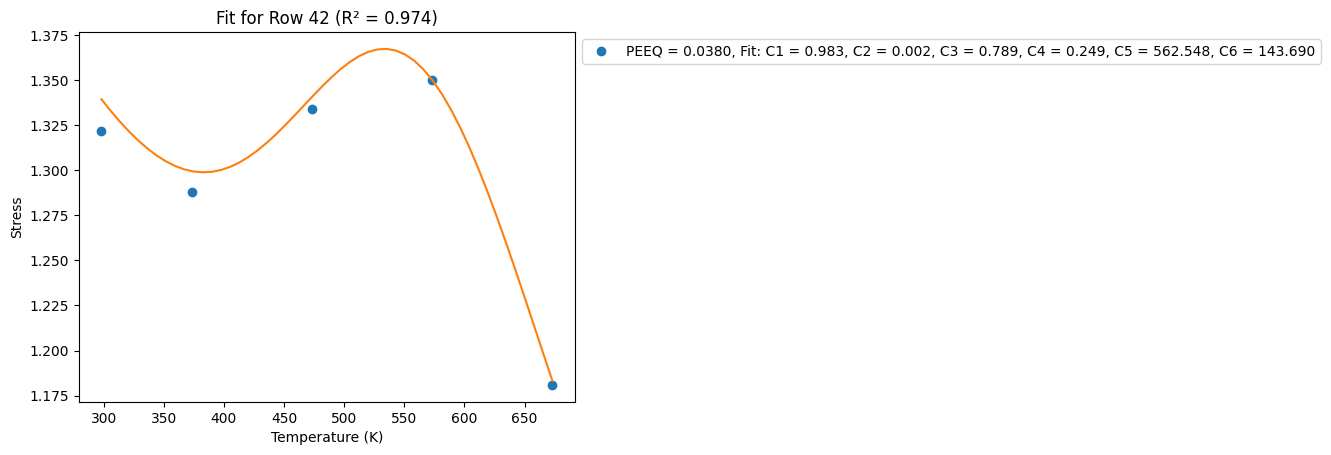

[1.32582108 1.29173584 1.33894449 1.35607446 1.18504405]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


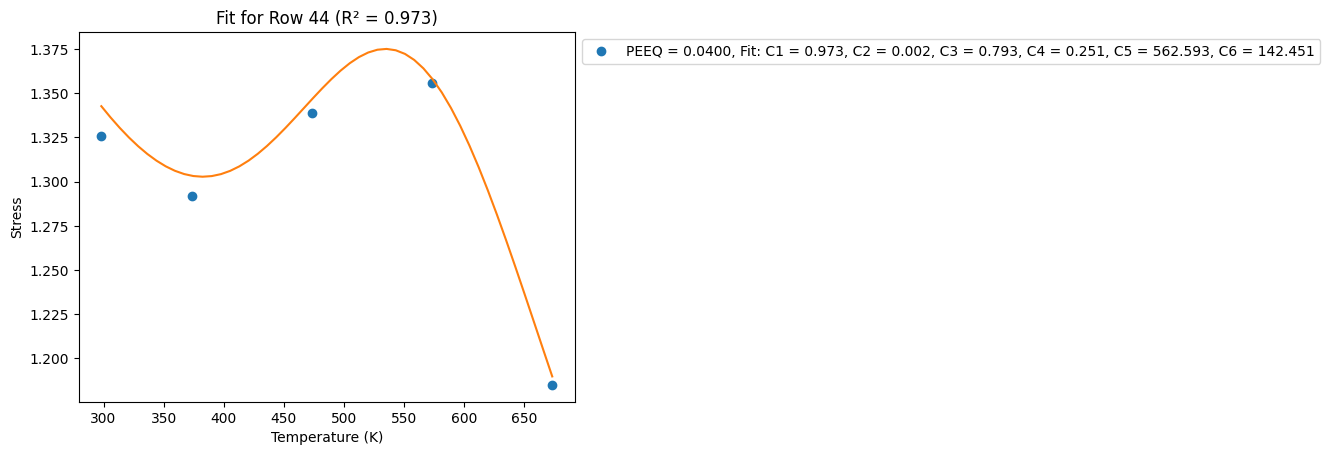

[1.32946743 1.29528211 1.34358765 1.36189093 1.18891661]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


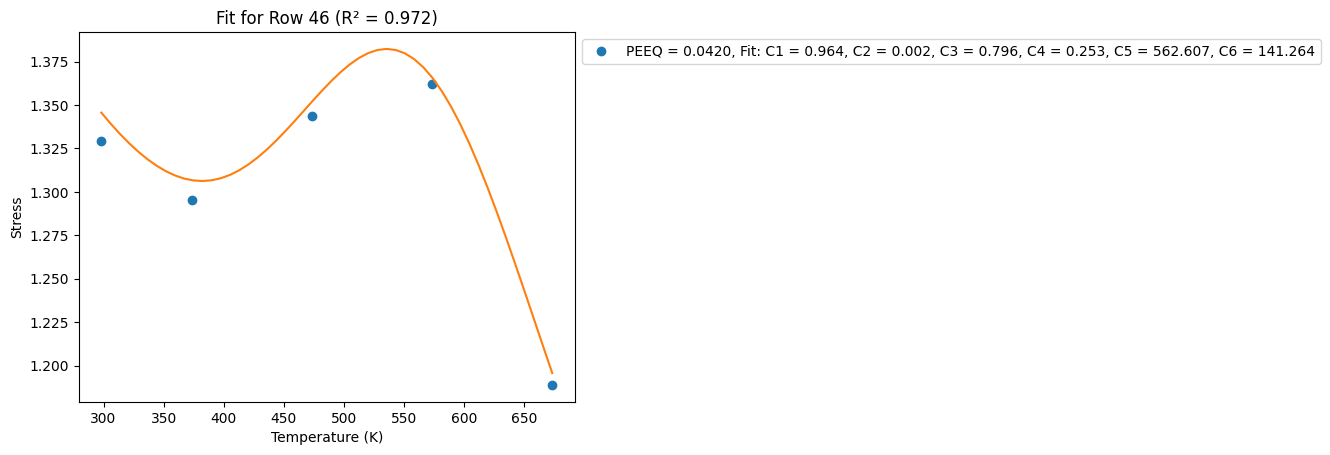

[1.3328573  1.29857578 1.3479889  1.36742817 1.19260417]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


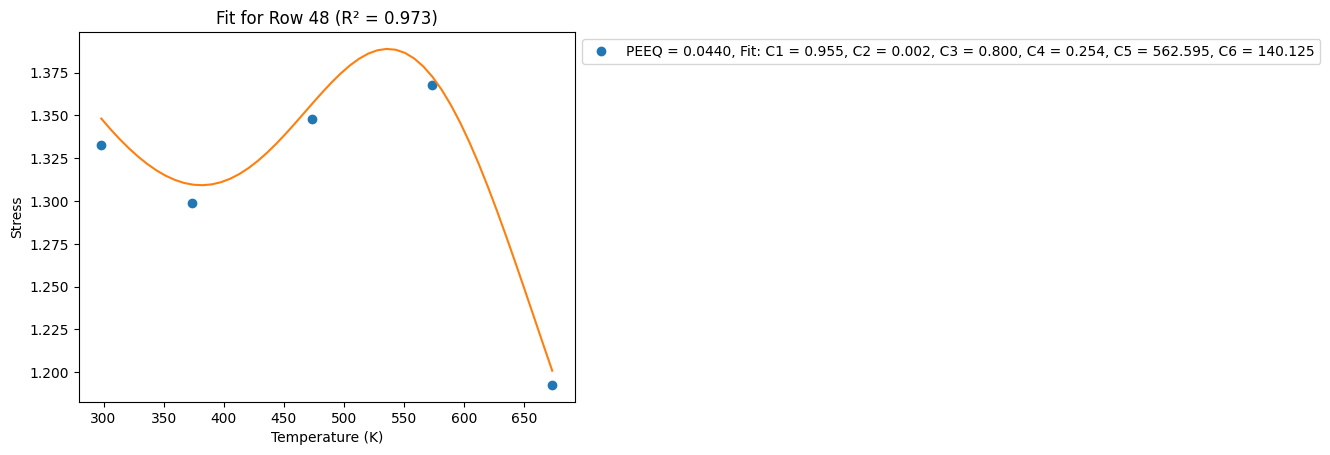

[1.3360197  1.30164609 1.35217109 1.37271159 1.19612375]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


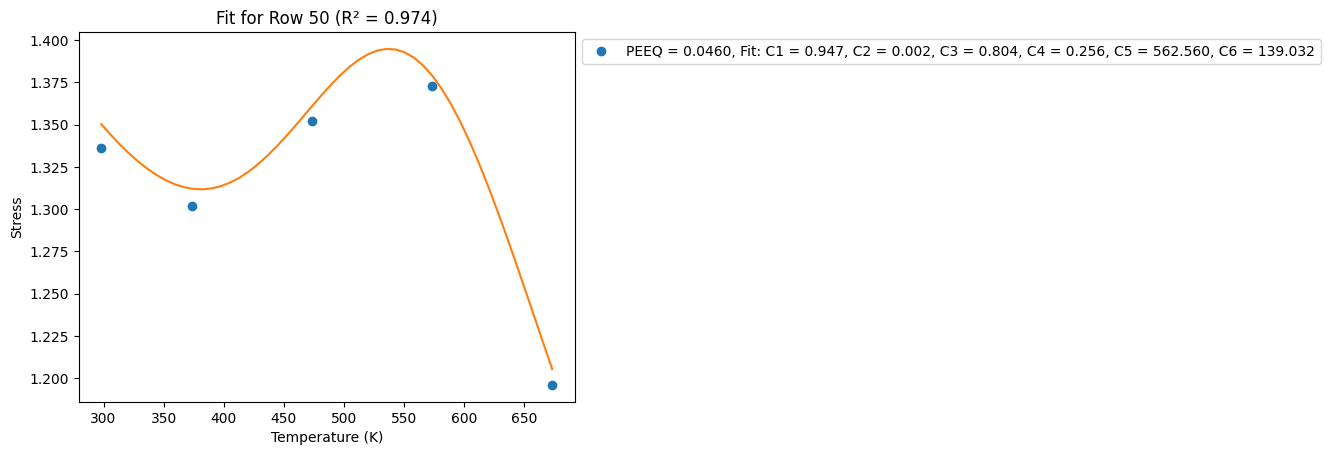

[1.33897959 1.30451814 1.35615401 1.37776327 1.19949009]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


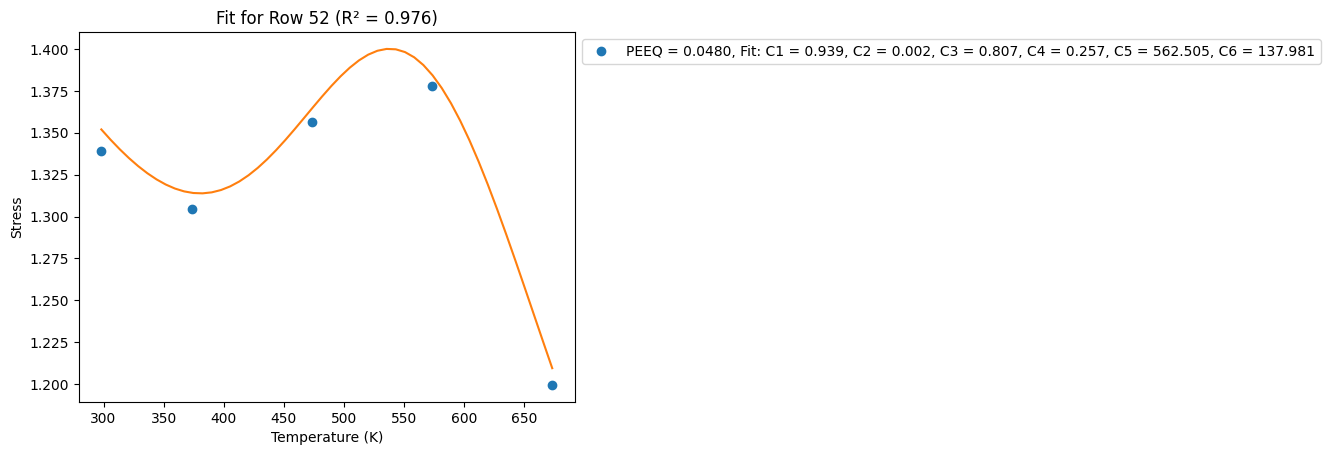

[1.3417585  1.30721353 1.35995494 1.38260256 1.20271605]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


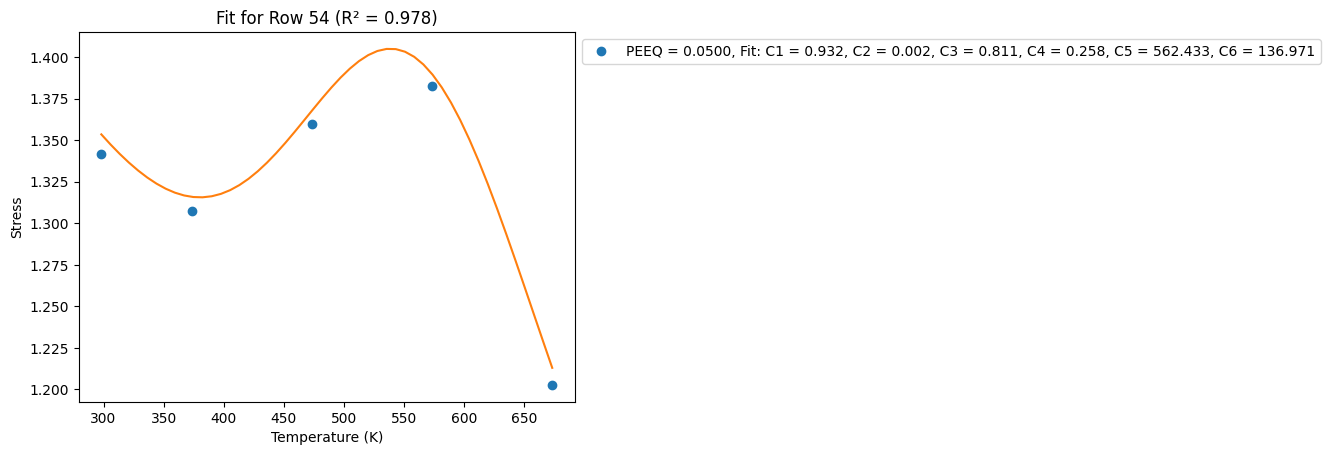

[1.34437511 1.30975092 1.36358903 1.38724647 1.2058129 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


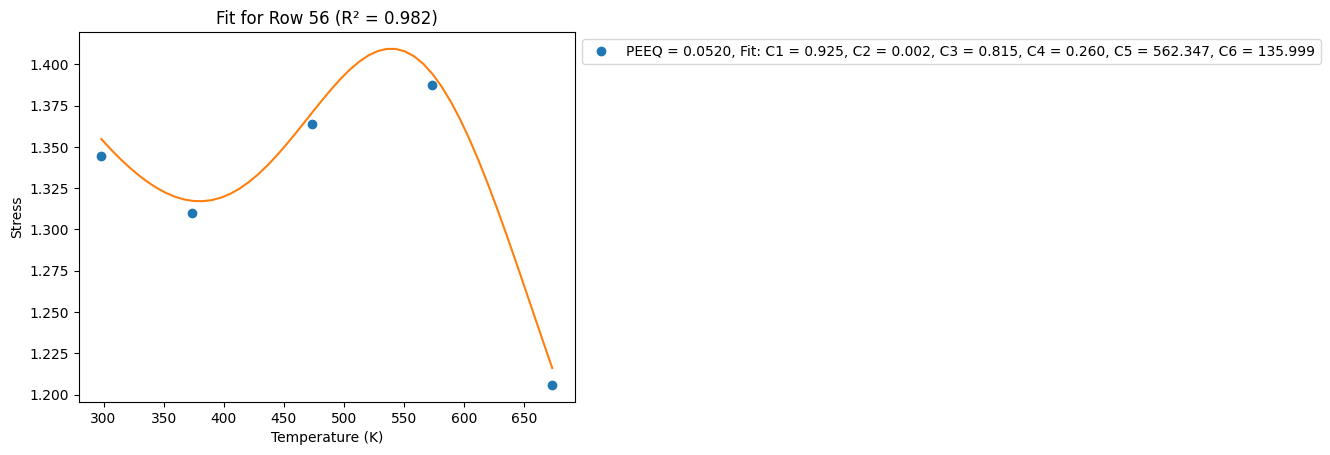

[1.34684566 1.3121465  1.36706964 1.39171006 1.20879061]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


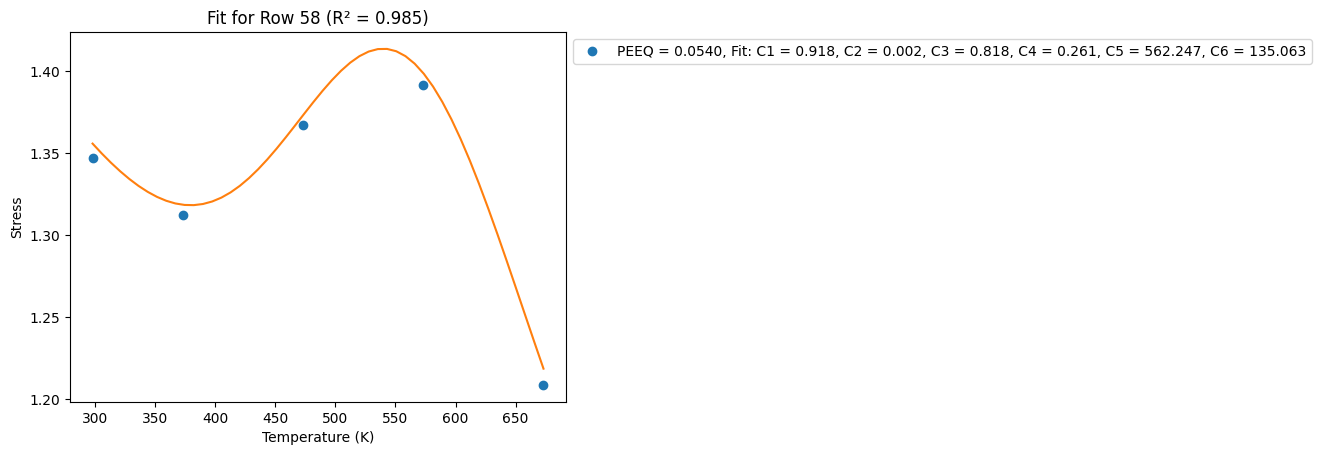

[1.34918431 1.31441434 1.37040862 1.39600673 1.21165803]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


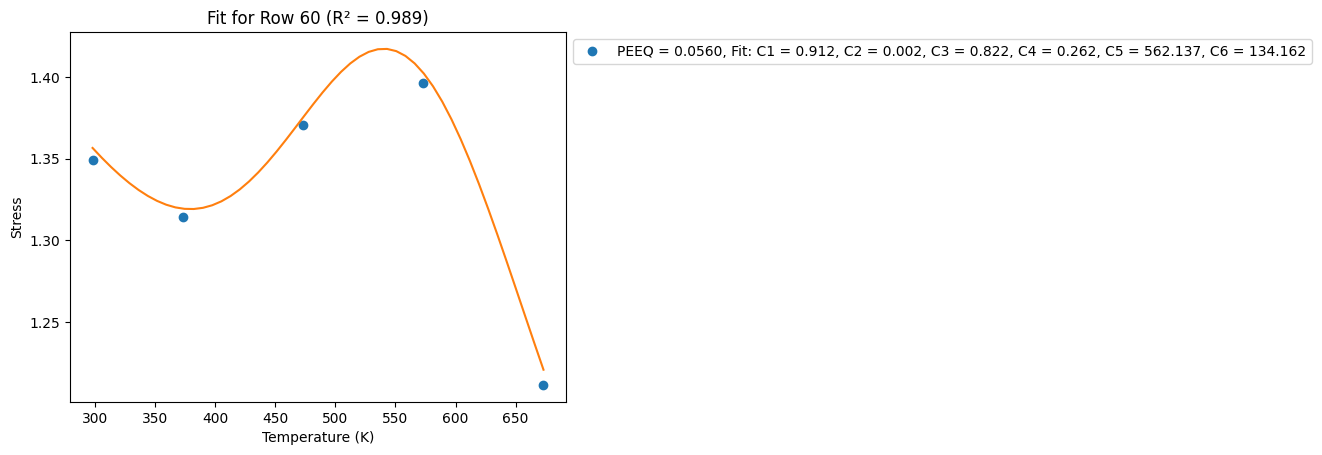

[1.35140348 1.31656673 1.37361652 1.4001484  1.21442305]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


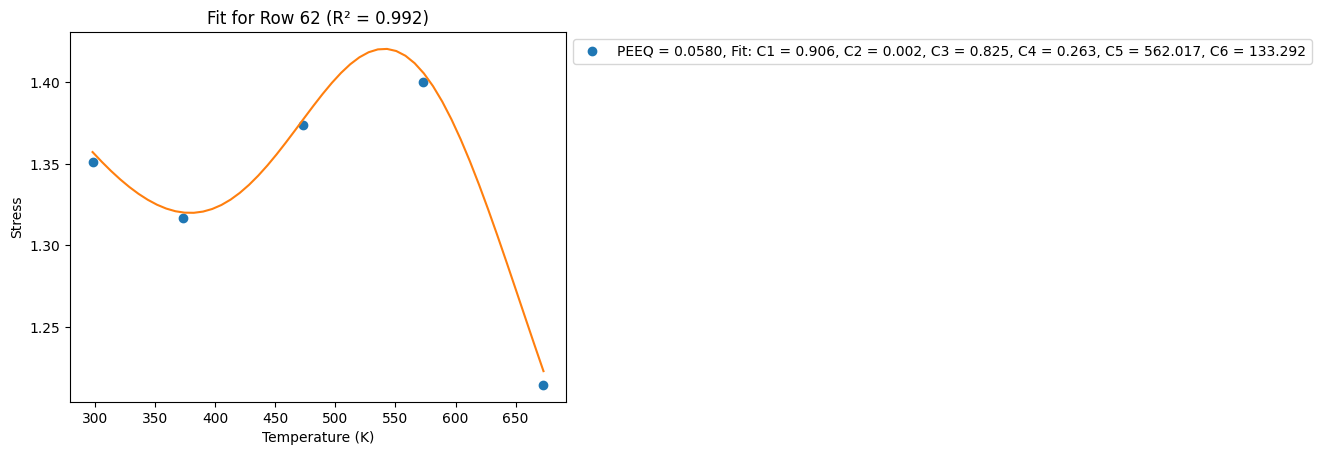

[1.35351405 1.3186144  1.37670275 1.40414581 1.21709274]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


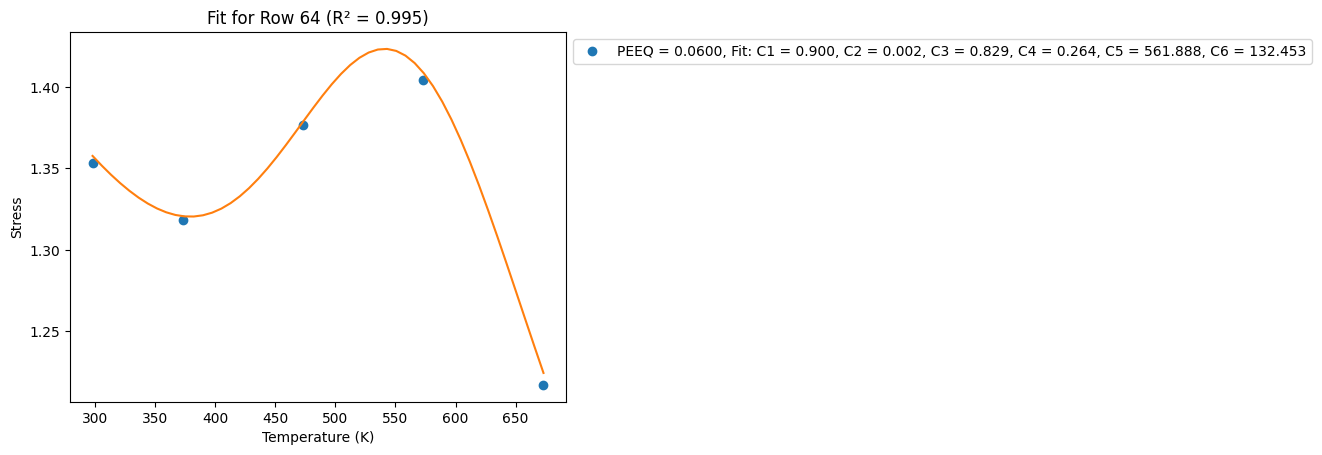

[1.35552561 1.32056679 1.3796758  1.40800859 1.21967346]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


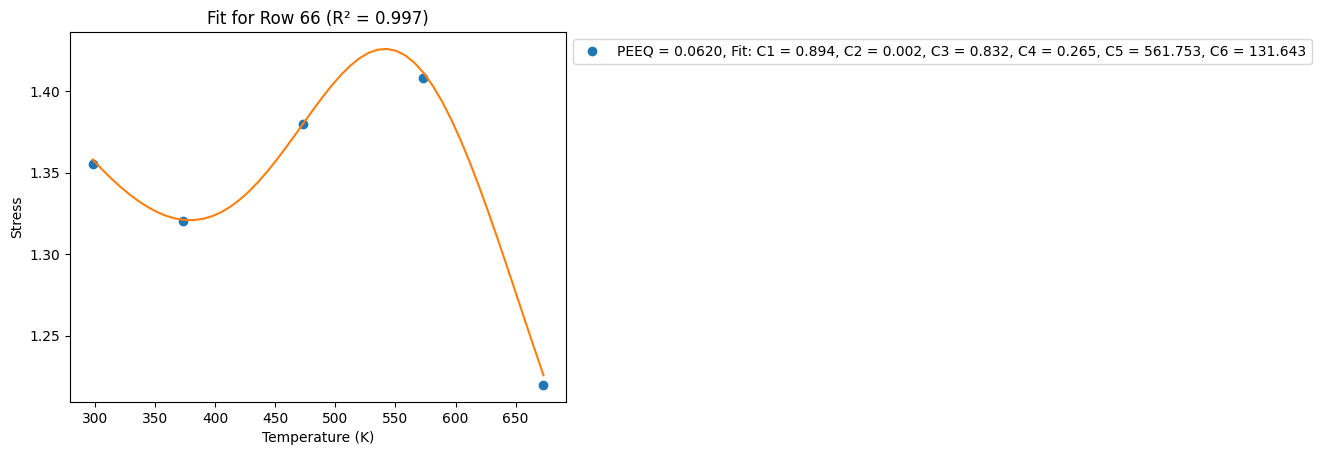

[1.35744663 1.32243219 1.38254327 1.41174546 1.22217095]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


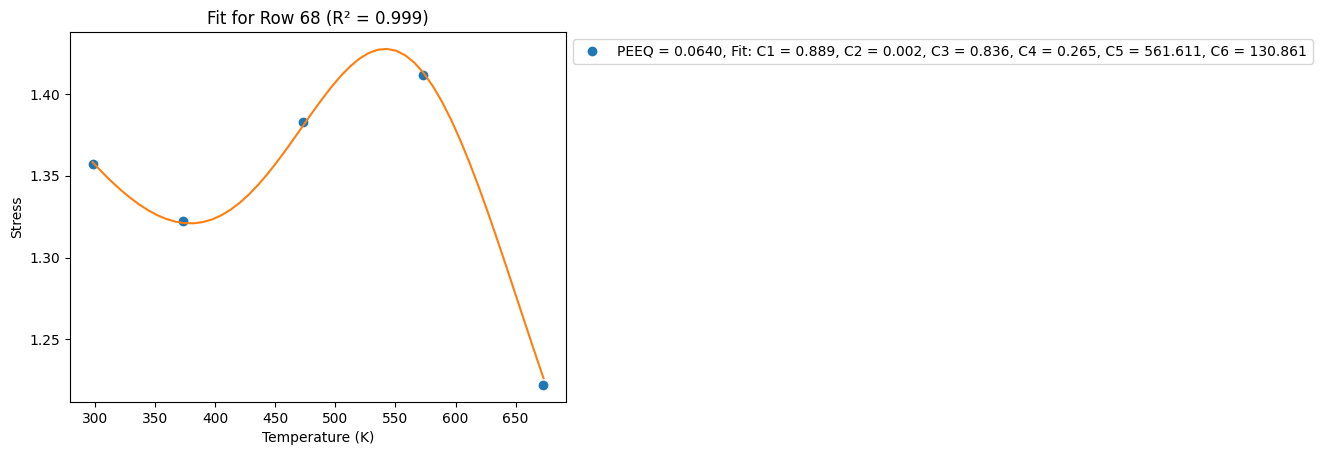

[1.35928462 1.32421793 1.38531207 1.4153643  1.22459042]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


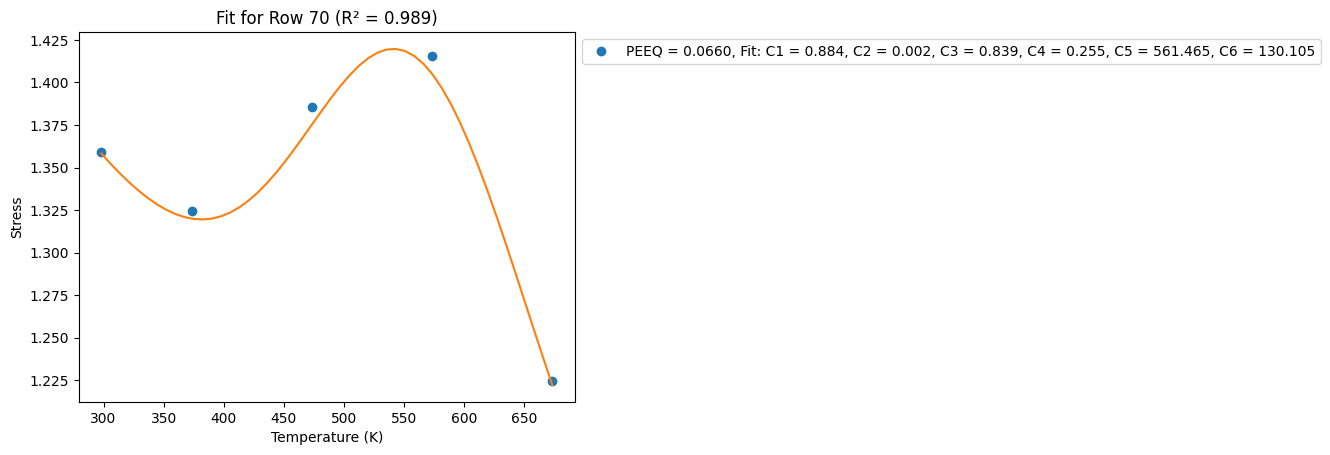

[1.36104624 1.3259305  1.38798844 1.41887229 1.22693659]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


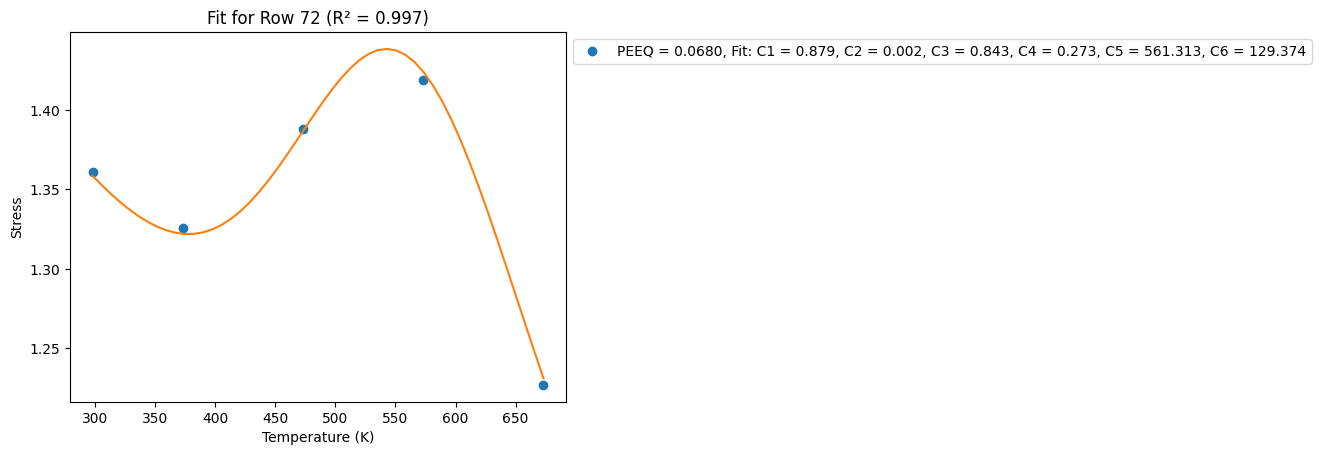

[1.36273742 1.32757565 1.39057805 1.42227597 1.22921378]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


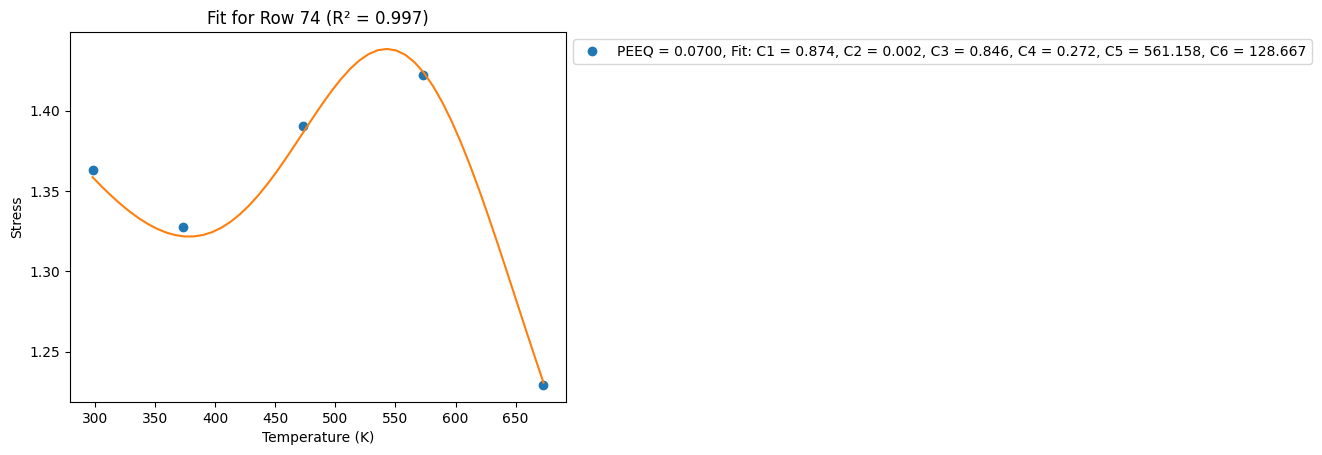

[1.36436346 1.32915852 1.3930861  1.42558132 1.23142593]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


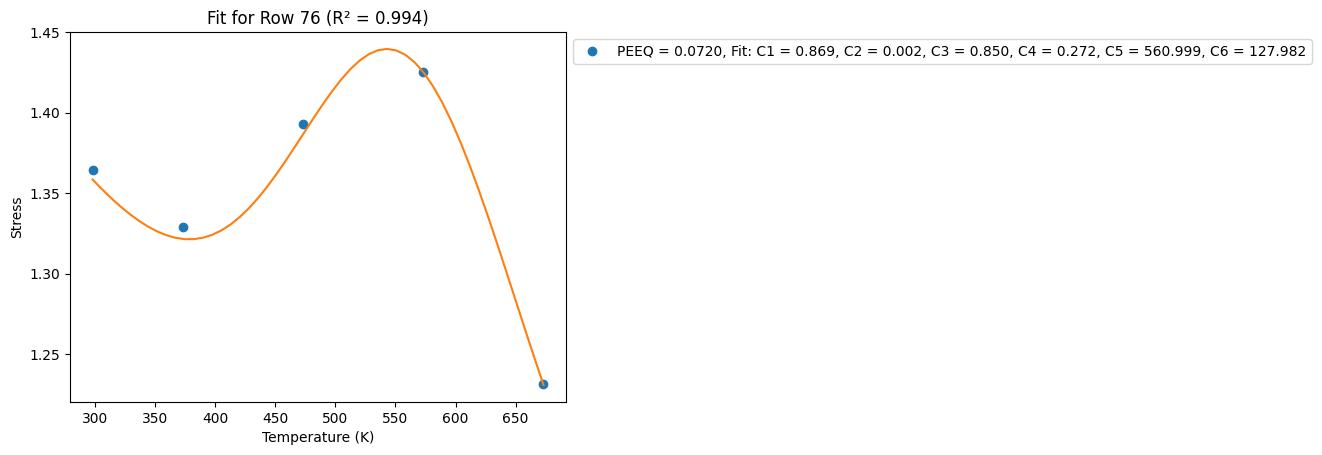

[1.36592911 1.33068368 1.39551732 1.42879383 1.23357665]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


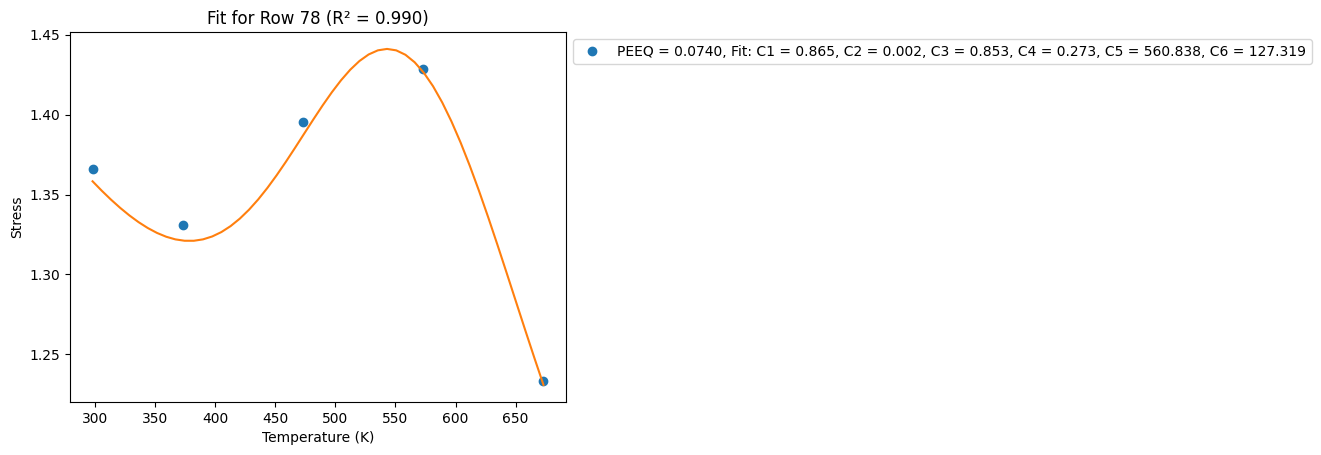

[1.36743863 1.33215523 1.39787606 1.43191853 1.23566926]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


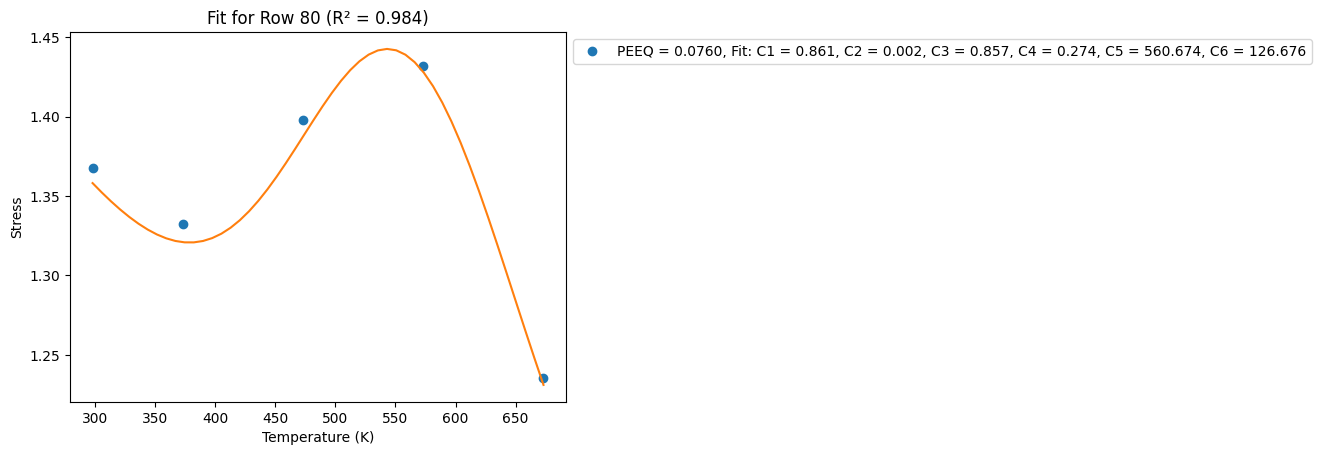

[1.36889585 1.33357686 1.40016631 1.43496006 1.23770682]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


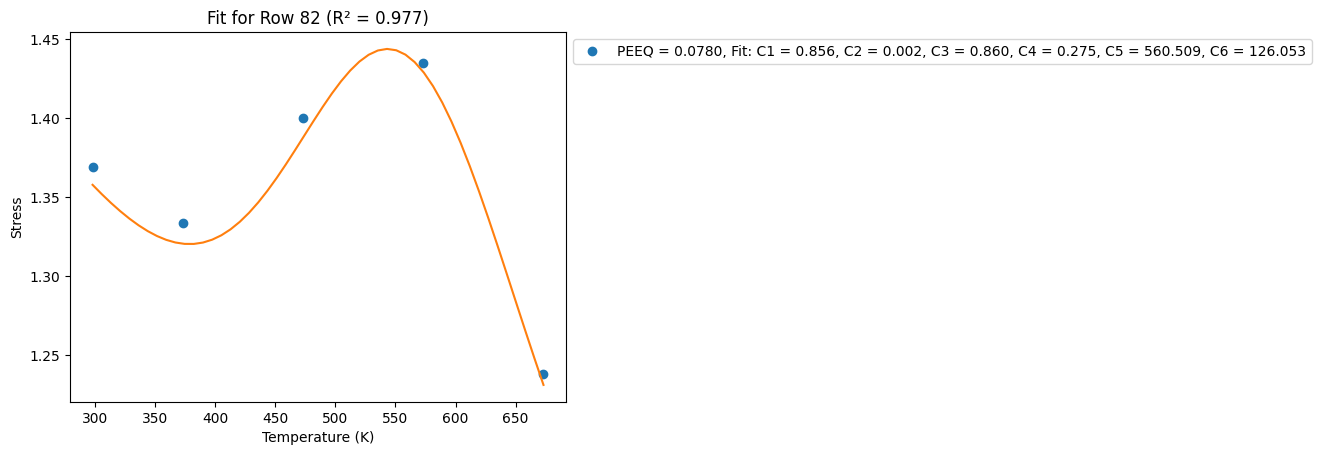

[1.37030423 1.33495186 1.40239174 1.43792269 1.23969215]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


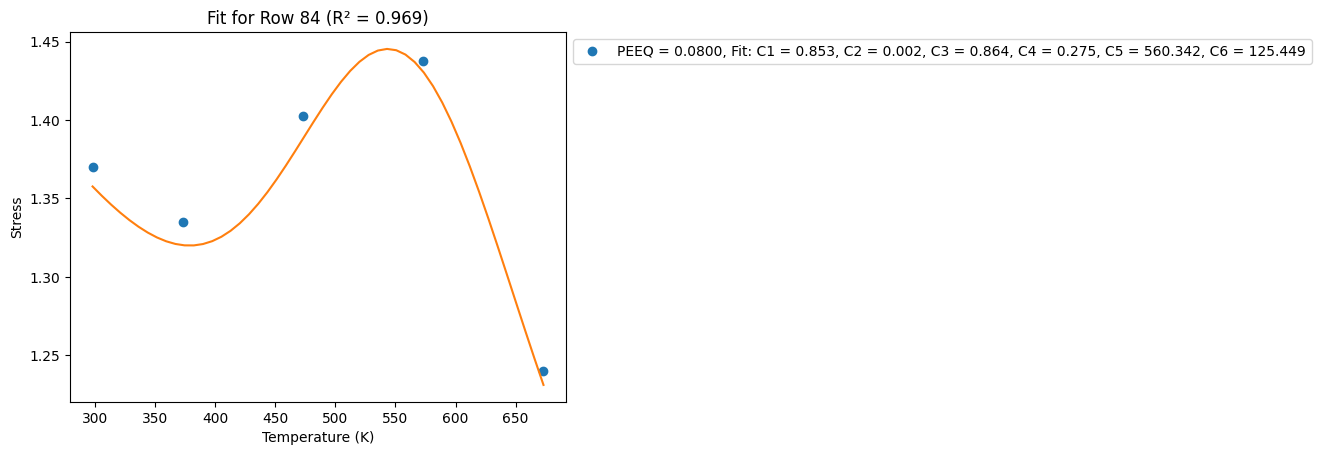

[1.37166691 1.33628325 1.40455575 1.4408104  1.24162786]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


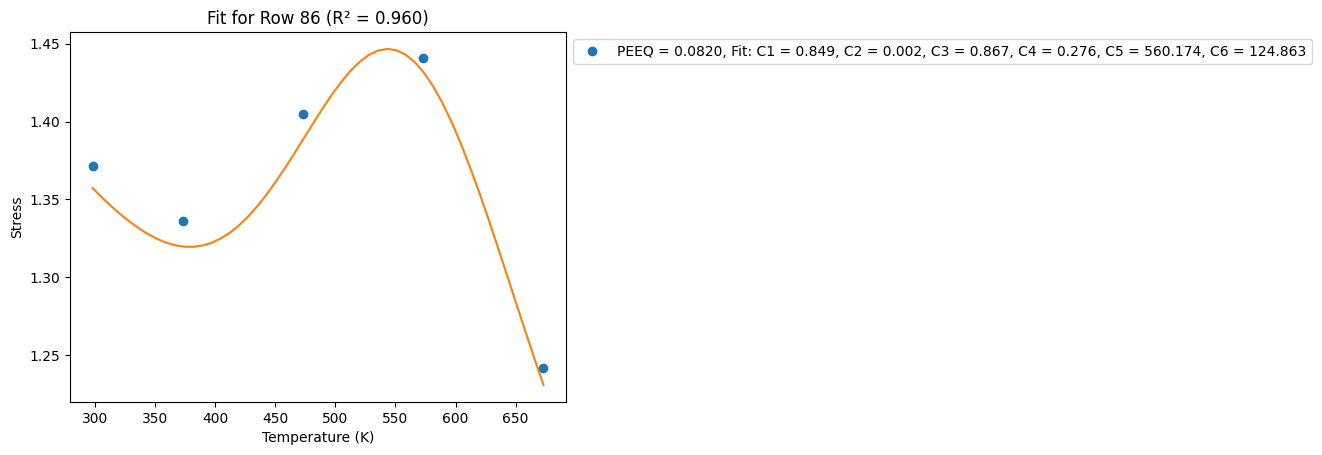

[1.37298672 1.33757373 1.40666148 1.44362684 1.24351638]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


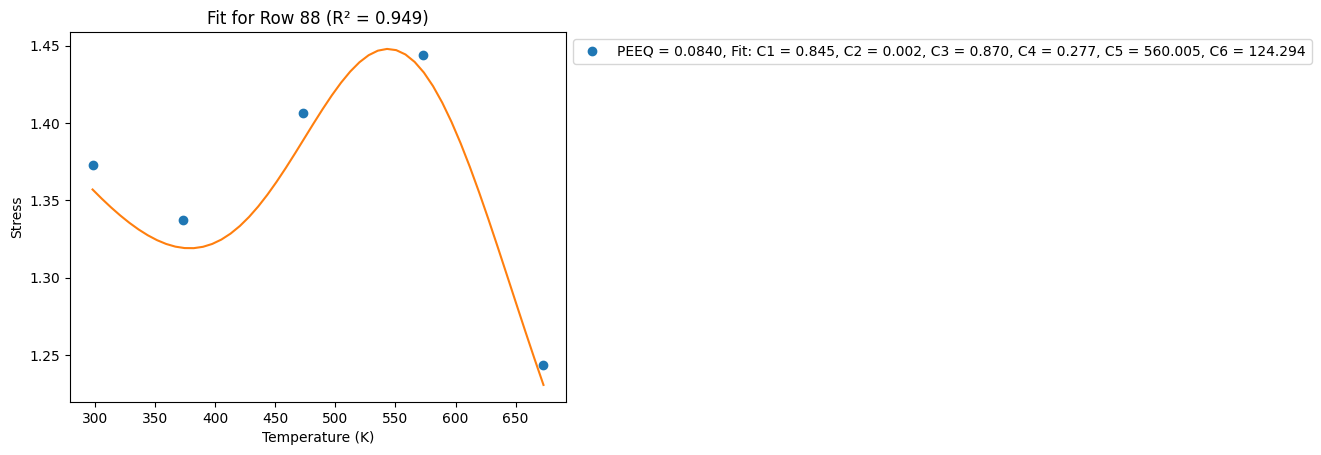

[1.37426625 1.33882575 1.40871182 1.44637543 1.24535994]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


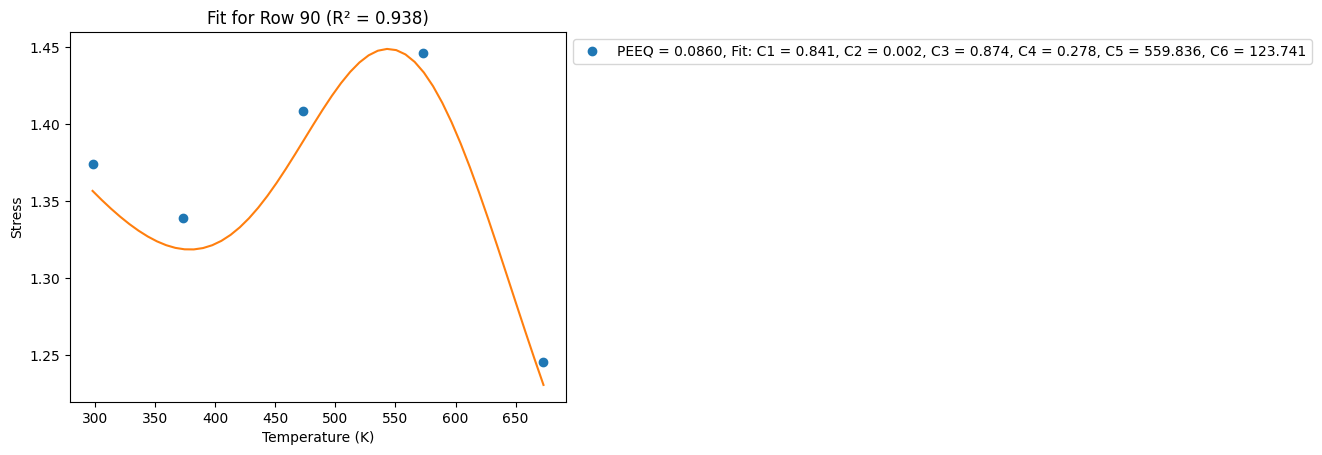

[1.37550785 1.34004156 1.41070949 1.44905934 1.24716065]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


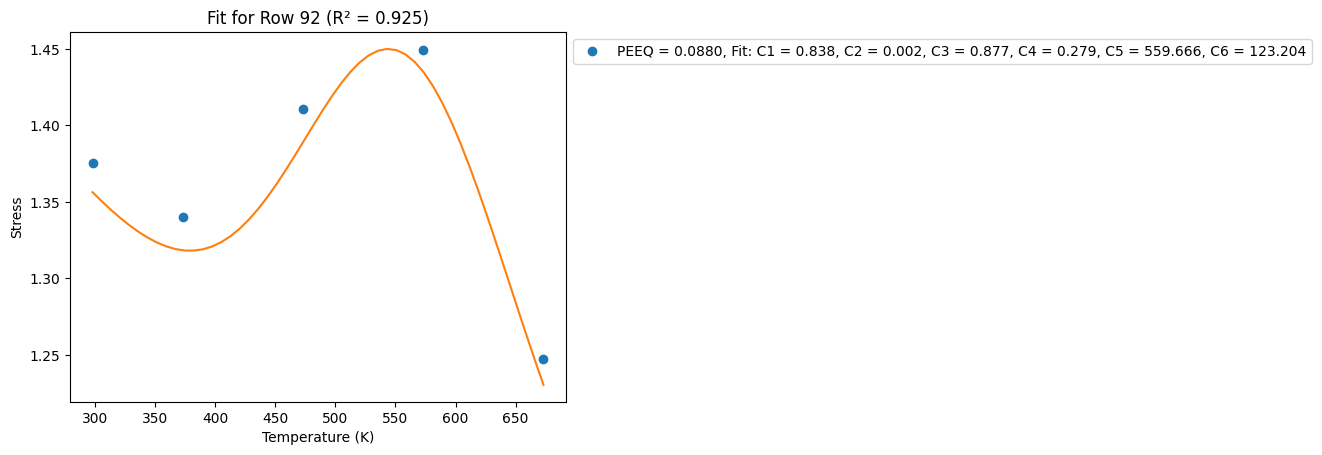

[1.37671367 1.3412232  1.41265699 1.45168151 1.24892045]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


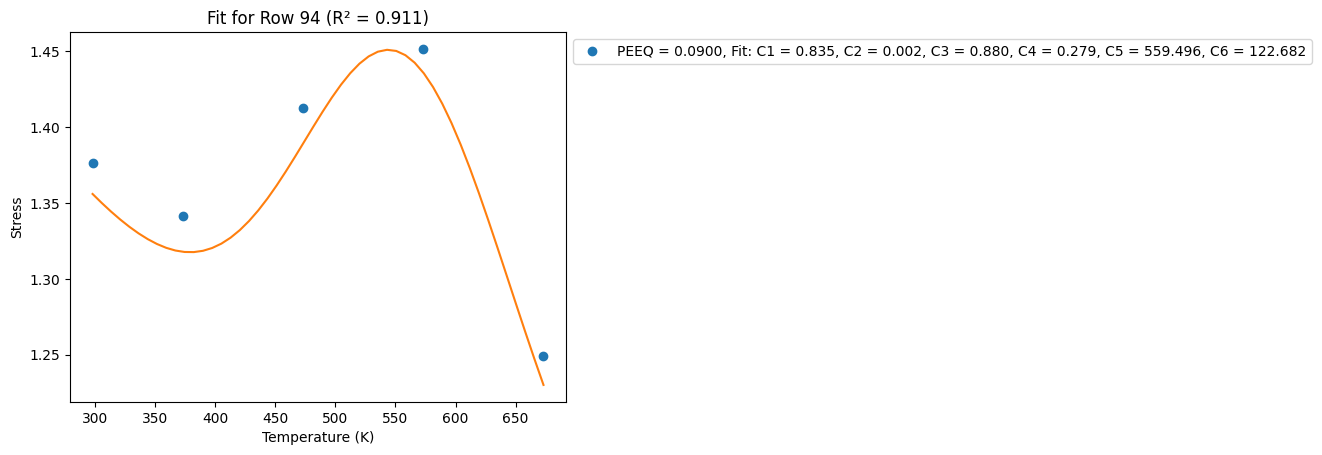

[1.37788568 1.34237254 1.41455665 1.45424471 1.25064115]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


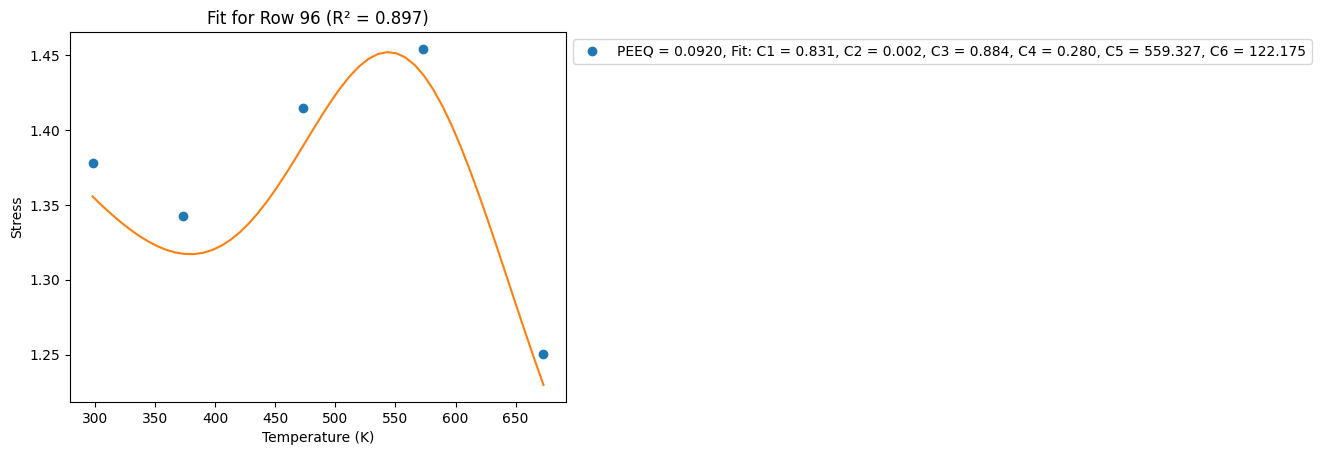

[1.37902569 1.3434913  1.41641067 1.4567515  1.25232445]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


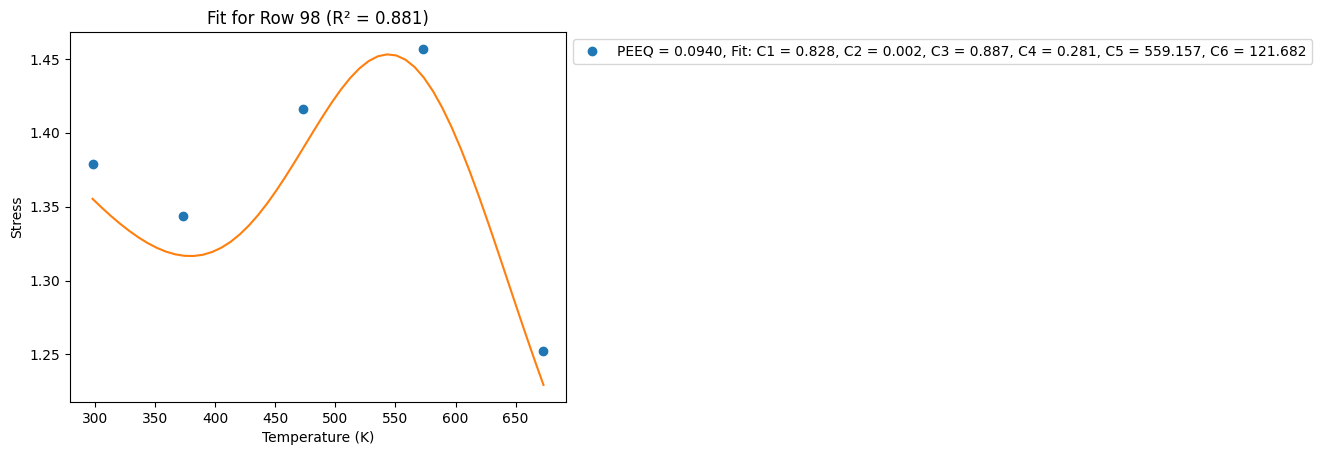

[1.38013537 1.34458104 1.41822106 1.45920431 1.25397195]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


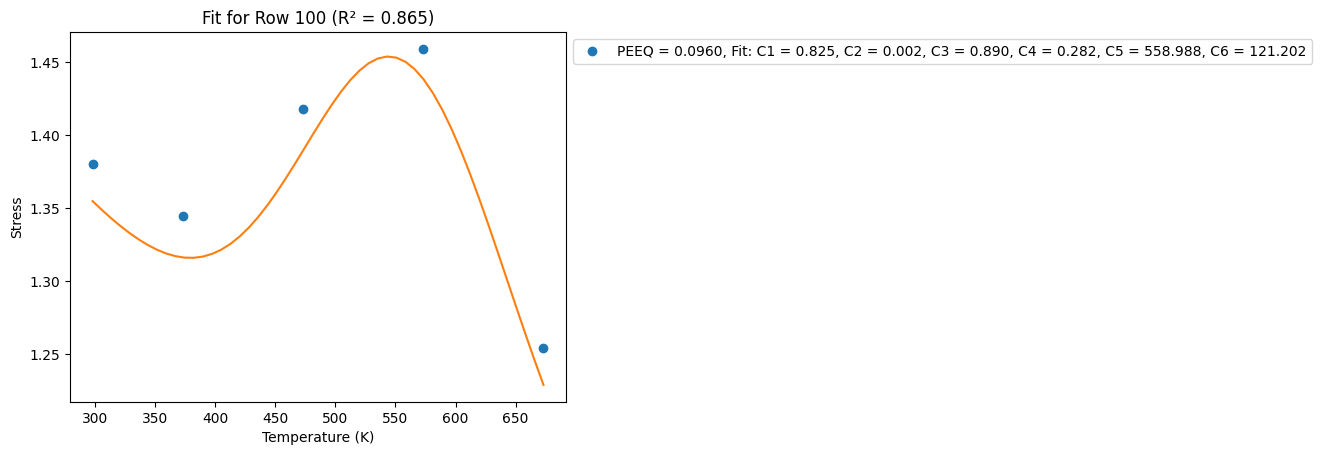

[1.38121625 1.34564323 1.41998975 1.46160538 1.25558514]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


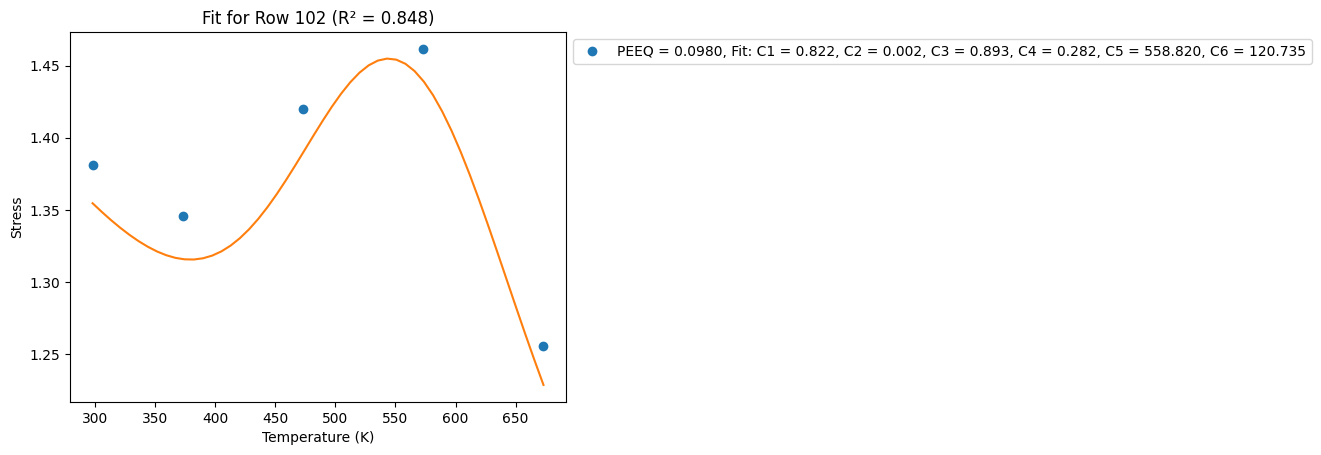

[1.38226975 1.3466792  1.42171851 1.46395685 1.25716542]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


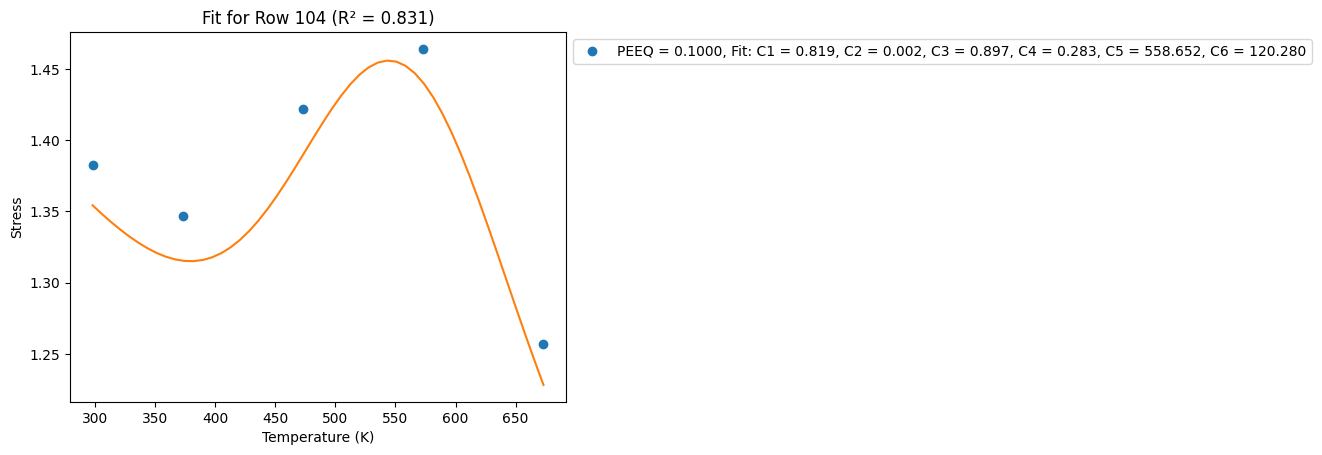

[1.38762872 1.35195974 1.43058309 1.47608661 1.26532377]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


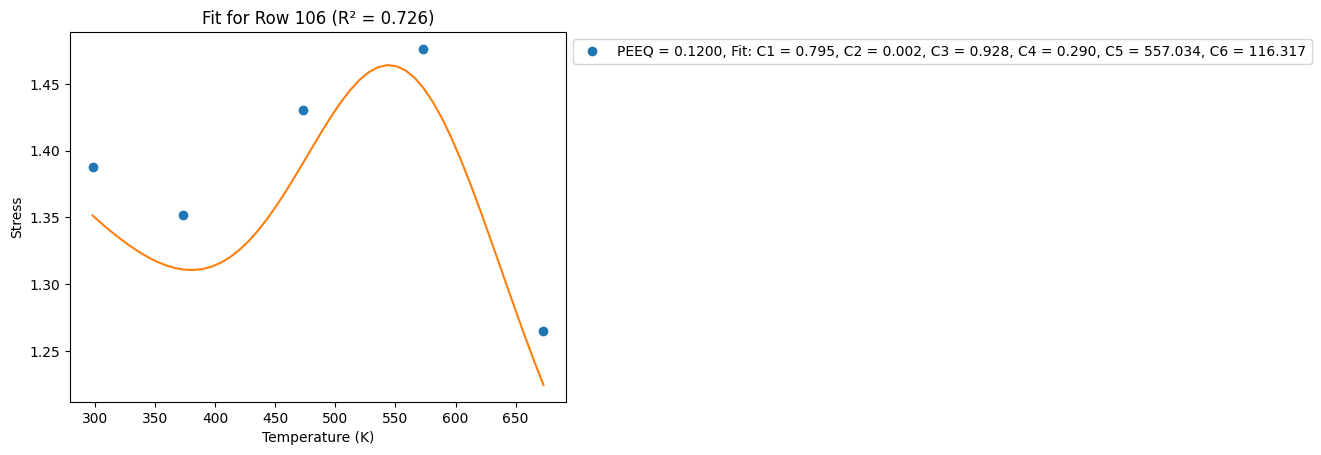

[1.39587329 1.36011881 1.44443258 1.49528511 1.27825984]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


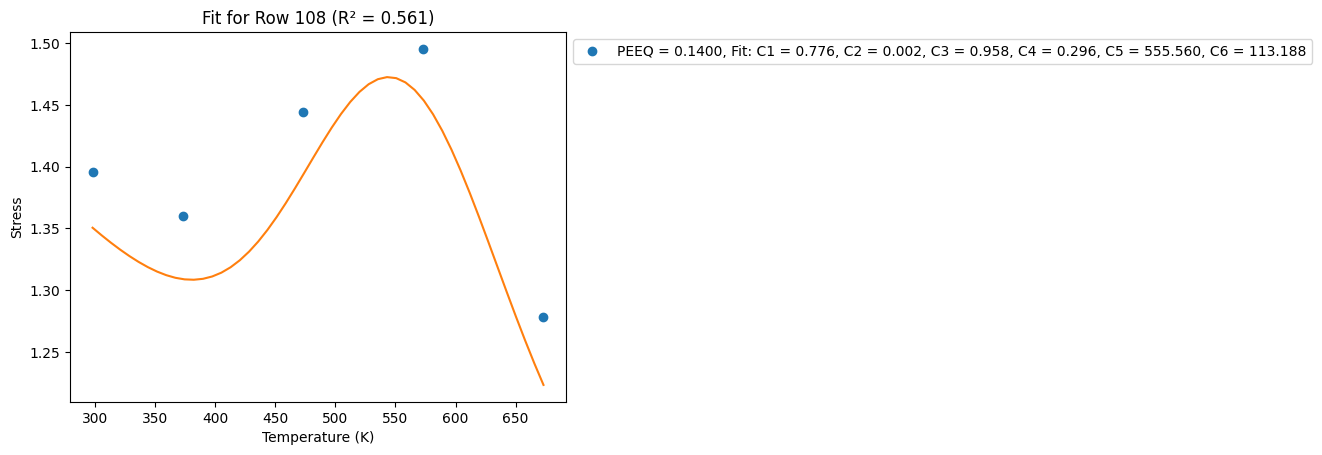

[1.40270938 1.36691638 1.45609696 1.51169695 1.28934161]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


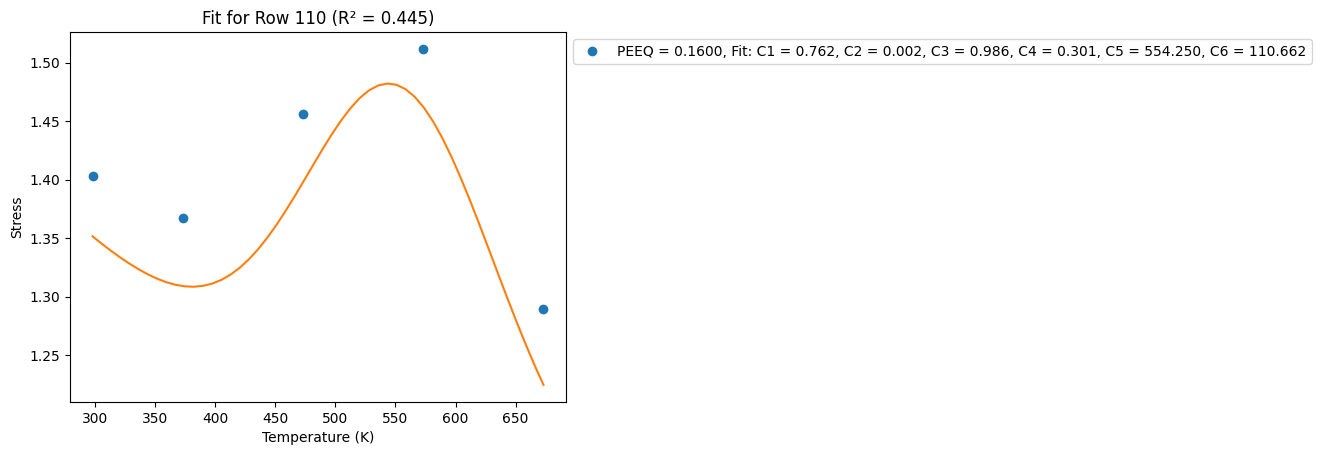

[1.40852678 1.3727243  1.46614969 1.52602534 1.29903467]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


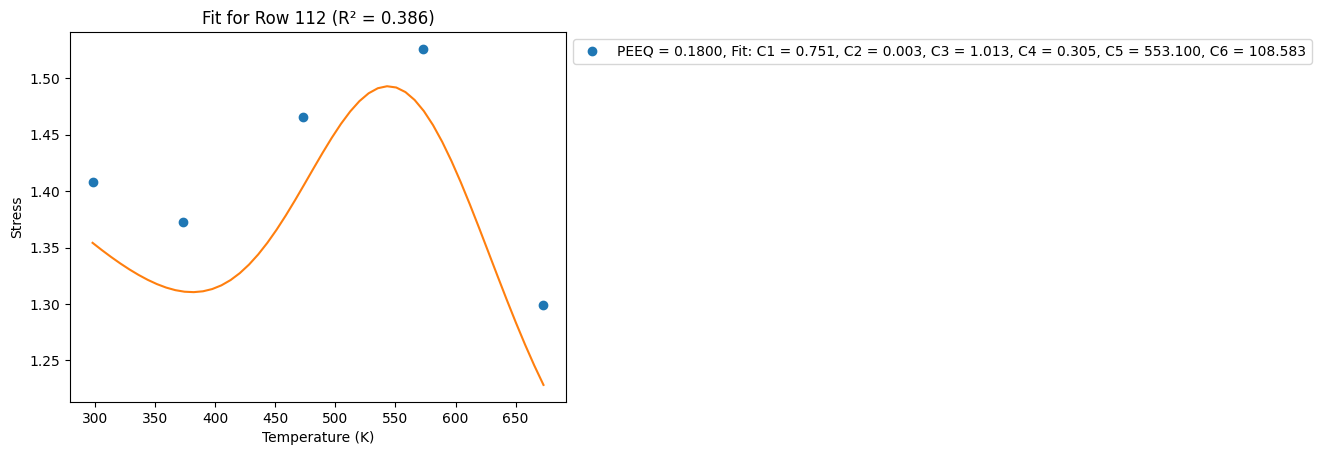

[1.41357393 1.3777809  1.47496686 1.53873731 1.30764864]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


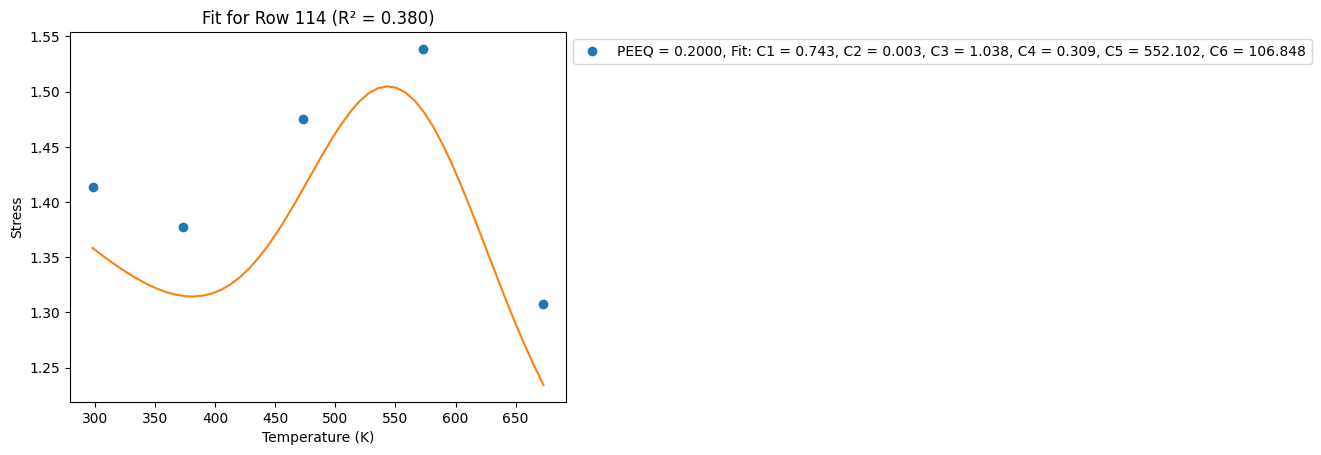

[1.41801944 1.38224859 1.48280809 1.55015883 1.31539991]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


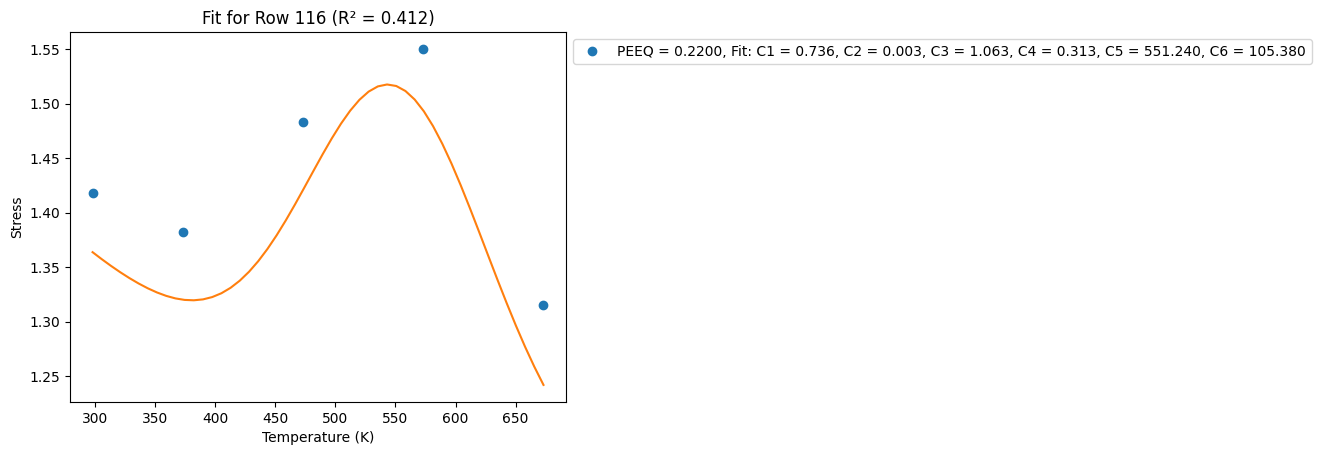

[1.42198294 1.38624306 1.48985987 1.56052639 1.32244567]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


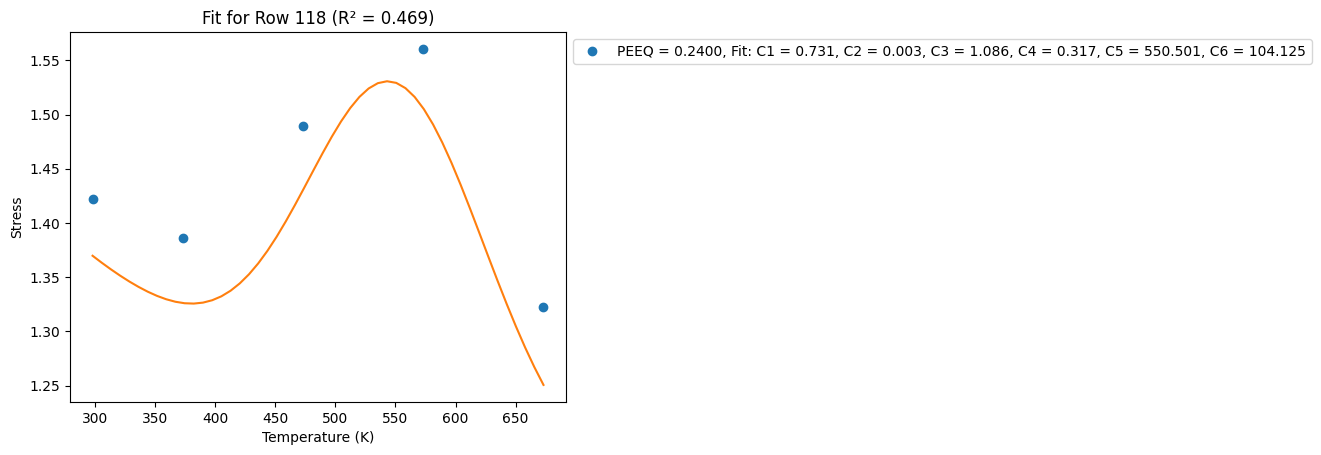

[1.42555229 1.38984953 1.49626052 1.57001703 1.32890371]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


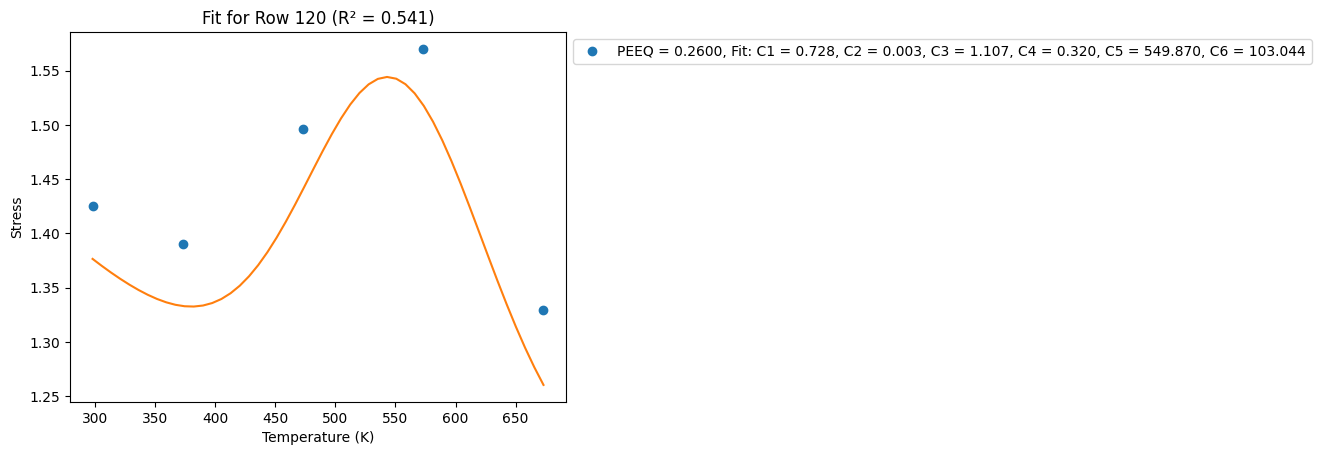

[1.42879385 1.39313249 1.50211539 1.57876669 1.33486458]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


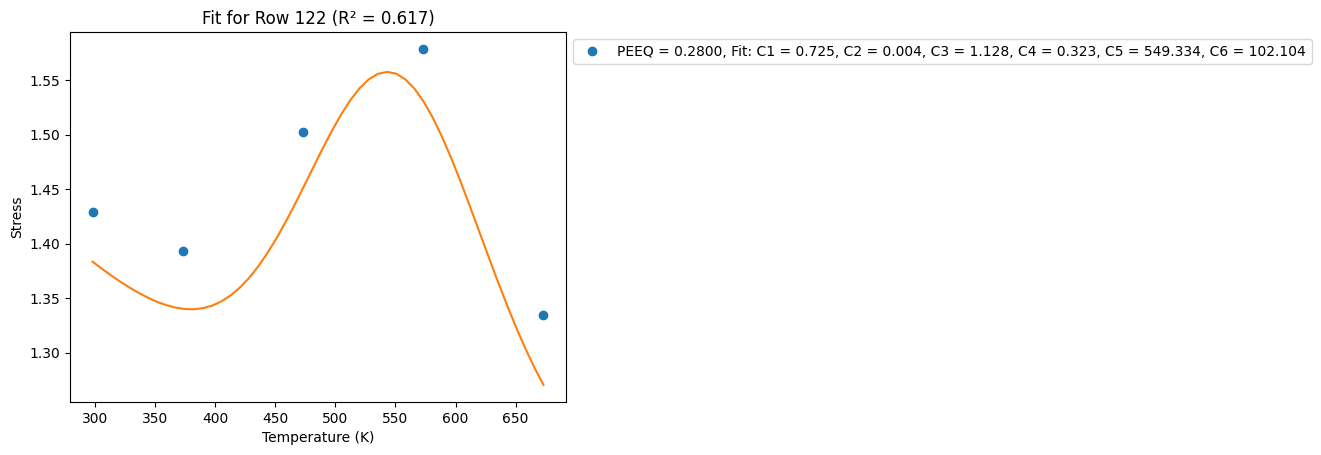

[1.43175885 1.39614191 1.50750651 1.58688202 1.34039939]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


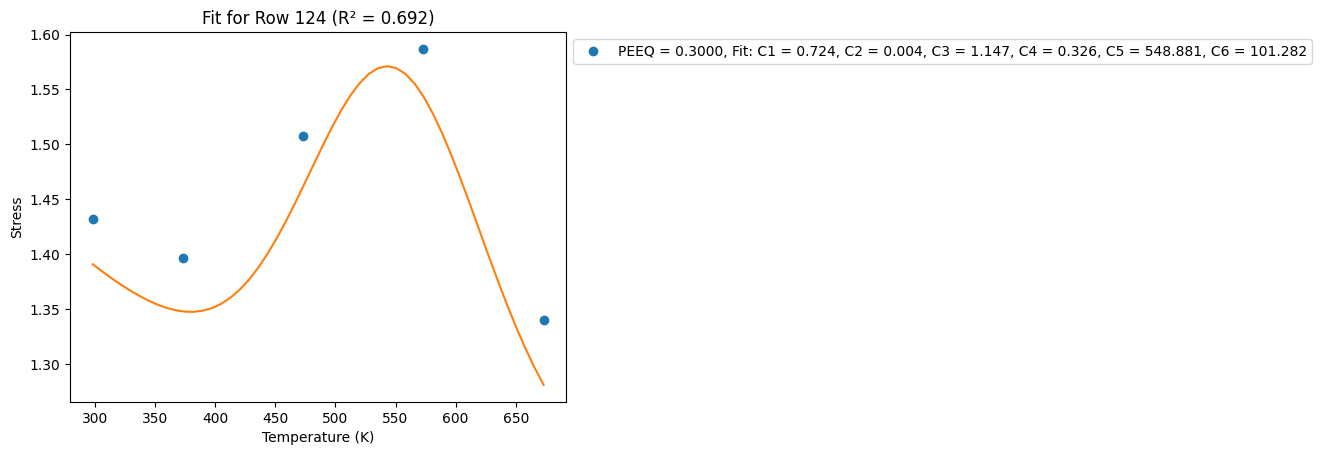

[1.43448767 1.39891722 1.51249894 1.59444824 1.345565  ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


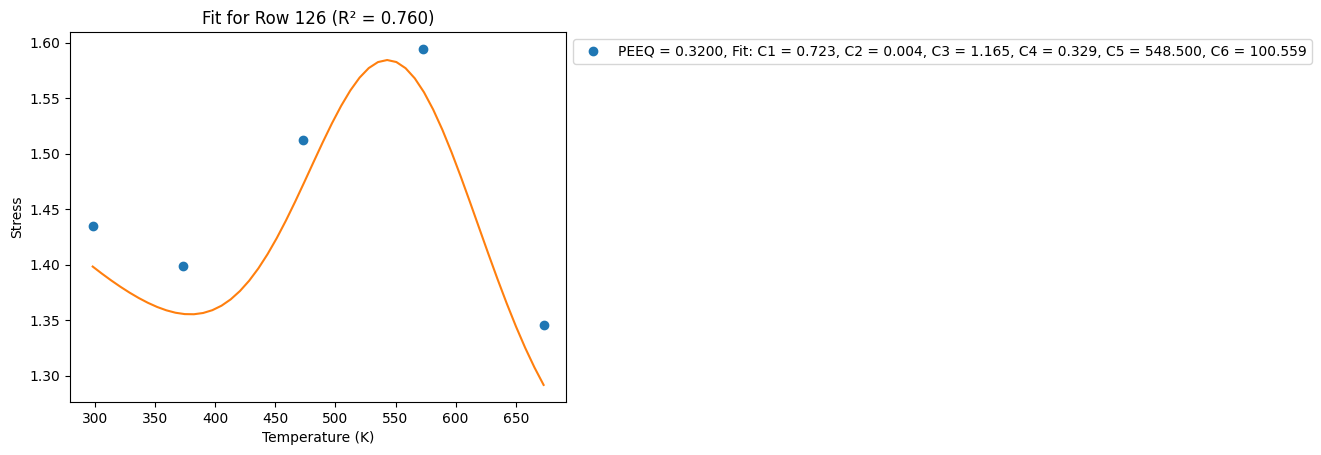

[1.43701264 1.40149007 1.51714514 1.60153449 1.35040762]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


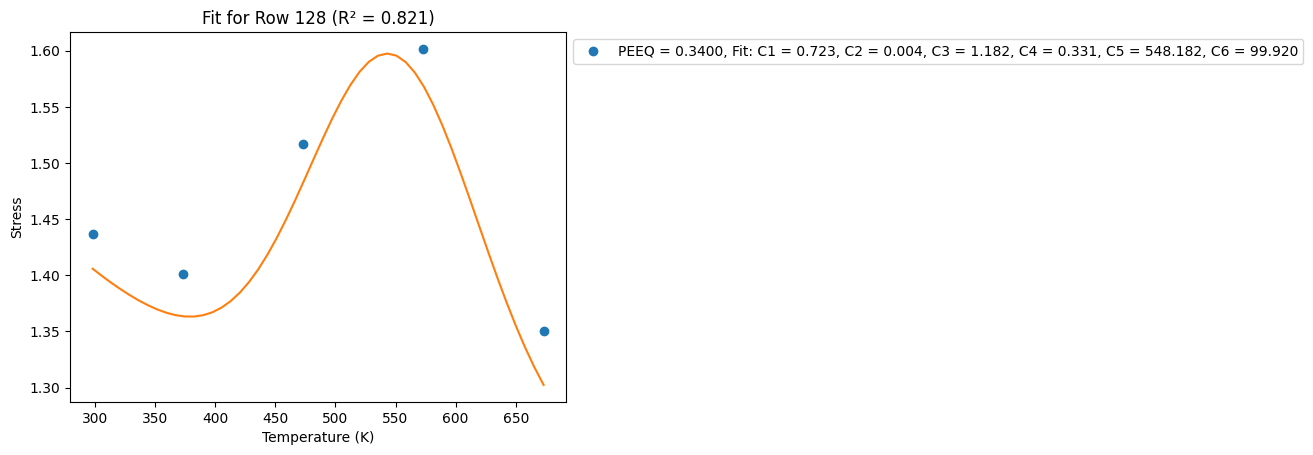

[1.43936002 1.40388622 1.521488   1.60819766 1.35496527]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


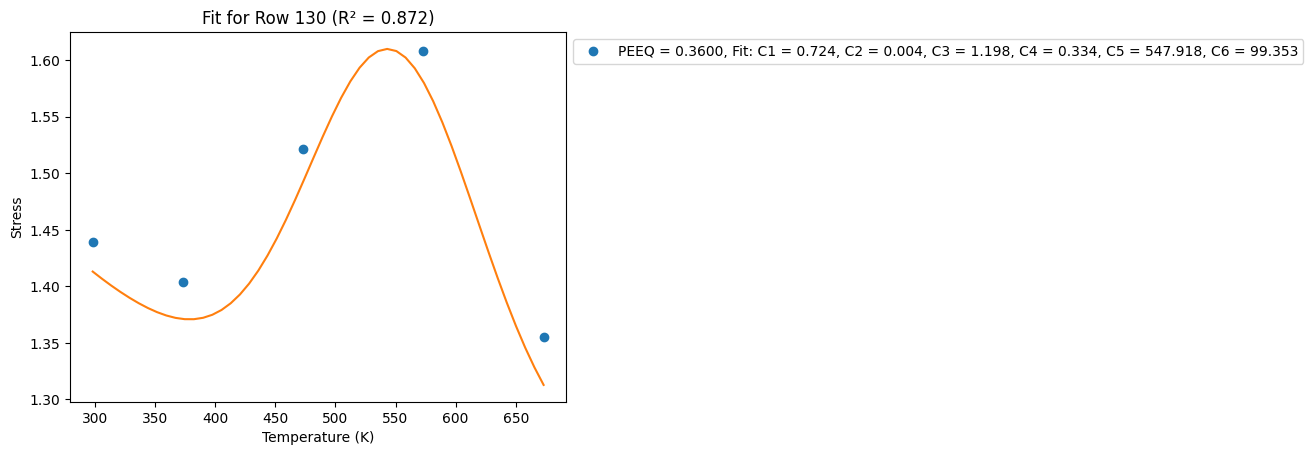

[1.44155144 1.40612692 1.52556299 1.61448511 1.35926962]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


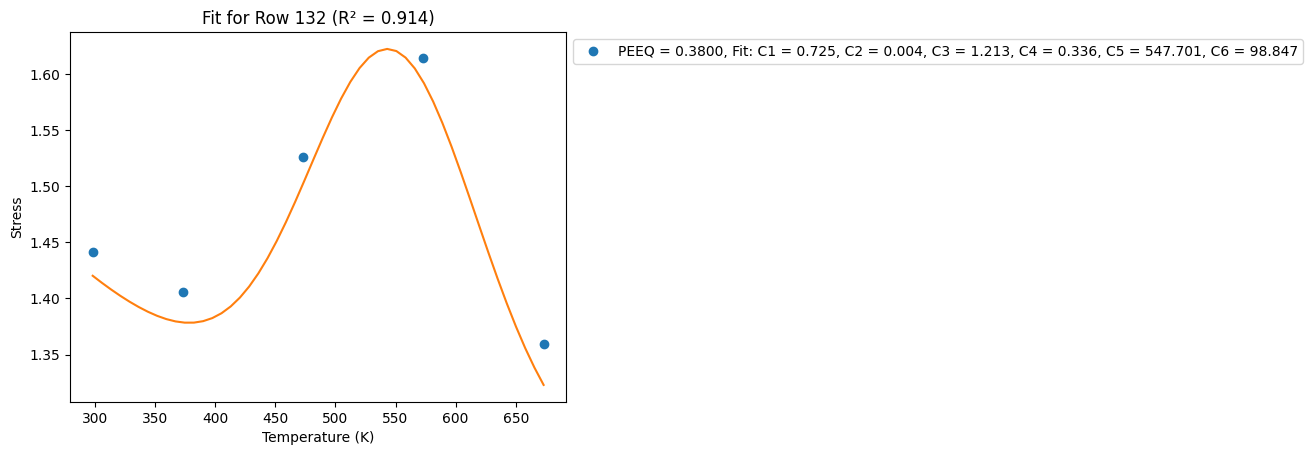

[1.44360489 1.40822987 1.52939983 1.62043667 1.36334737]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


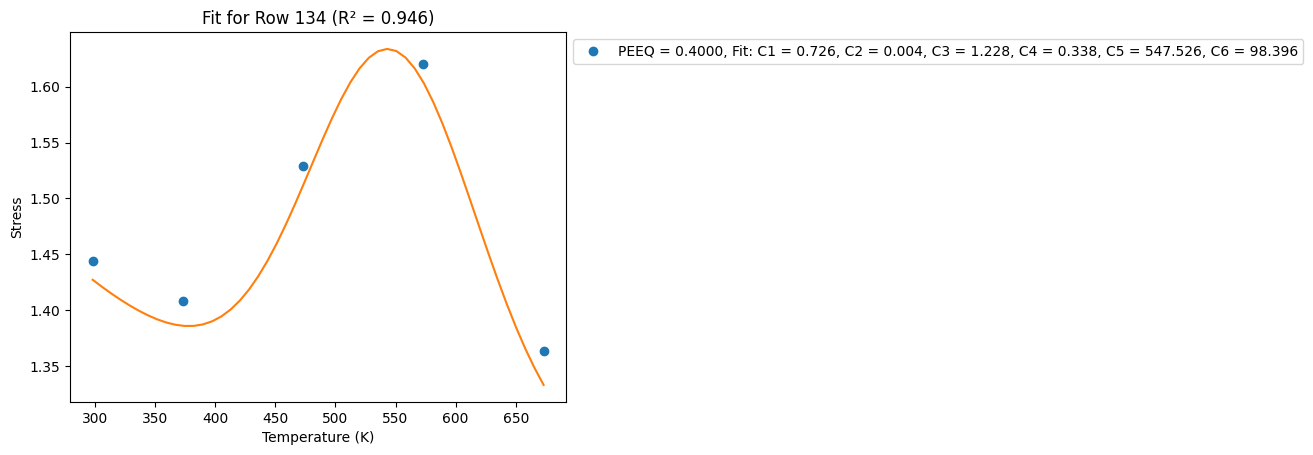

[1.44553549 1.41020999 1.5330236  1.62608618 1.36722119]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


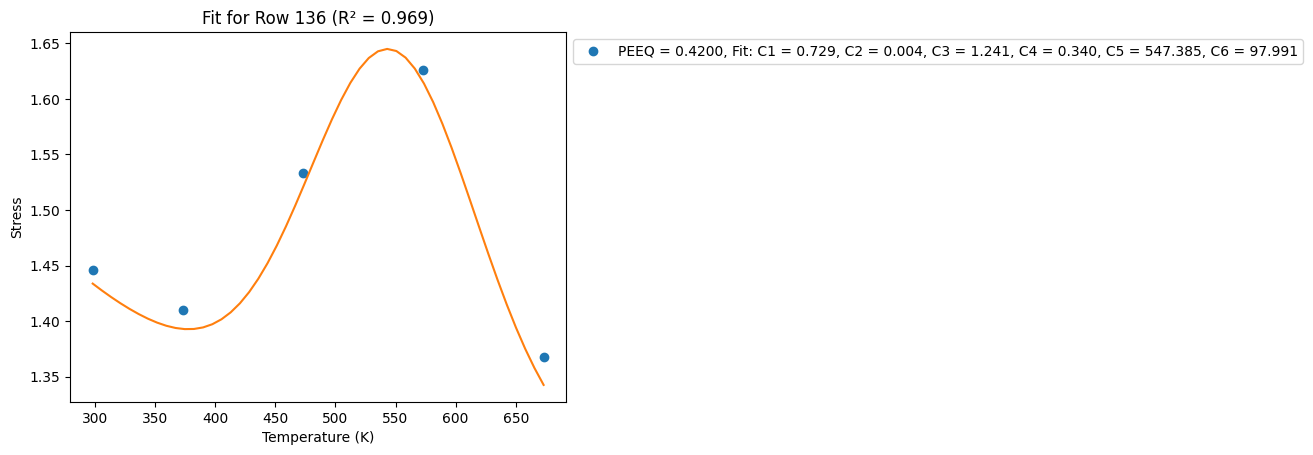

[1.44735607 1.41207992 1.53645567 1.63146262 1.3709105 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


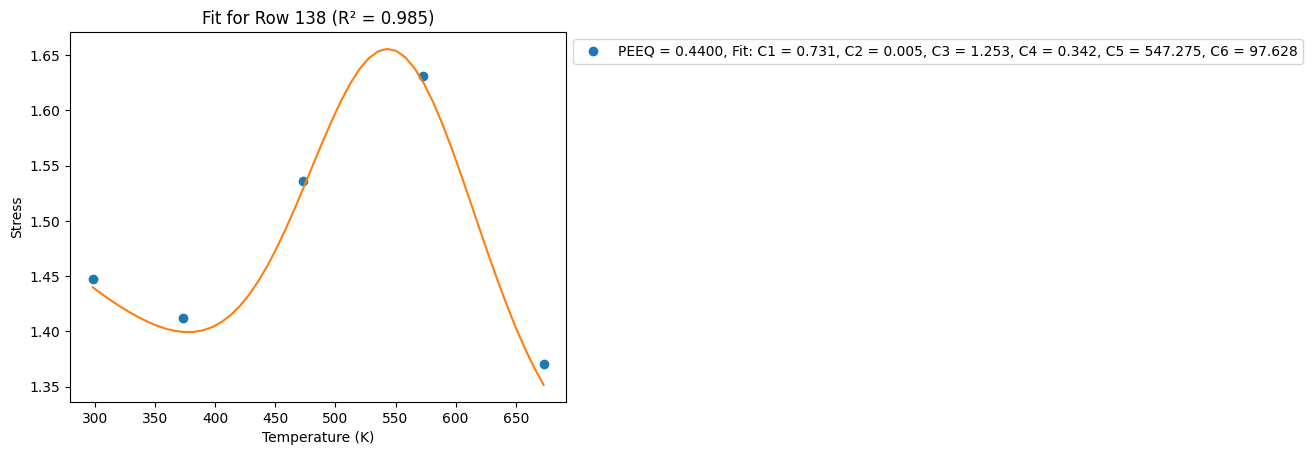

[1.44907759 1.41385053 1.53971442 1.636591   1.37443209]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


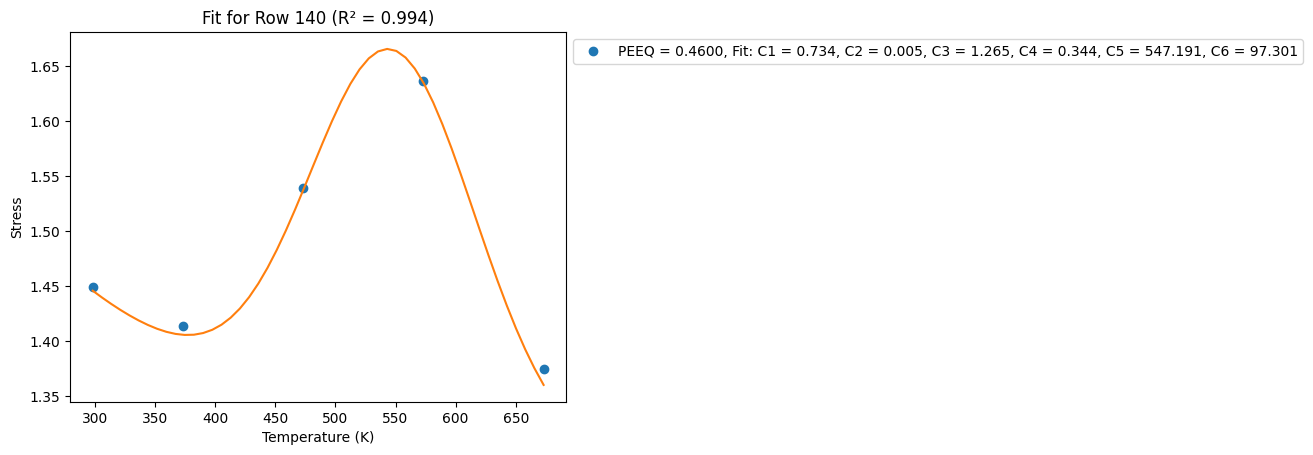

[1.45070951 1.41553116 1.54281572 1.64149305 1.37780055]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


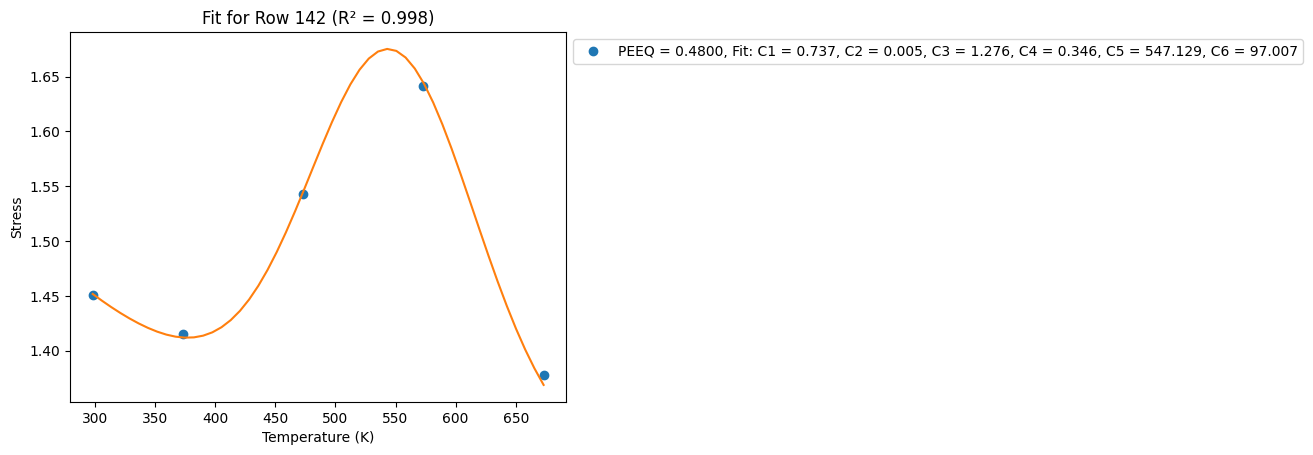

[1.45226    1.41712993 1.54577341 1.64618776 1.38102864]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


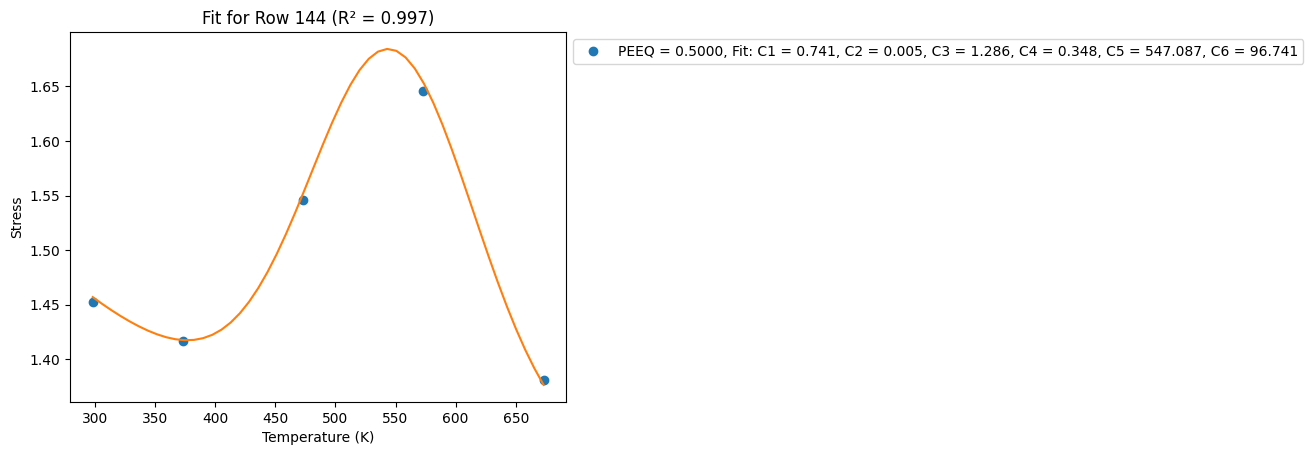

[1.45373623 1.41865393 1.5485996  1.65069184 1.38412759]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


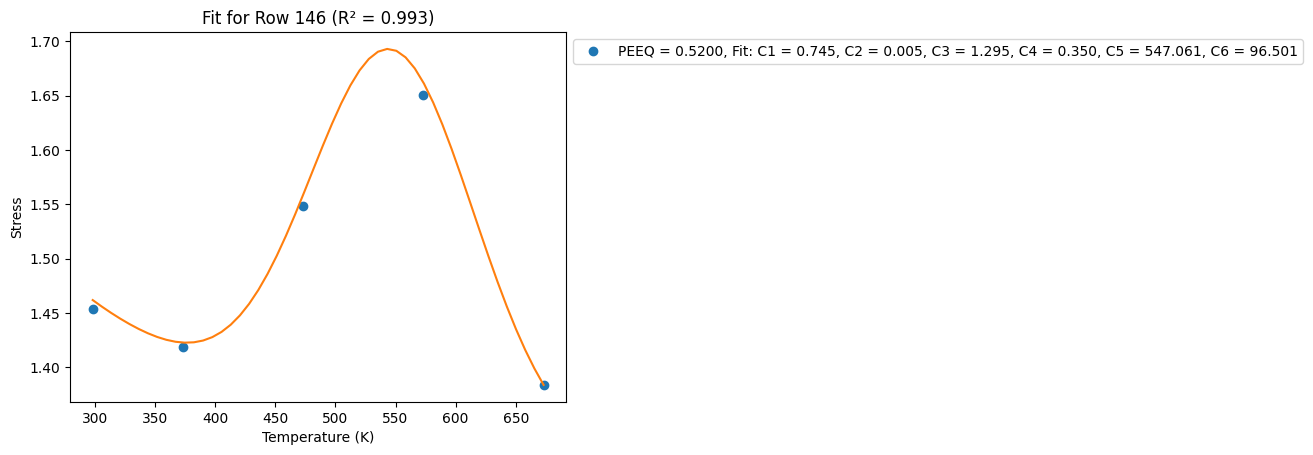

[1.45514444 1.4201094  1.55130494 1.65502007 1.38710734]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


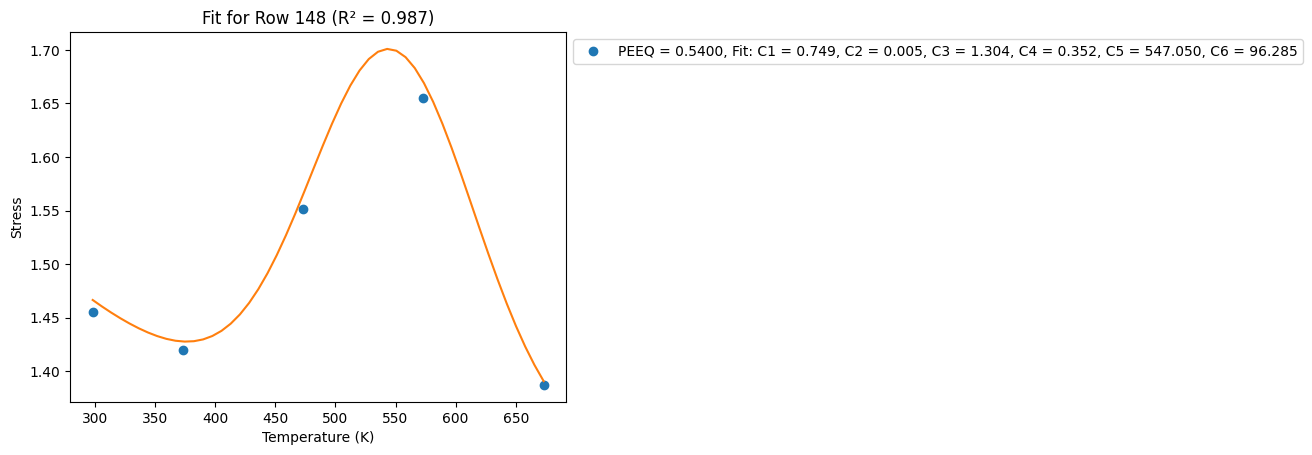

[1.45649019 1.42150183 1.55389889 1.65918557 1.38997673]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


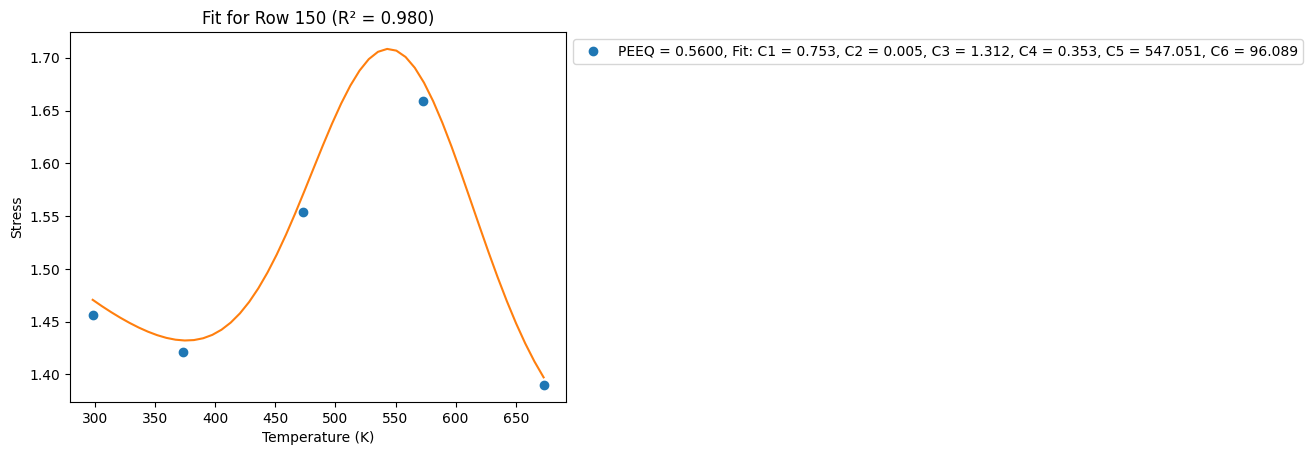

[1.45777835 1.4228361  1.55638983 1.66320005 1.39274364]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


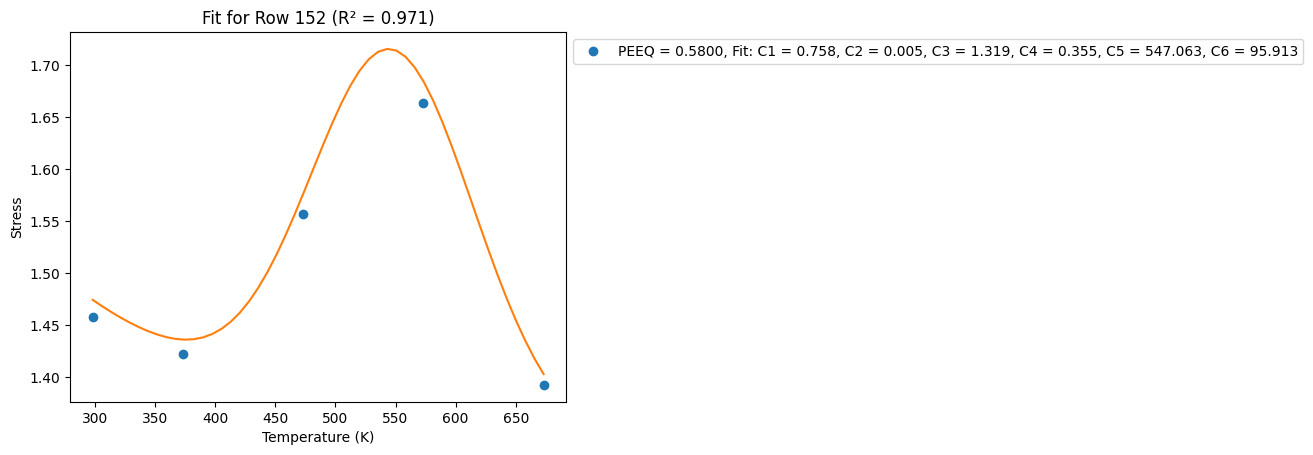

[1.45901329 1.42411656 1.55878524 1.667074   1.39541513]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


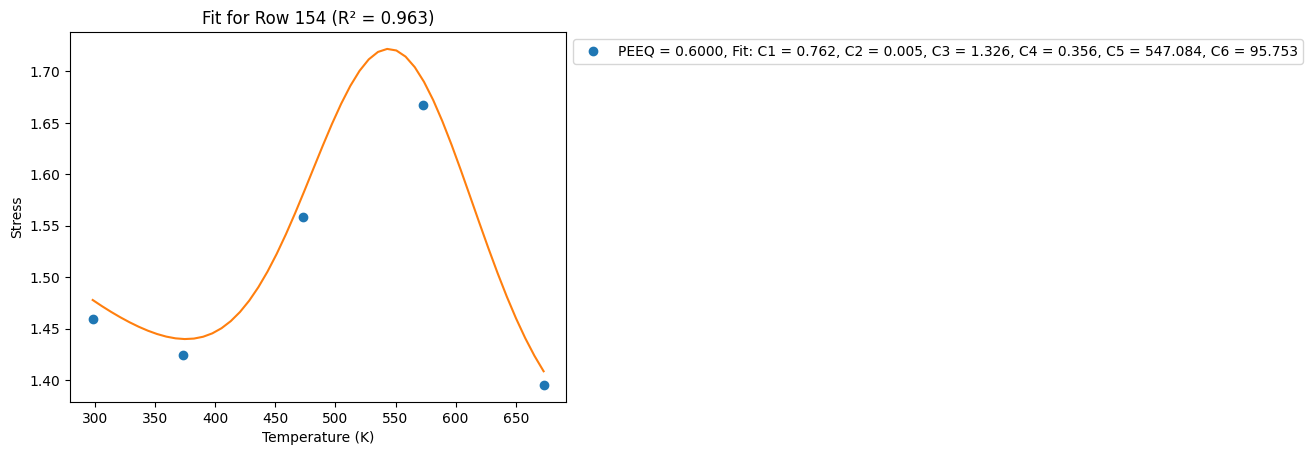

[1.4601989  1.42534709 1.56109186 1.67081685 1.39799757]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


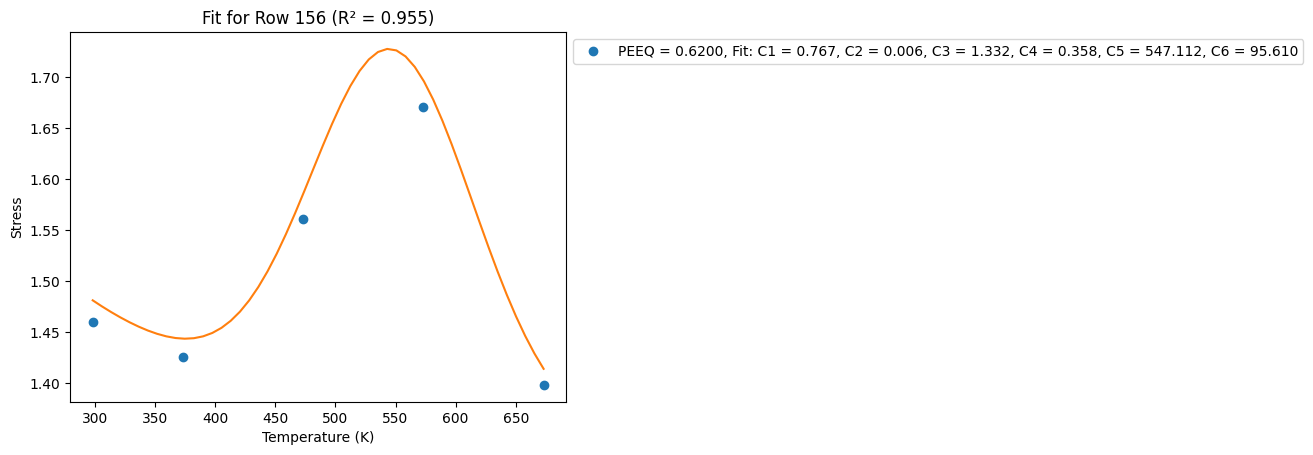

[1.46133868 1.42653119 1.56331572 1.67443714 1.40049671]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


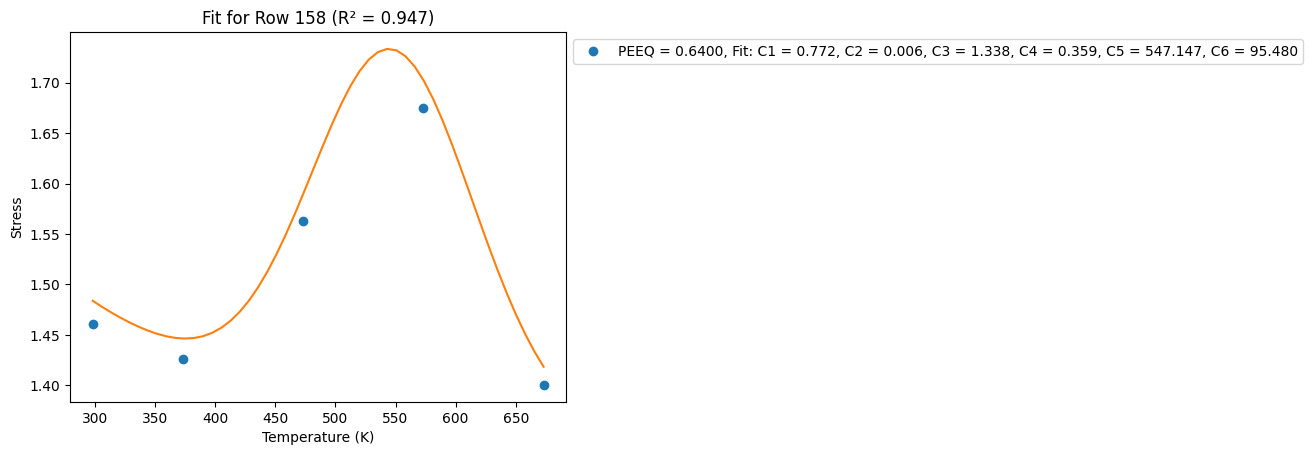

[1.46243577 1.427672   1.56546227 1.67794256 1.40291775]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


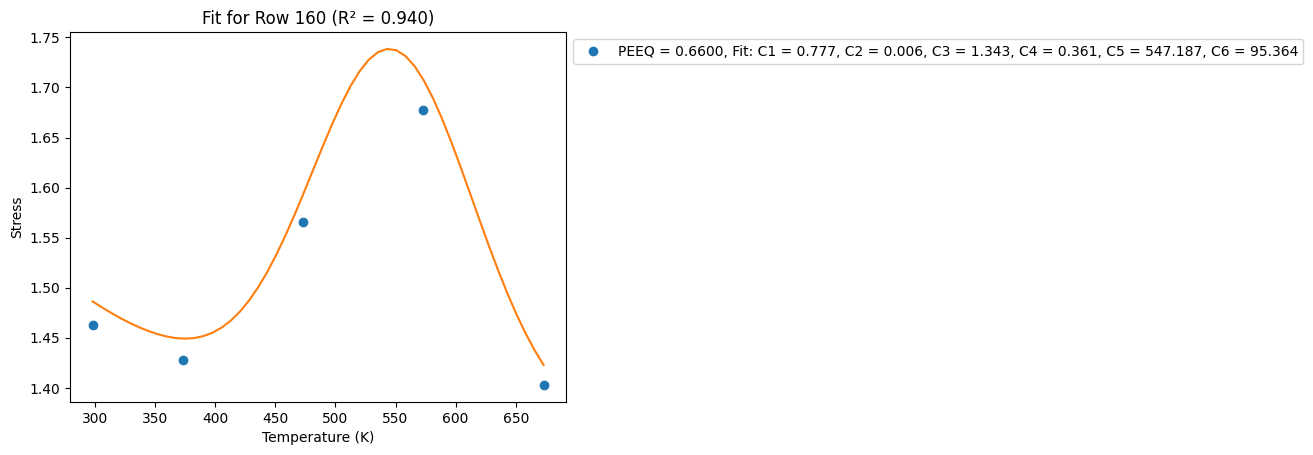

[1.46349302 1.42877236 1.56753647 1.68134015 1.40526542]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


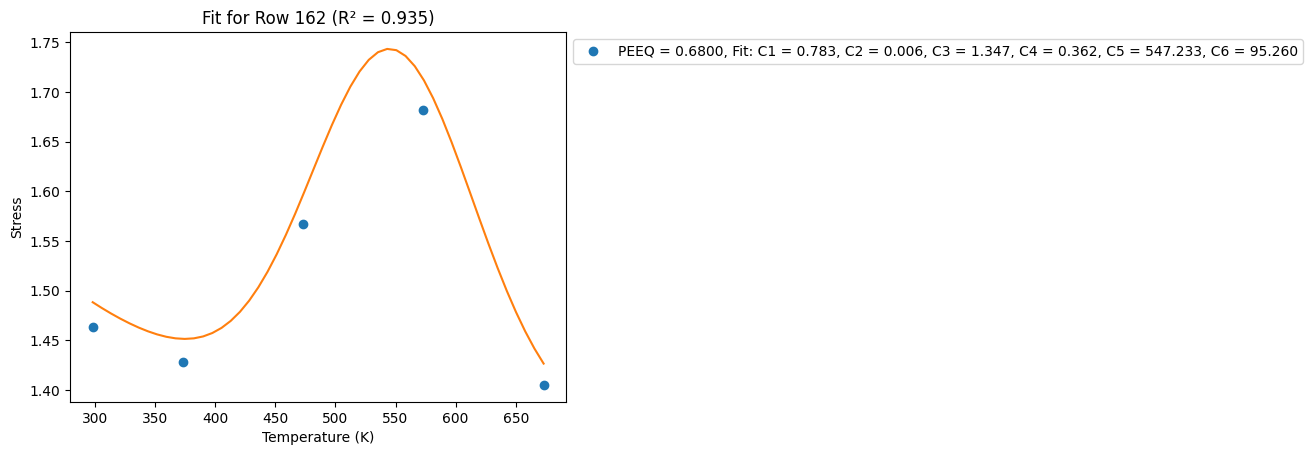

[1.46451298 1.42983485 1.5695428  1.68463628 1.40754405]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


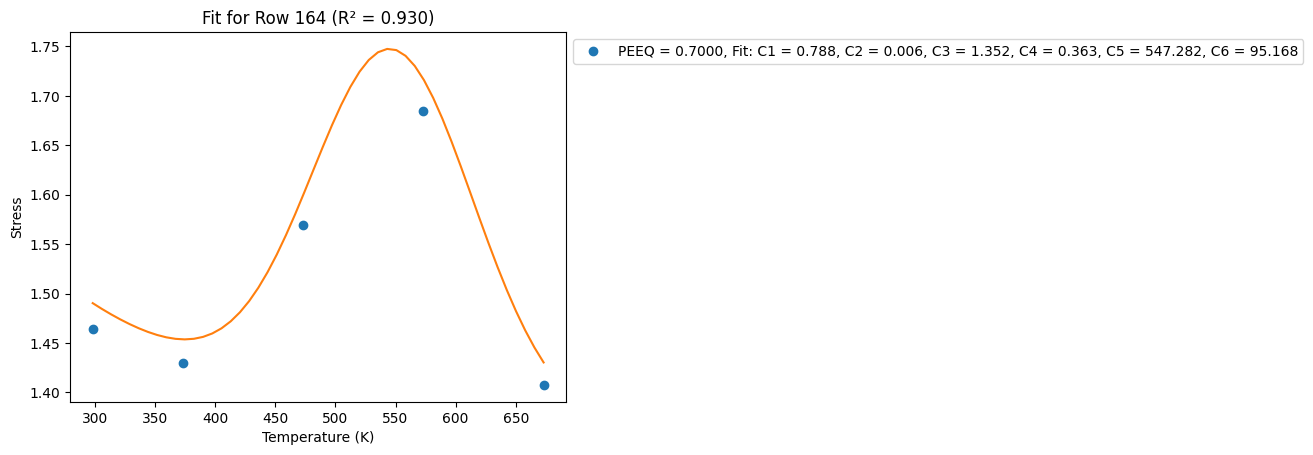

[1.46549802 1.43086182 1.57148535 1.6878368  1.40975758]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


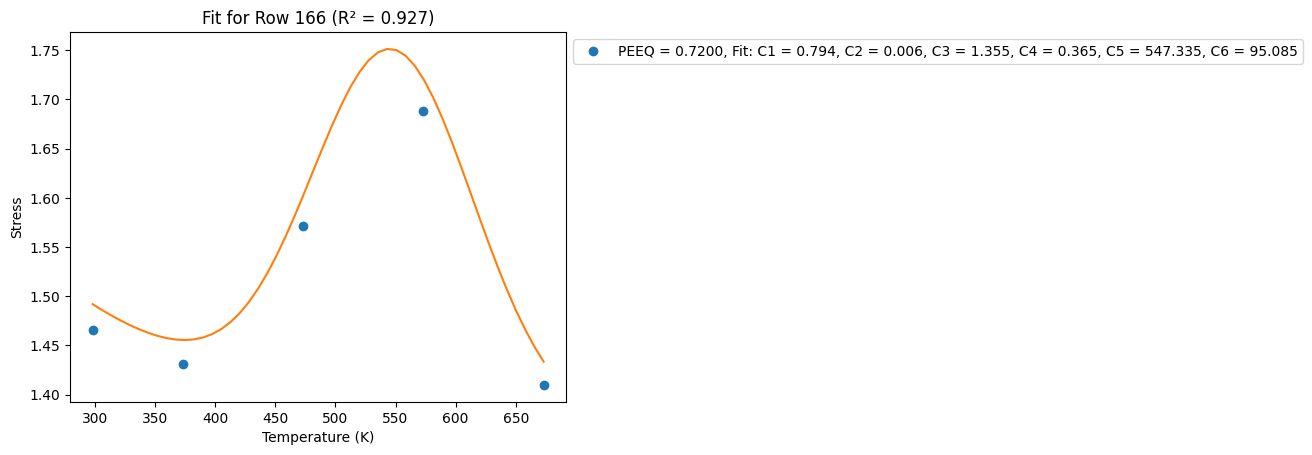

[1.46645024 1.43185541 1.57336786 1.69094707 1.41190962]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


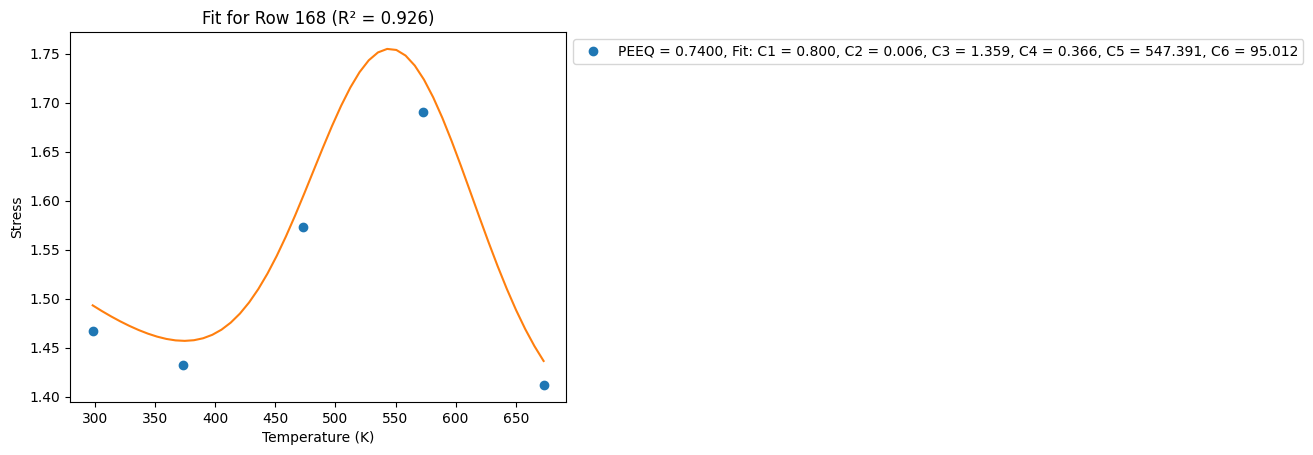

[1.46737162 1.43281756 1.57519375 1.69397198 1.4140035 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


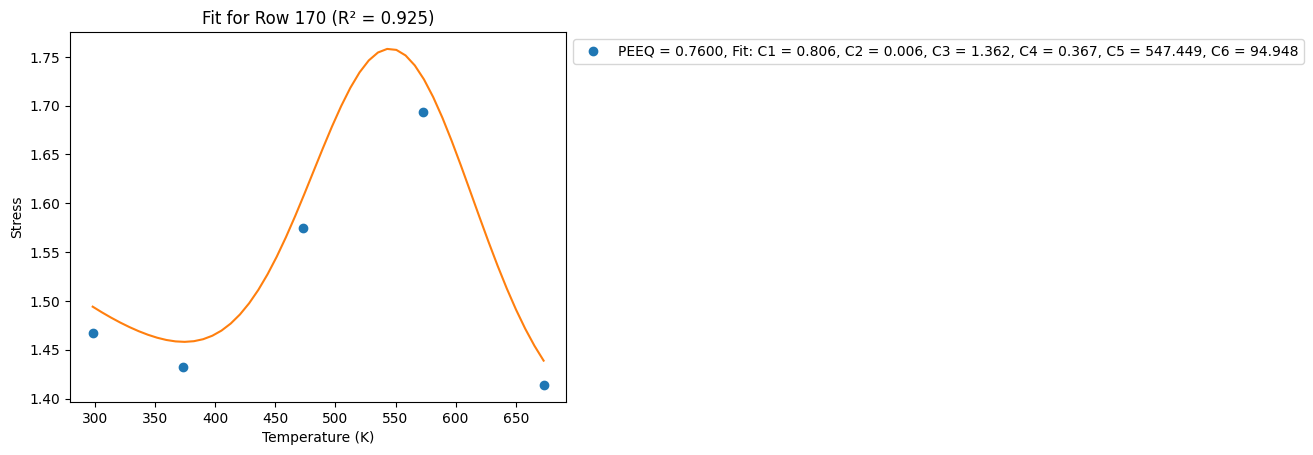

[1.46826391 1.43375009 1.57696618 1.69691608 1.41604229]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


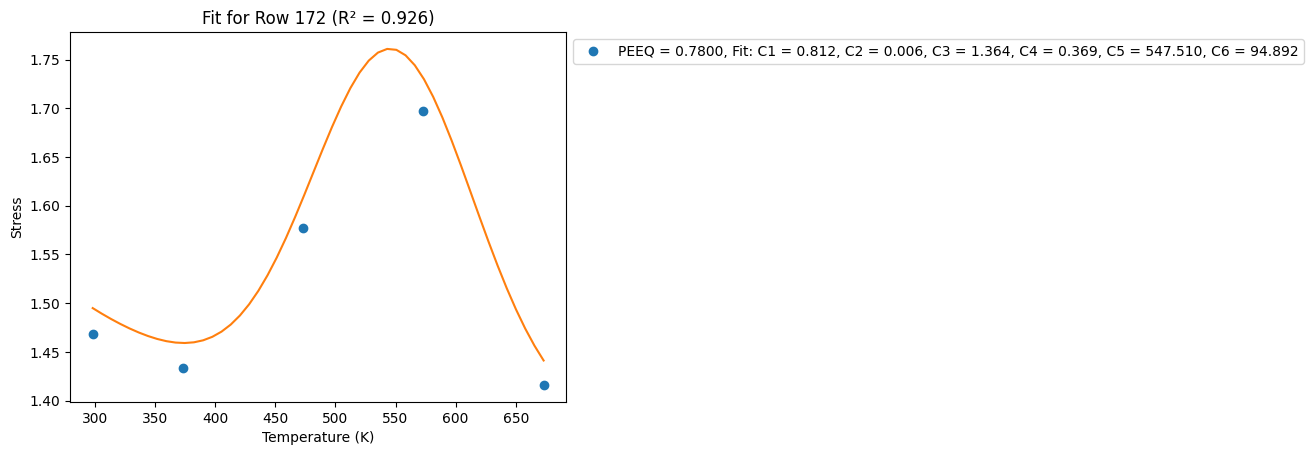

[1.46912878 1.43465463 1.57868803 1.69978353 1.4180288 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


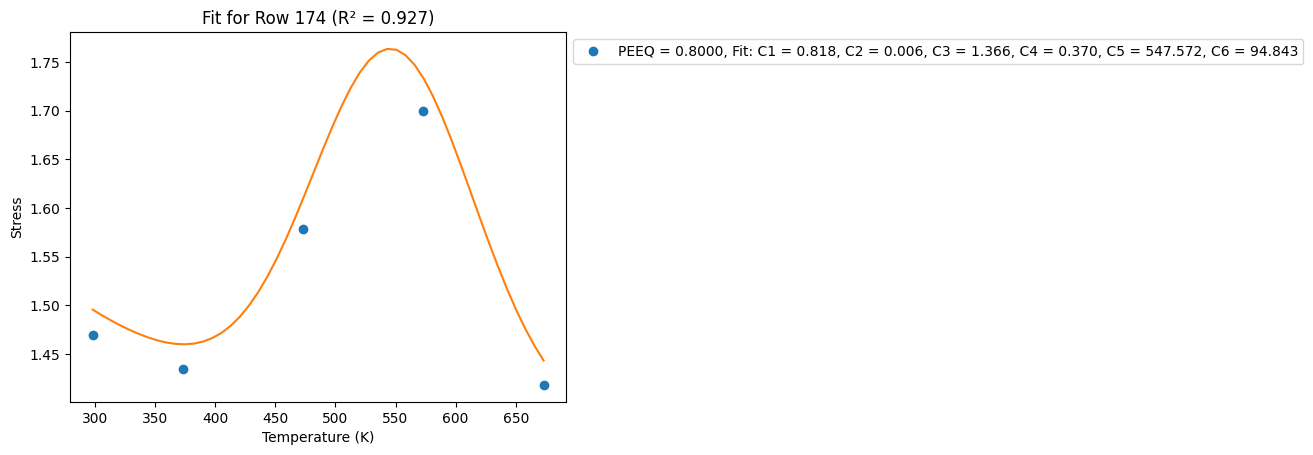

[1.46996771 1.4355327  1.58036197 1.7025782  1.41996565]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


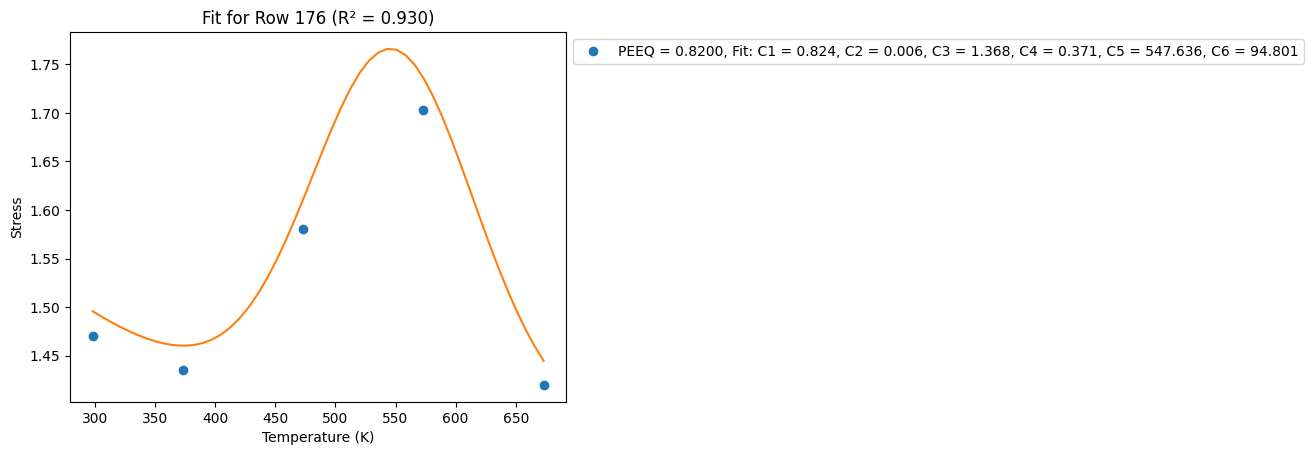

[1.4707821  1.4363857  1.58199047 1.70530367 1.42185526]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


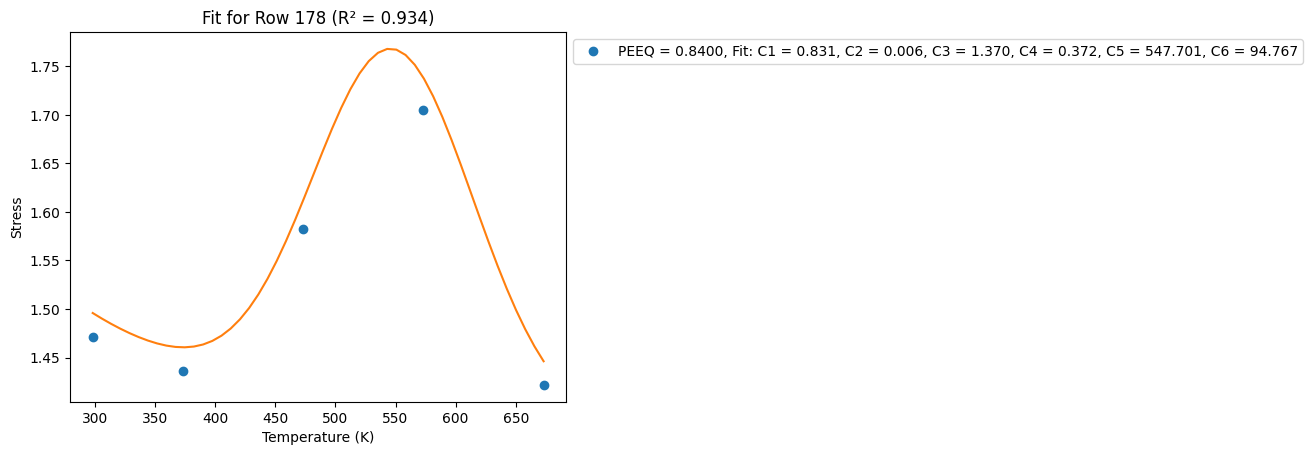

[1.47157324 1.43721493 1.58357582 1.70796324 1.42369988]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


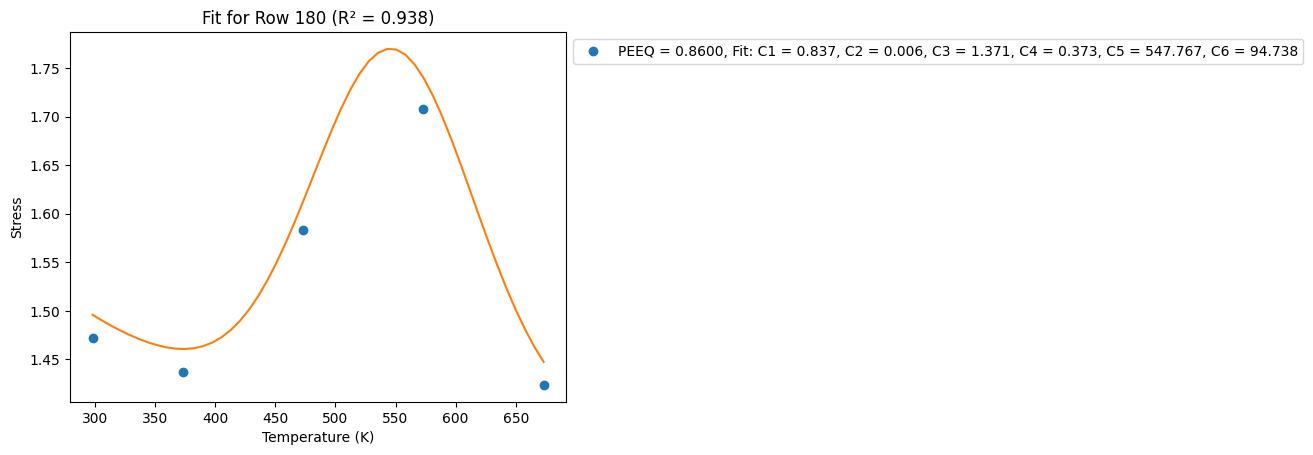

[1.47234231 1.43802158 1.58512013 1.71056002 1.42550161]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


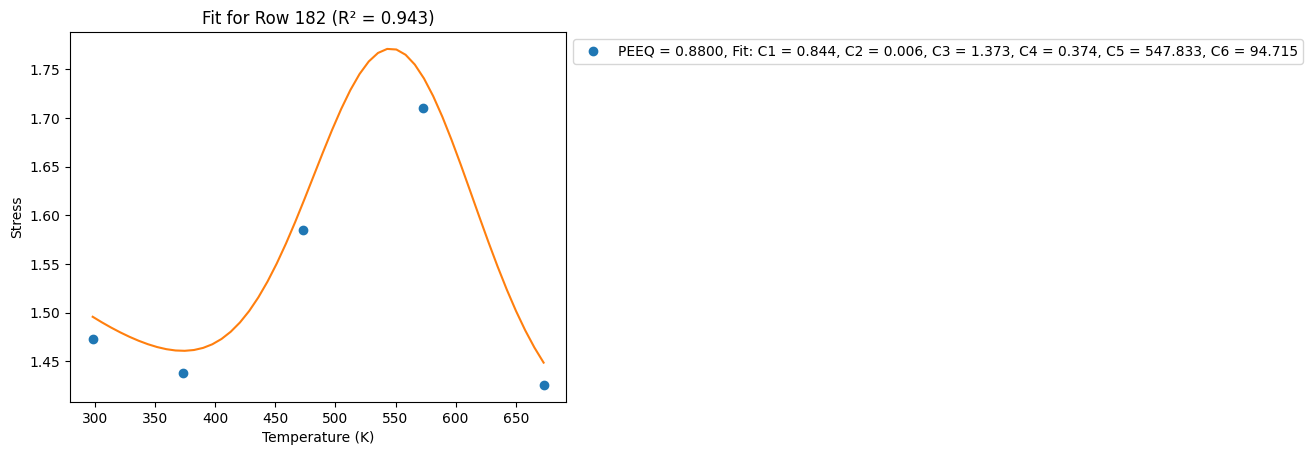

[1.47309042 1.43880677 1.58662536 1.71309688 1.4272624 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


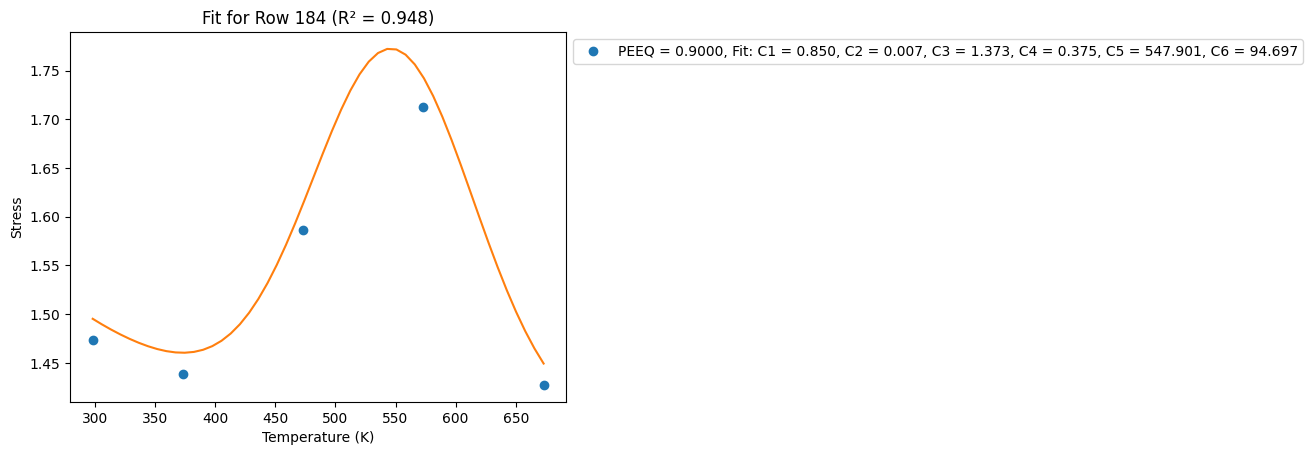

[1.47381858 1.43957153 1.58809337 1.71557649 1.42898406]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


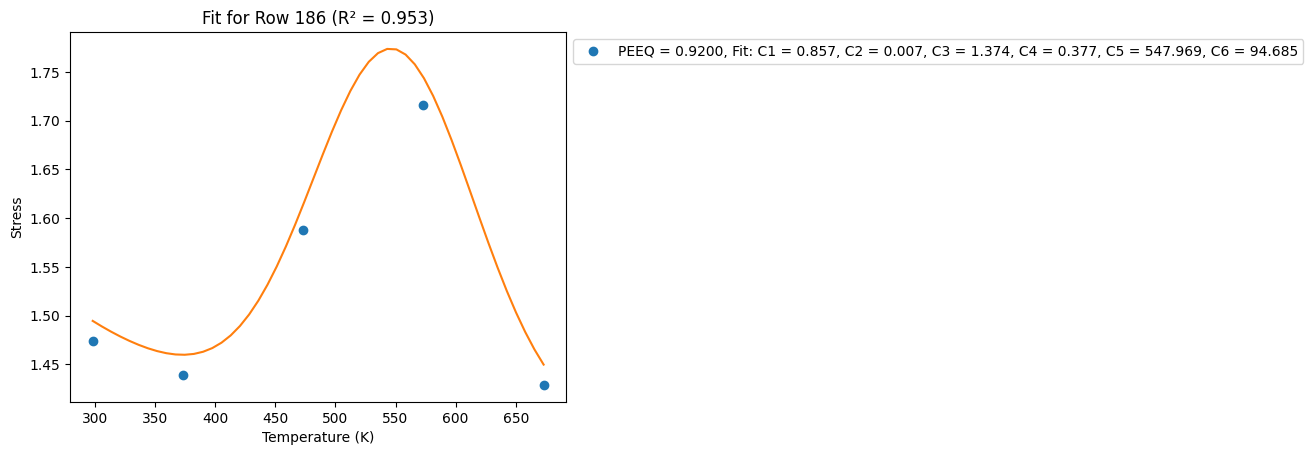

[1.47452776 1.44031682 1.58952584 1.71800138 1.43066829]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


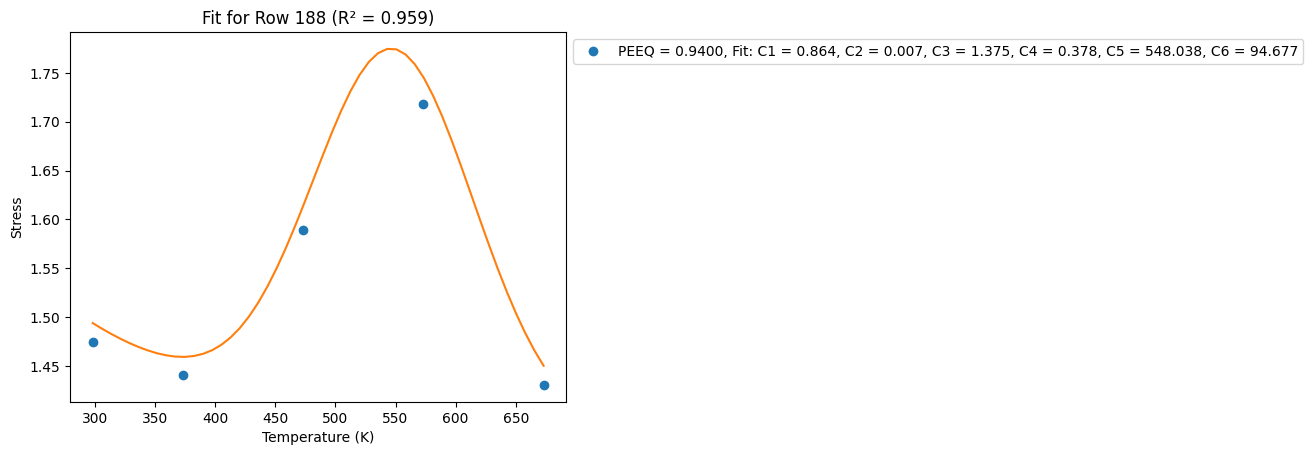

[1.47521883 1.44104355 1.59092439 1.72037387 1.43231669]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


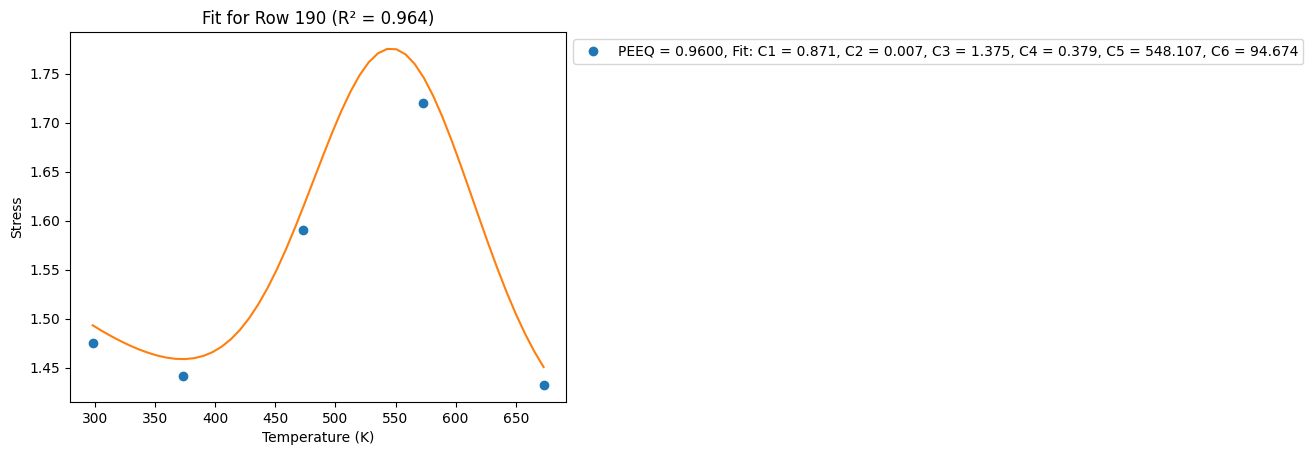

[1.47589263 1.44175255 1.59229049 1.72269619 1.43393076]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


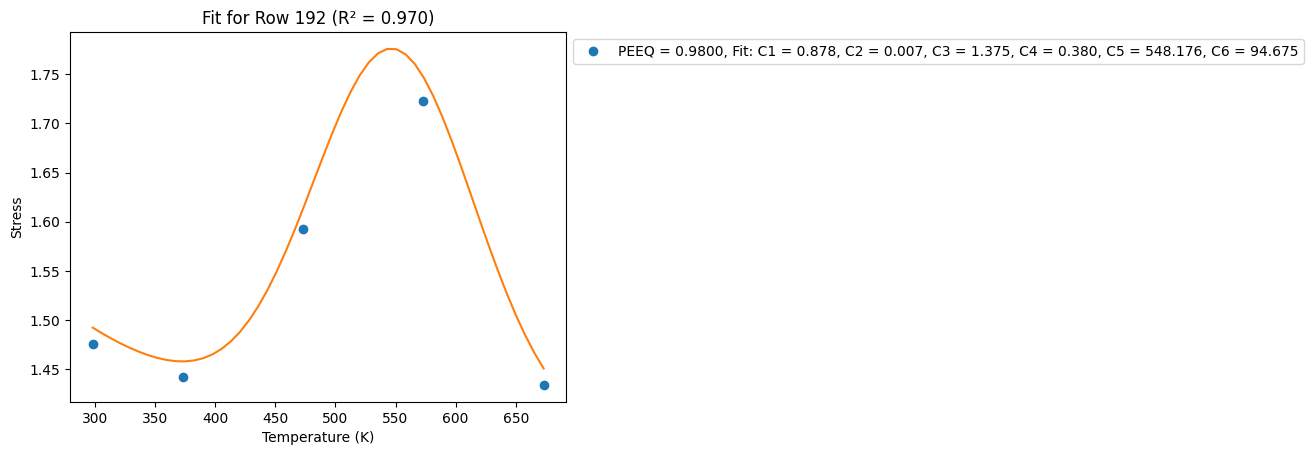

[1.47654994 1.44244461 1.59362556 1.72497037 1.43551189]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


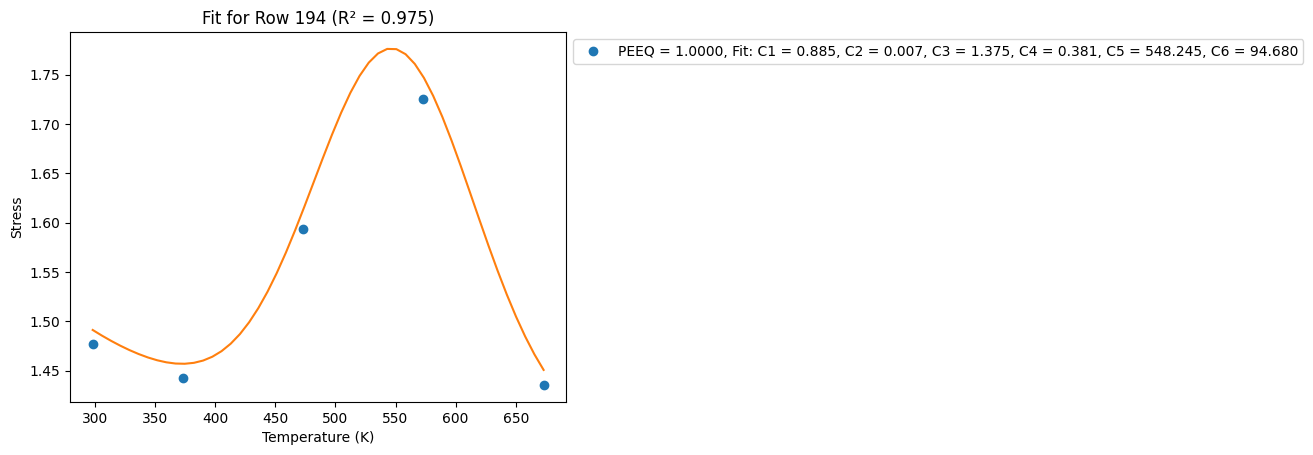

[1.47719147 1.44312046 1.5949309  1.72719838 1.43706139]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


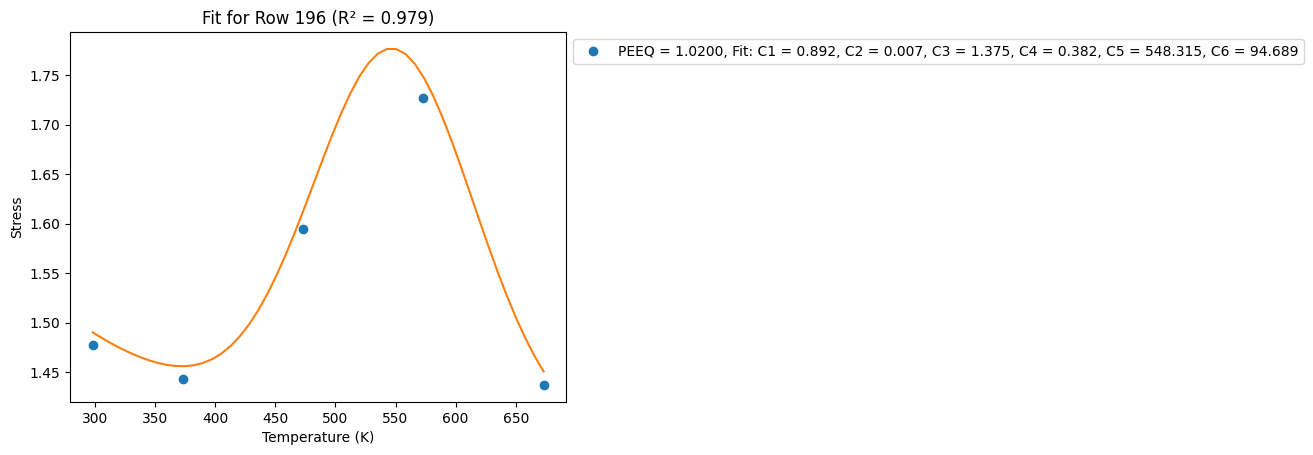

[1.47781791 1.4437808  1.59620774 1.72938202 1.43858052]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


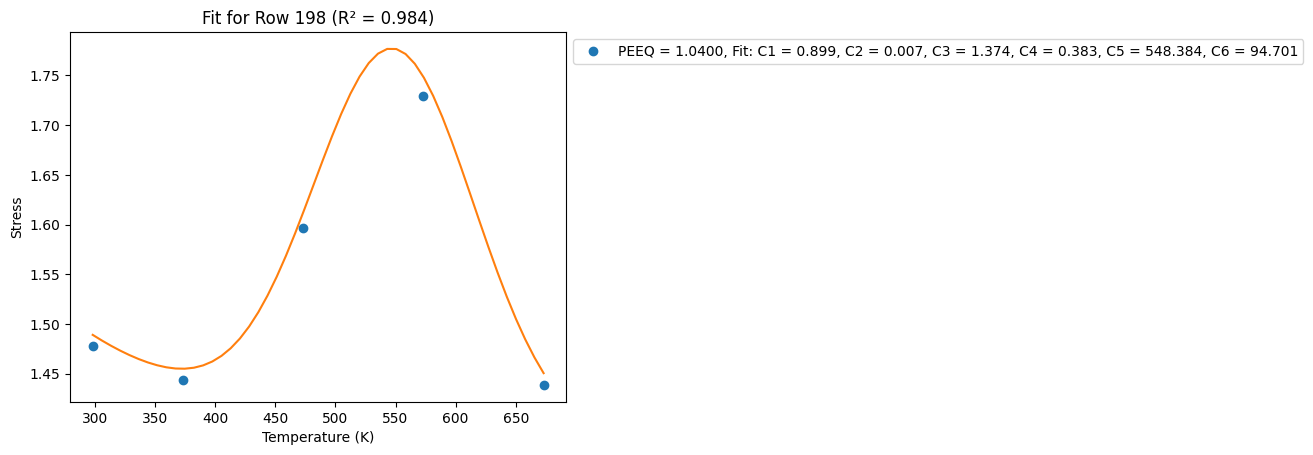

[1.47842989 1.44442626 1.59745724 1.73152303 1.44007044]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


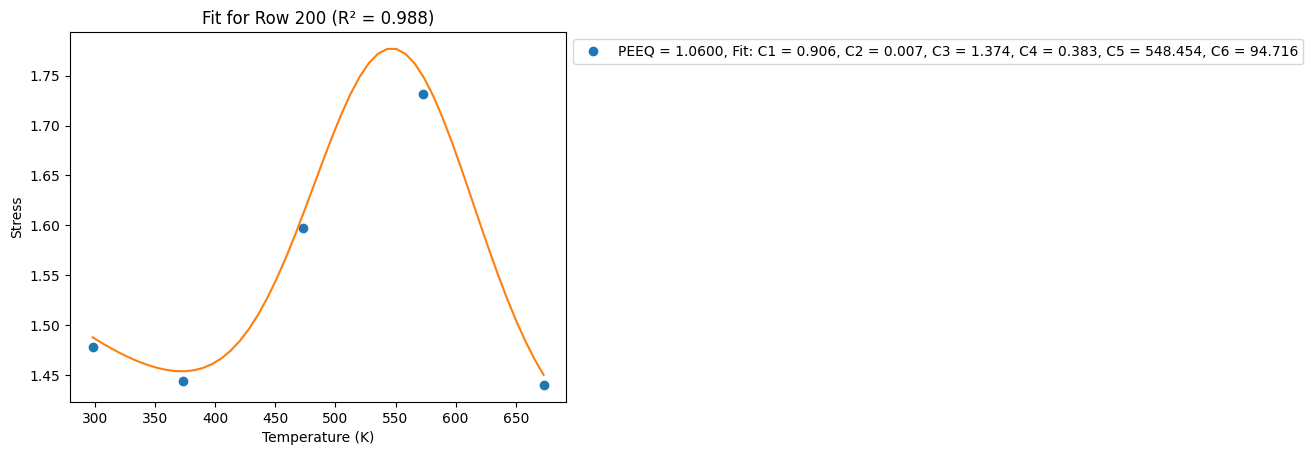

[1.47902802 1.44505746 1.59868048 1.73362301 1.44153225]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


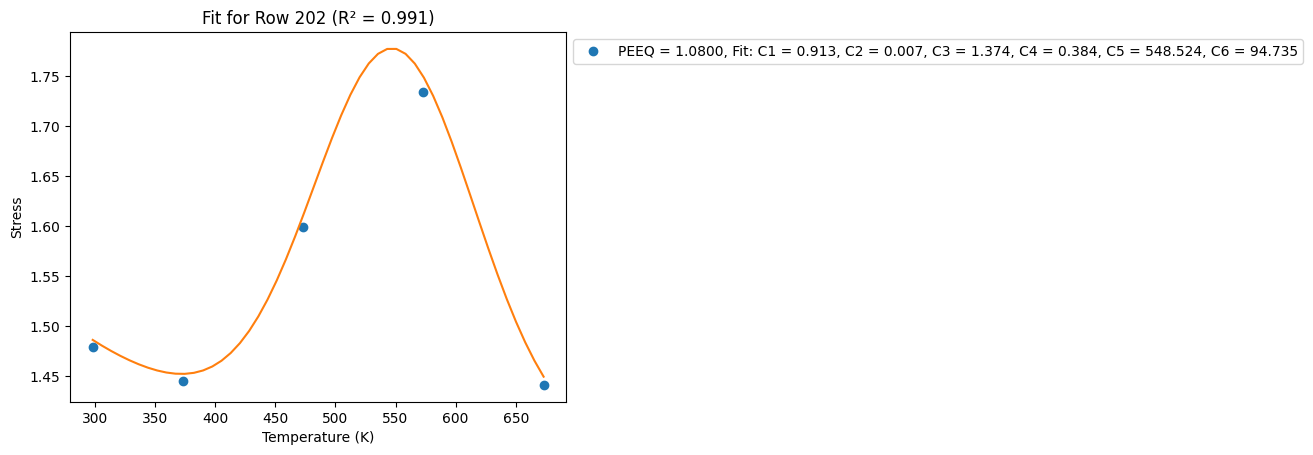

[1.47961286 1.44567497 1.5998785  1.73568351 1.44296699]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


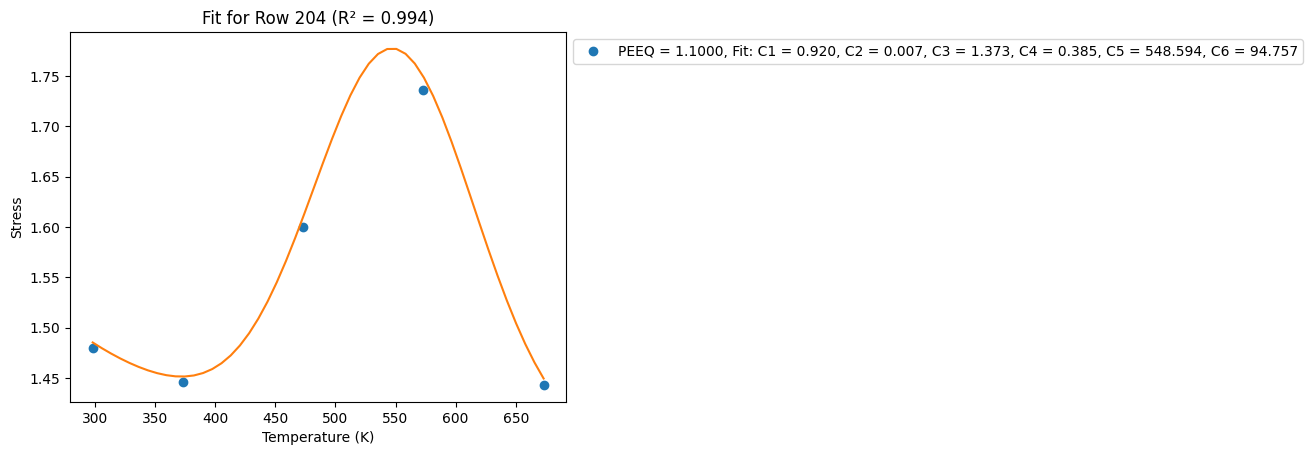

[1.48018494 1.44627933 1.60105227 1.73770597 1.44437565]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


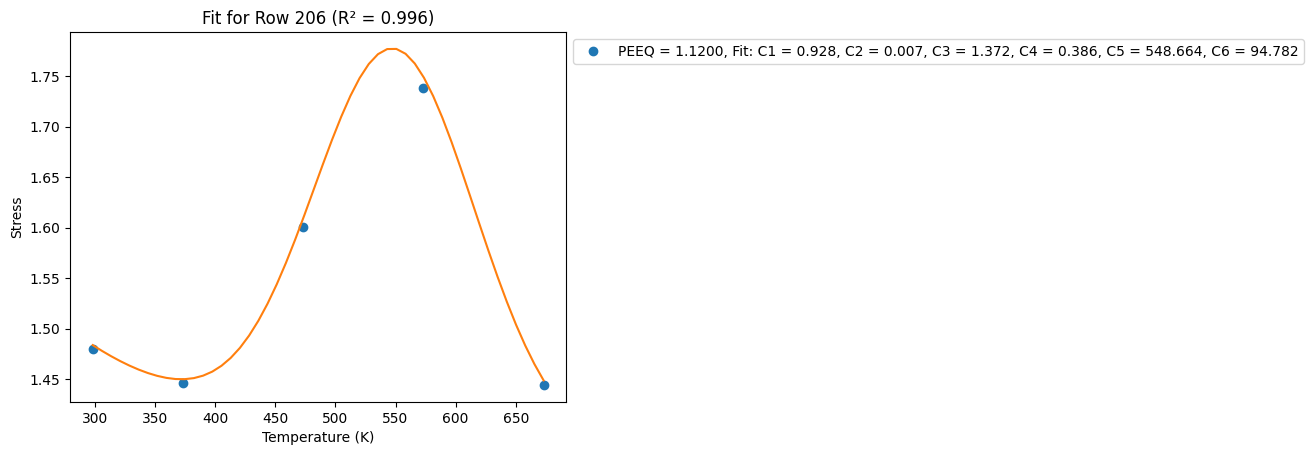

[1.48074476 1.44687105 1.60220269 1.73969176 1.44575915]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


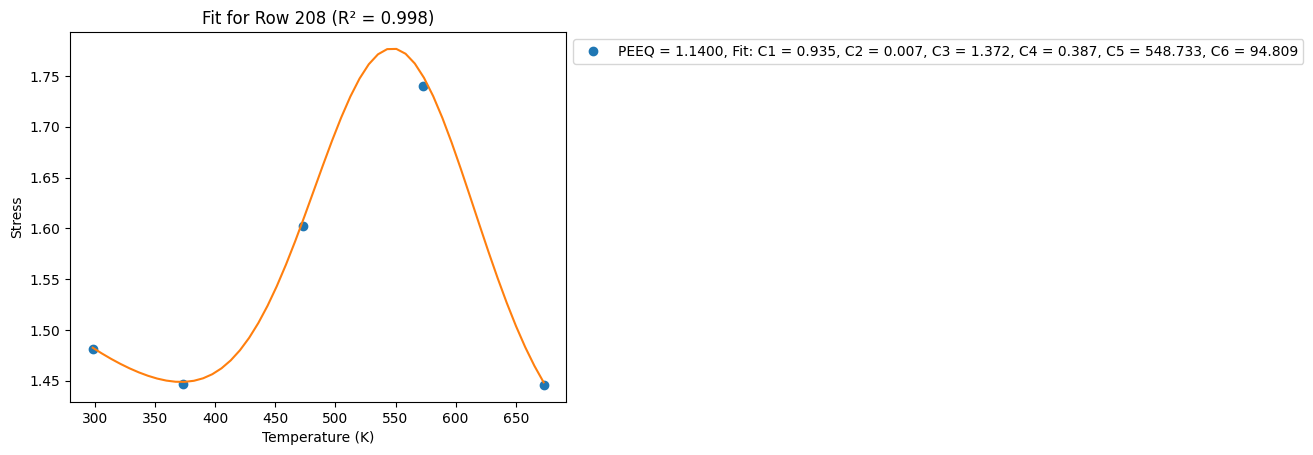

[1.48129279 1.44745062 1.60333064 1.74164217 1.44711839]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


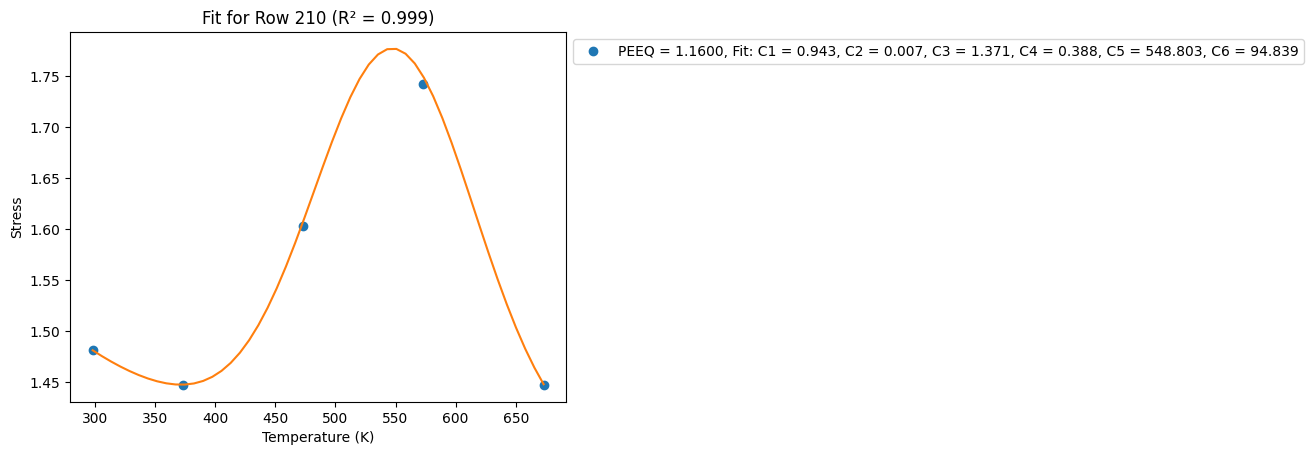

[1.48182948 1.44801848 1.60443693 1.74355843 1.44845419]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


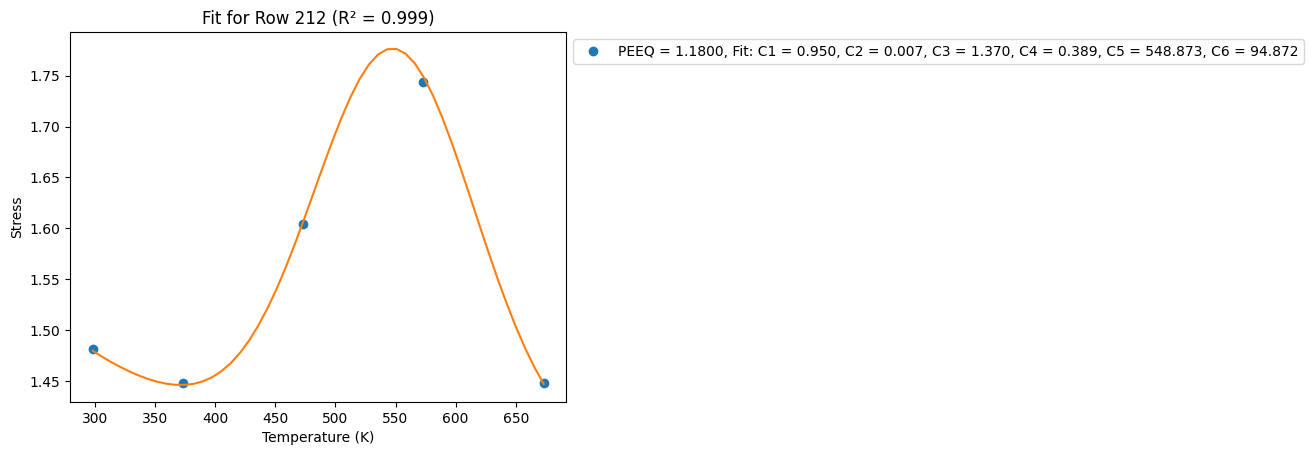

[1.48235526 1.44857506 1.60552233 1.74544171 1.44976735]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


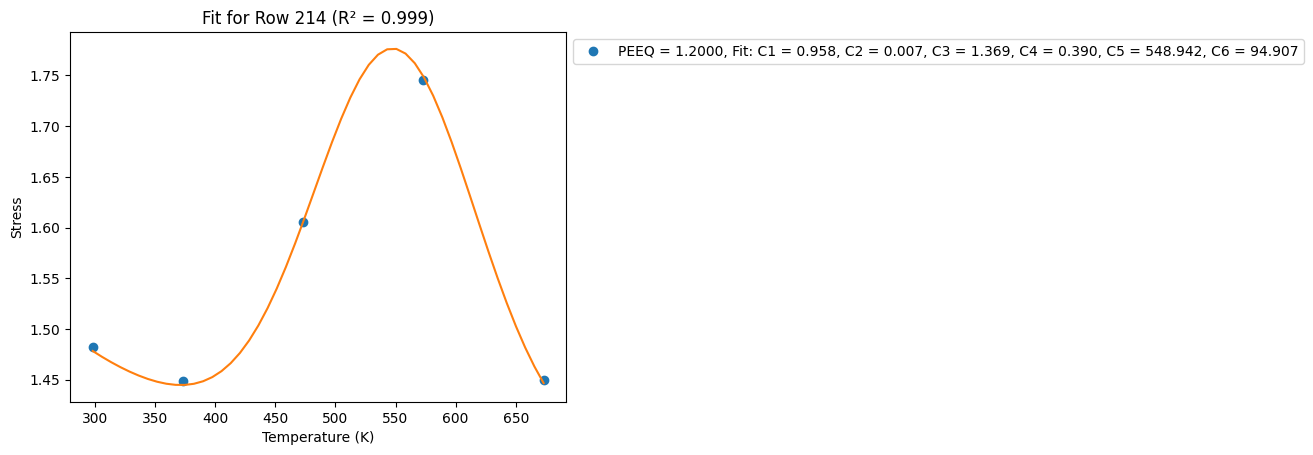

[1.48287052 1.44912078 1.60658759 1.74729312 1.45105864]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


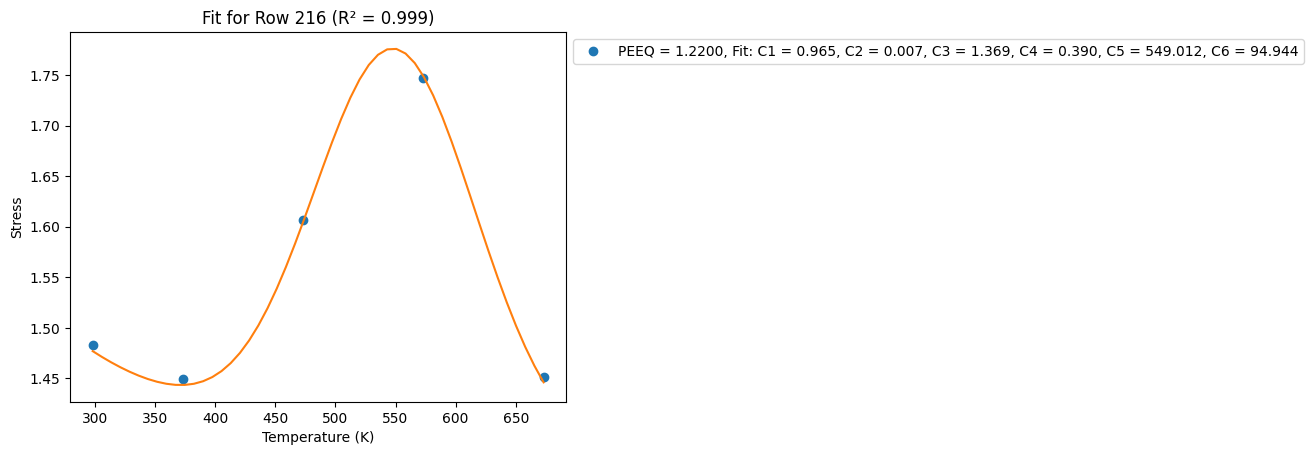

[1.48337564 1.44965603 1.6076334  1.74911371 1.45232875]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


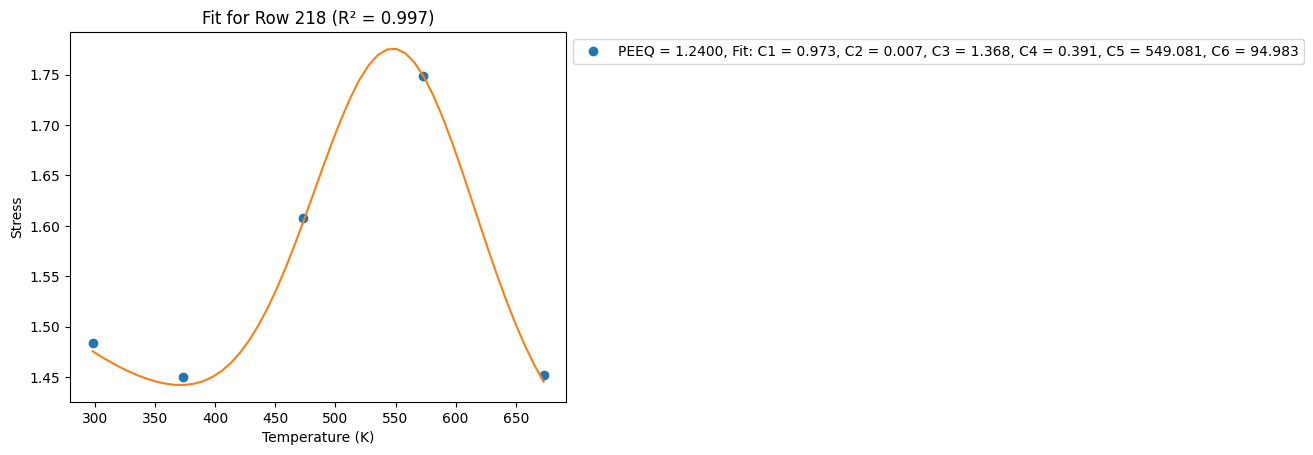

[1.48387098 1.45018116 1.60866042 1.75090448 1.45357838]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


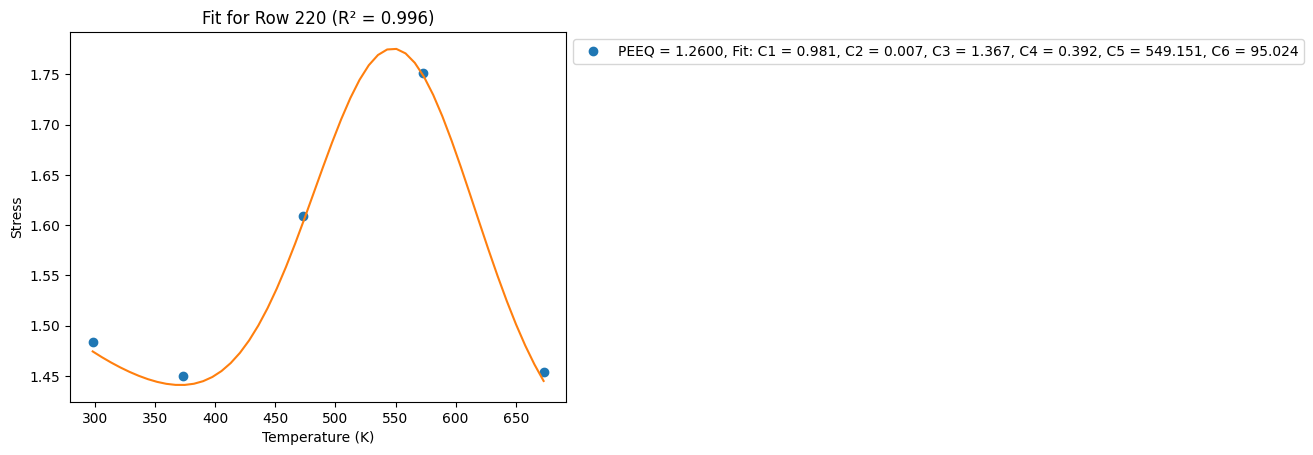

[1.48435689 1.45069652 1.60966929 1.75266639 1.45480818]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


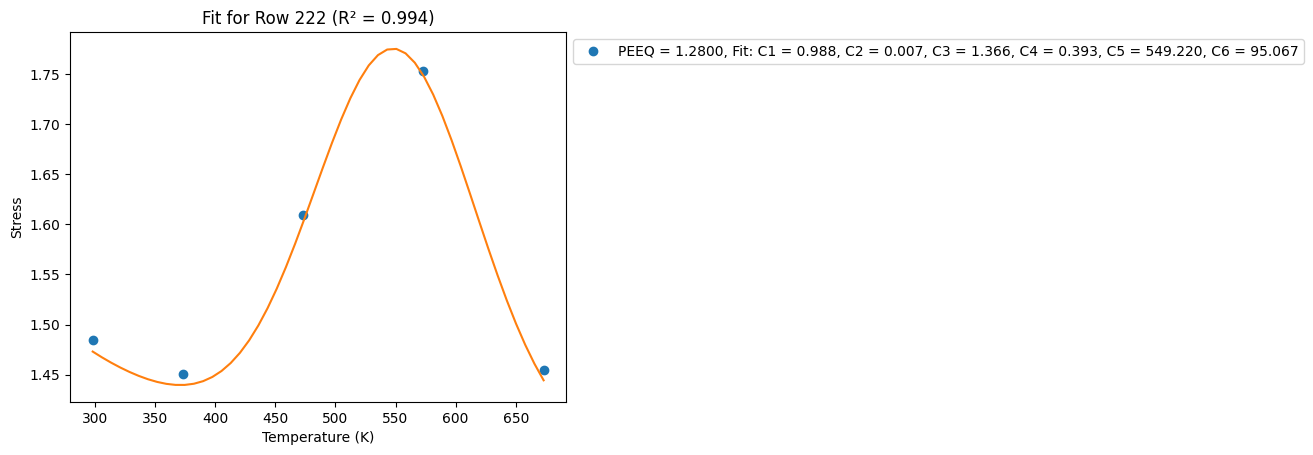

/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


[1.48483368 1.45120246 1.6106606  1.75440034 1.45601877]


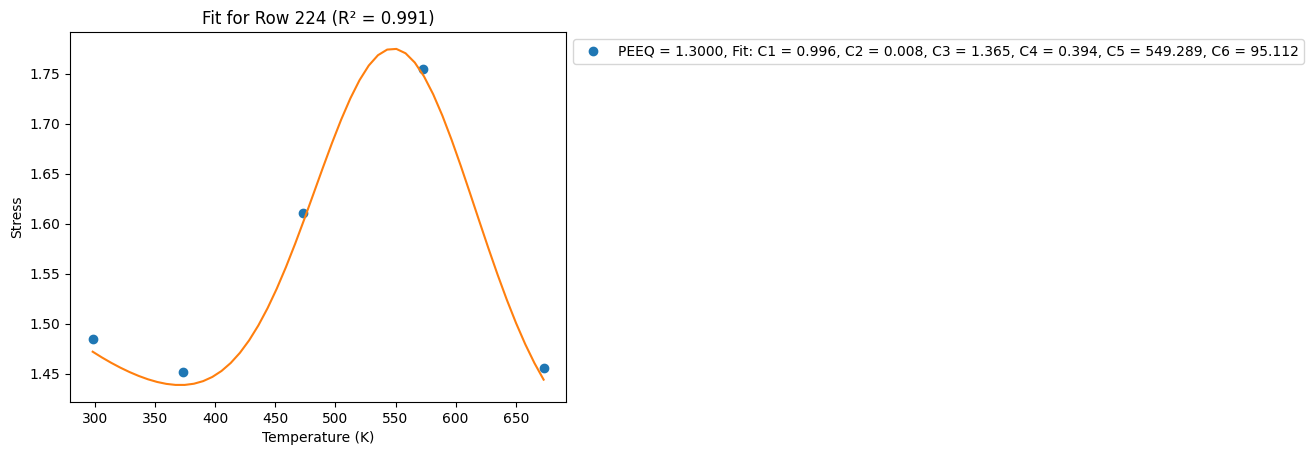

[1.48530167 1.45169927 1.61163492 1.7561072  1.45721073]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


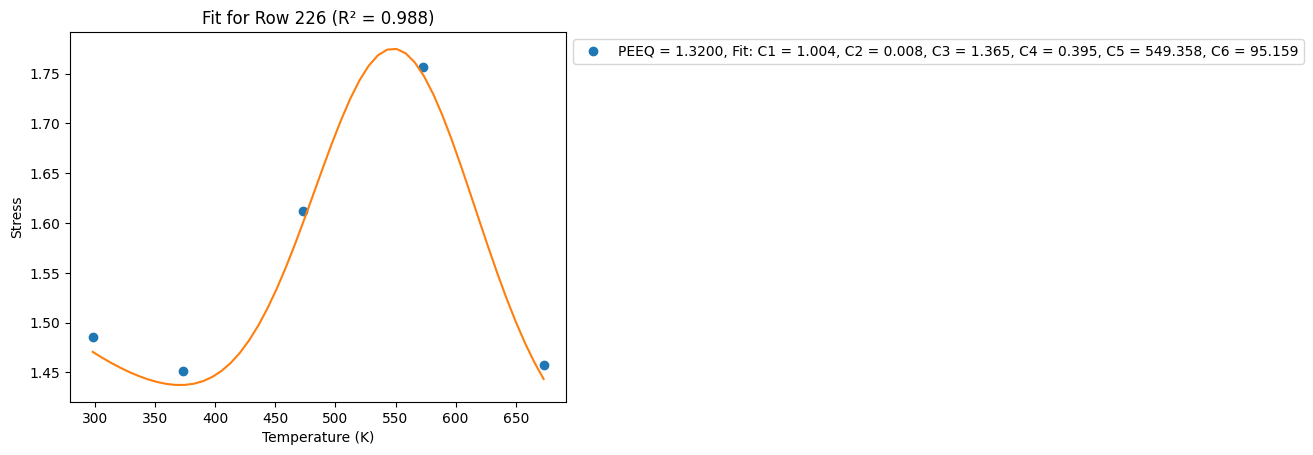

[1.48576115 1.45218727 1.61259279 1.7577878  1.45838463]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


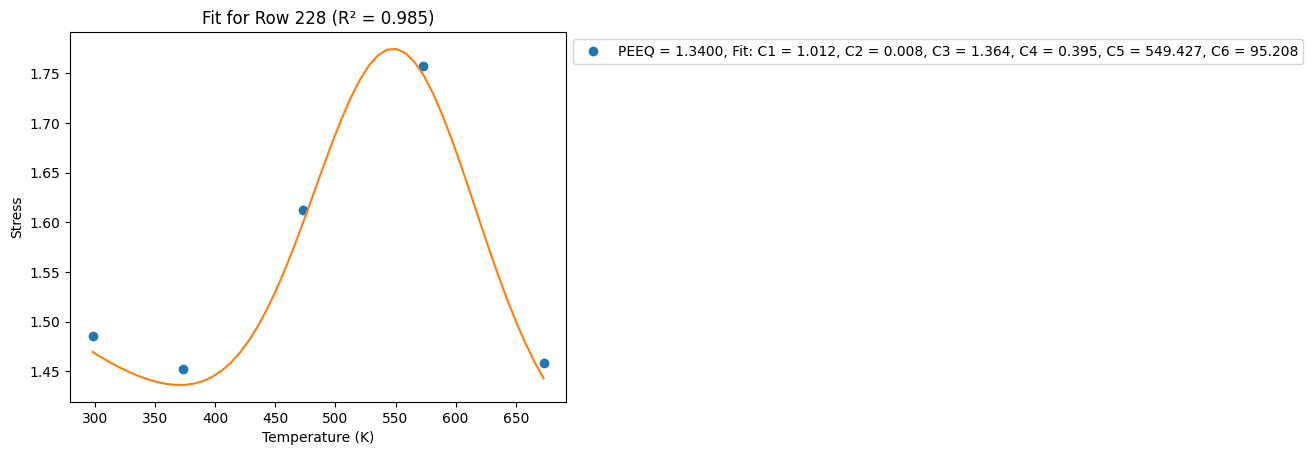

[1.48621239 1.45266674 1.61353474 1.75944293 1.45954102]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


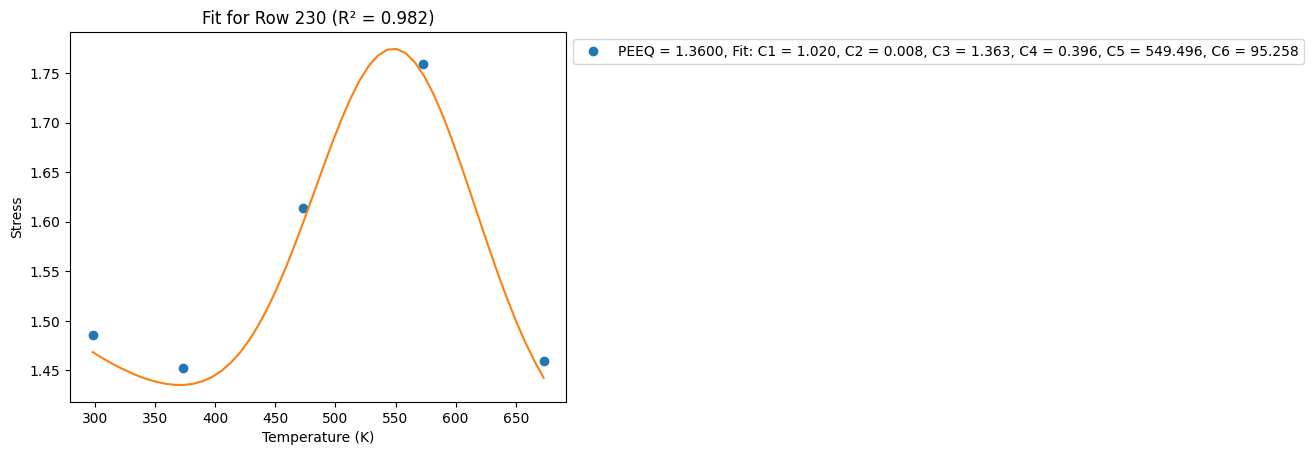

[1.48665567 1.45313794 1.61446126 1.76107334 1.4606804 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


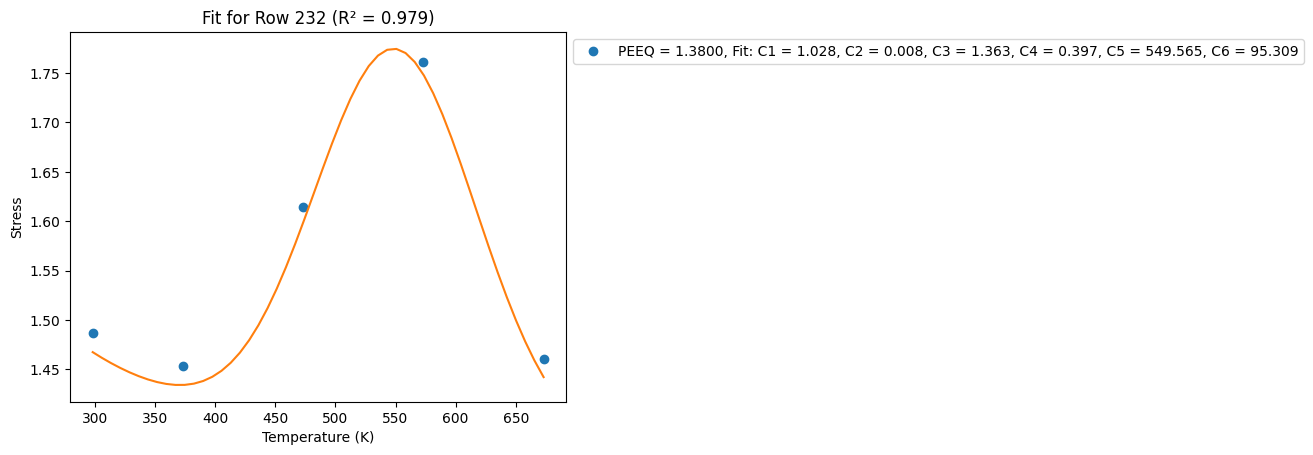

[1.48709124 1.45360114 1.61537283 1.76267976 1.46180327]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


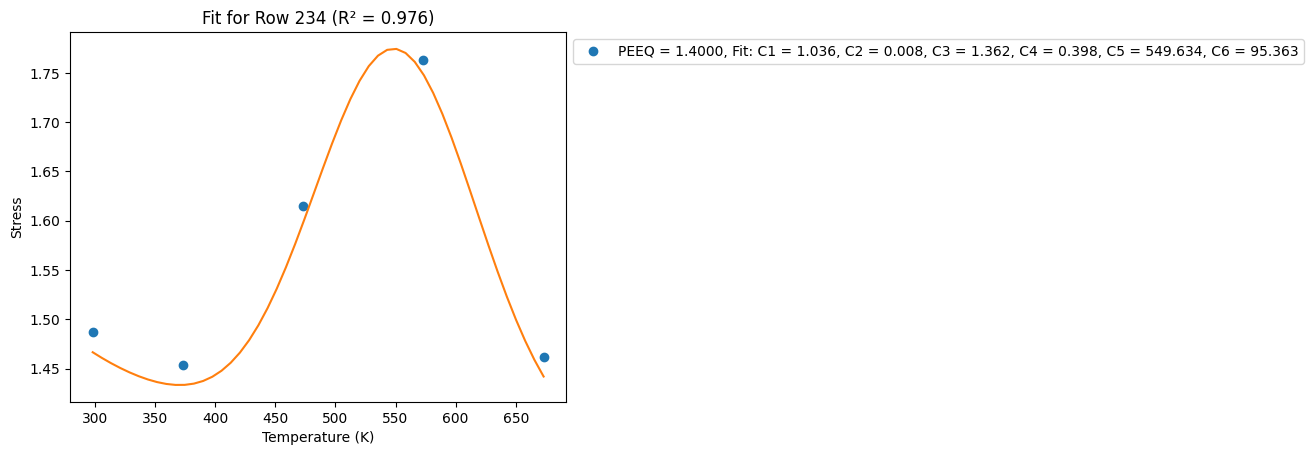

[1.48751934 1.4540566  1.61626988 1.76426287 1.46291011]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


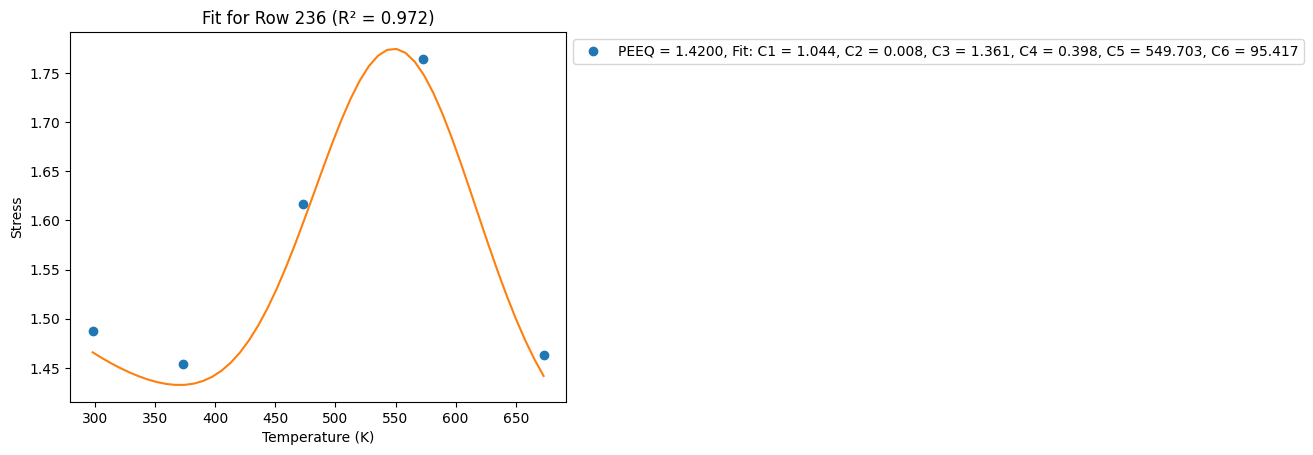

[1.4879402  1.45450453 1.61715286 1.76582334 1.46400135]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


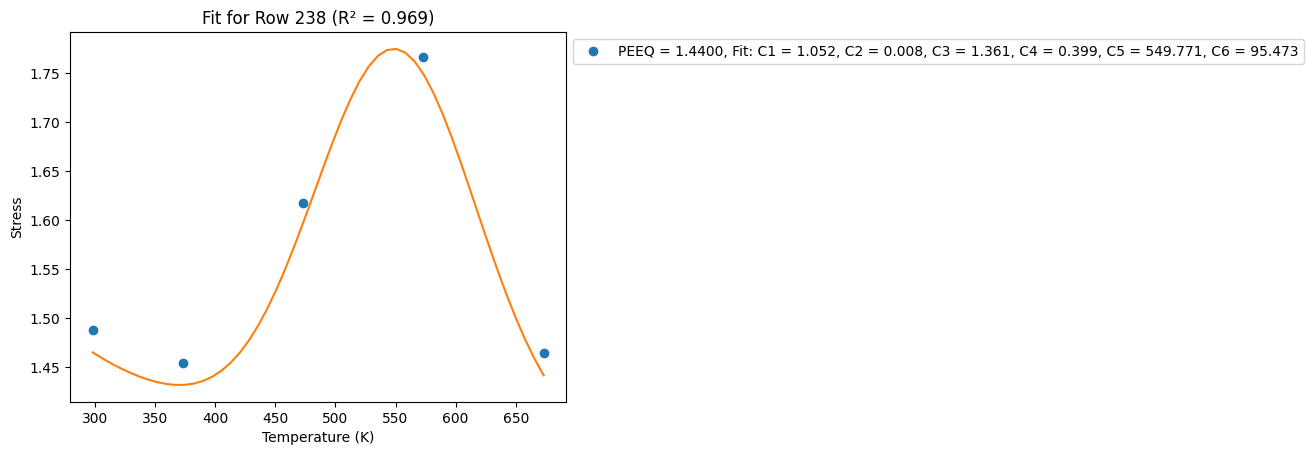

[1.48835404 1.45494518 1.61802218 1.7673618  1.46507744]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


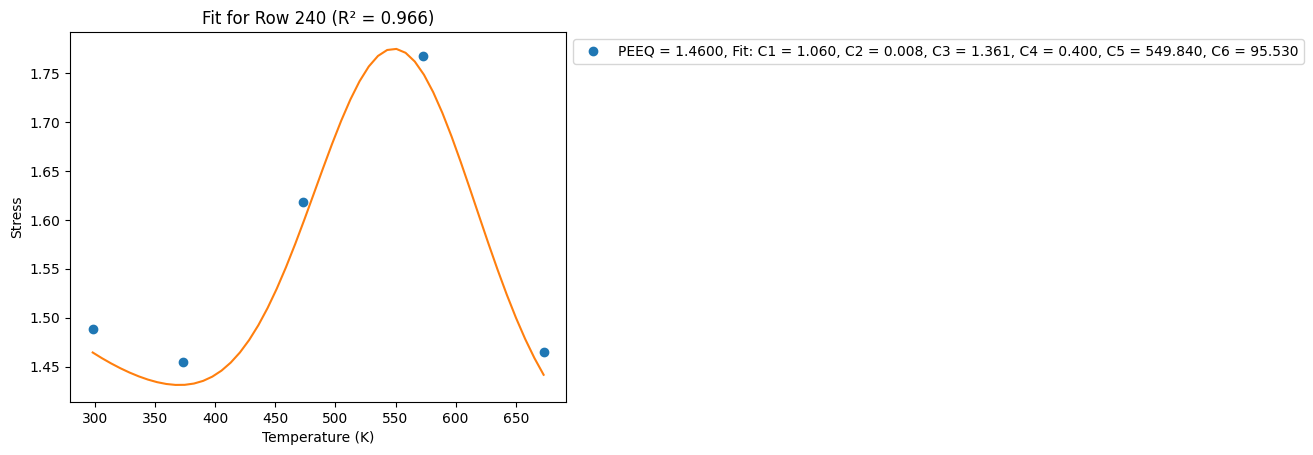

[1.48876108 1.45537876 1.61887824 1.76887886 1.4661388 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


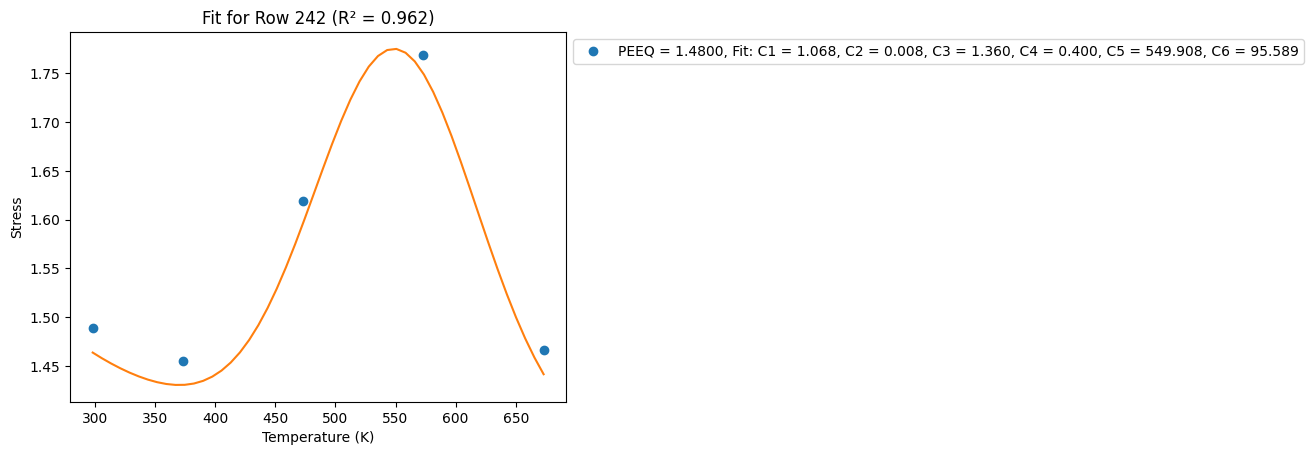

[1.48916151 1.45580547 1.6197214  1.7703751  1.46718581]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


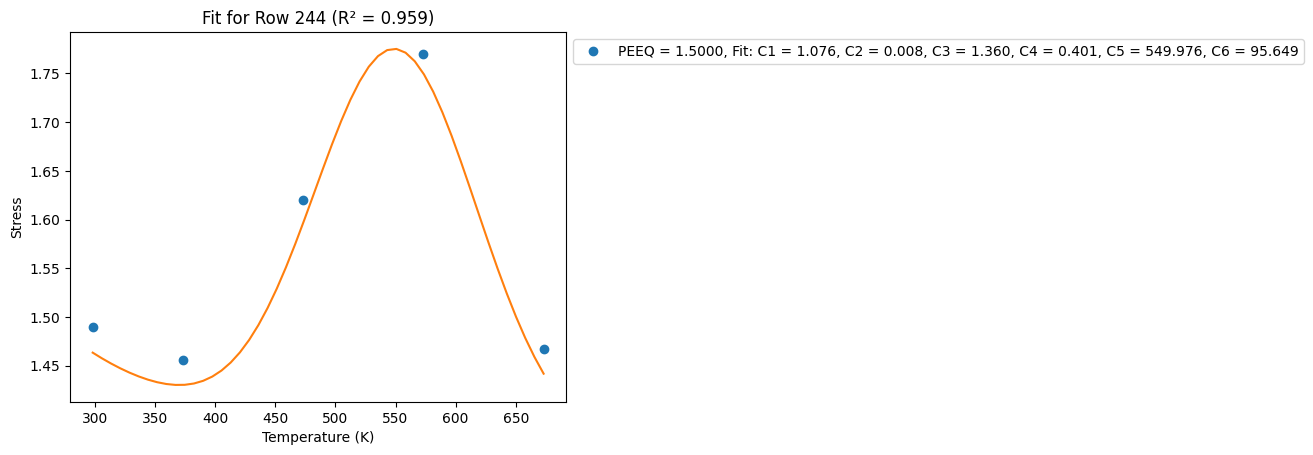

[1.48955553 1.45622552 1.62055205 1.77185108 1.46821886]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


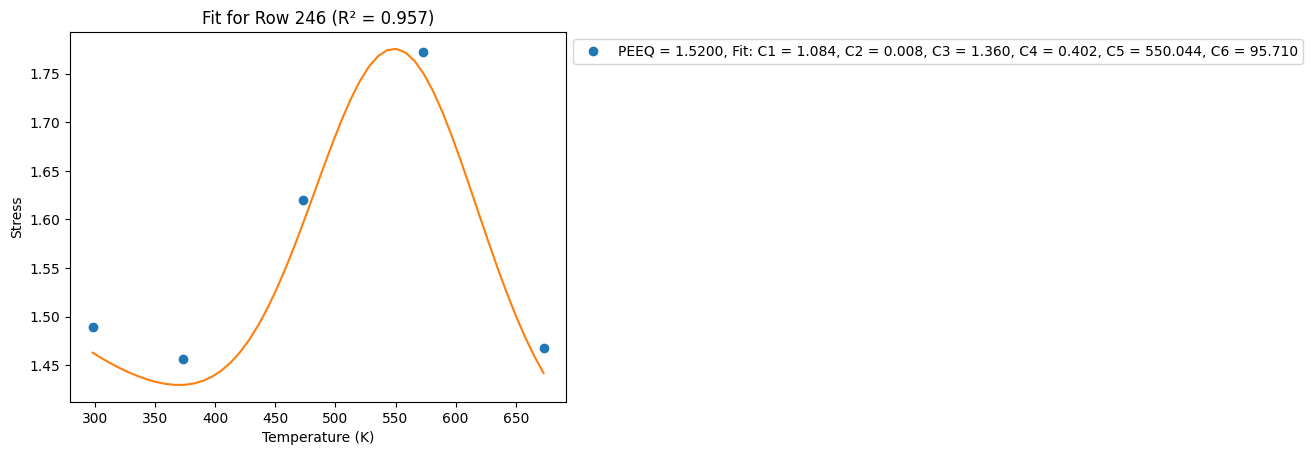

[1.48994333 1.45663909 1.62137051 1.77330734 1.46923832]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


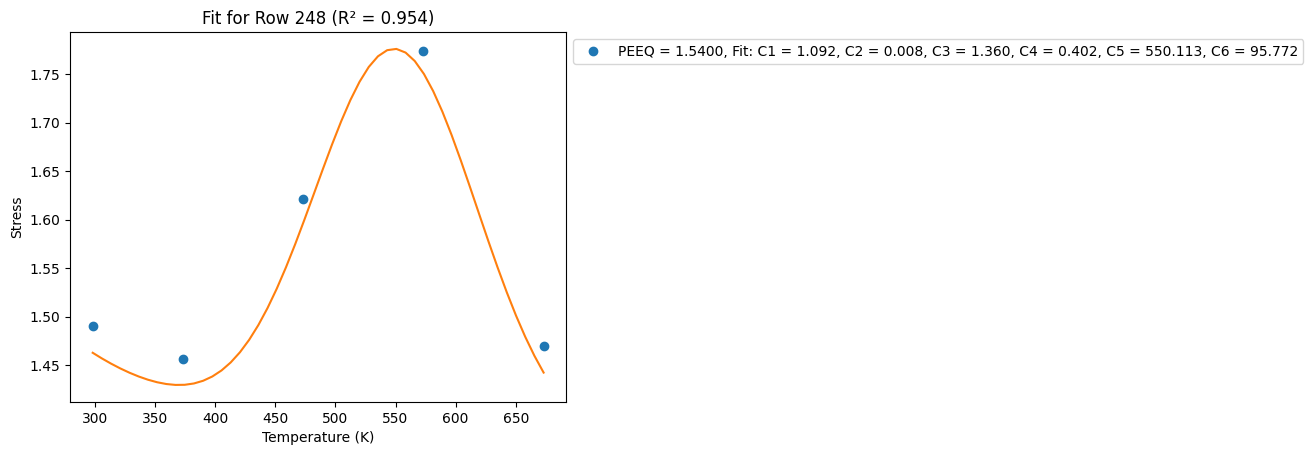

[1.49032508 1.45704636 1.62217713 1.77474439 1.47024454]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


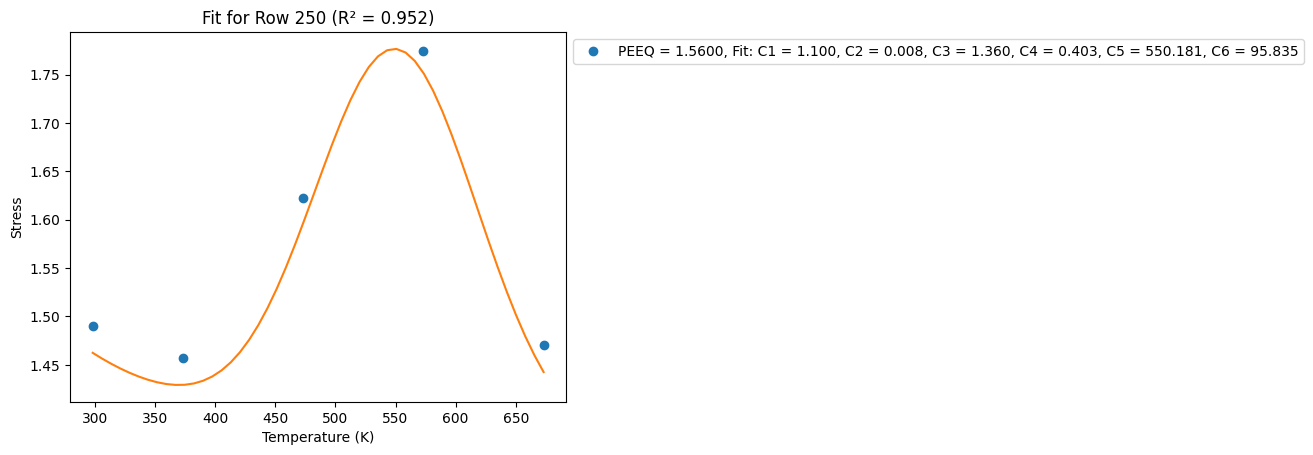

[1.49070096 1.45744752 1.62297224 1.77616274 1.47123787]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


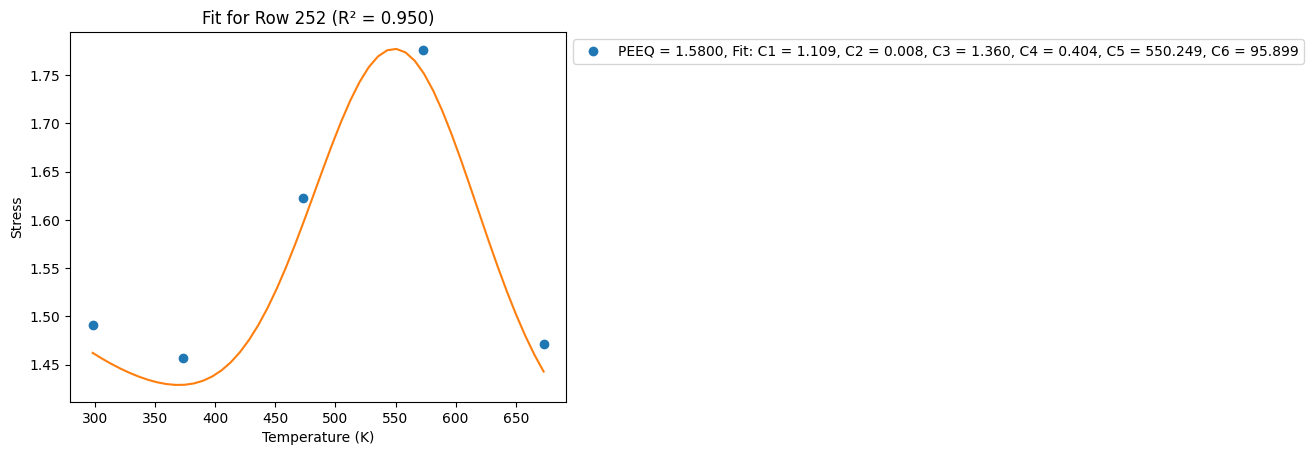

[1.49107112 1.45784273 1.62375612 1.77756285 1.47221862]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


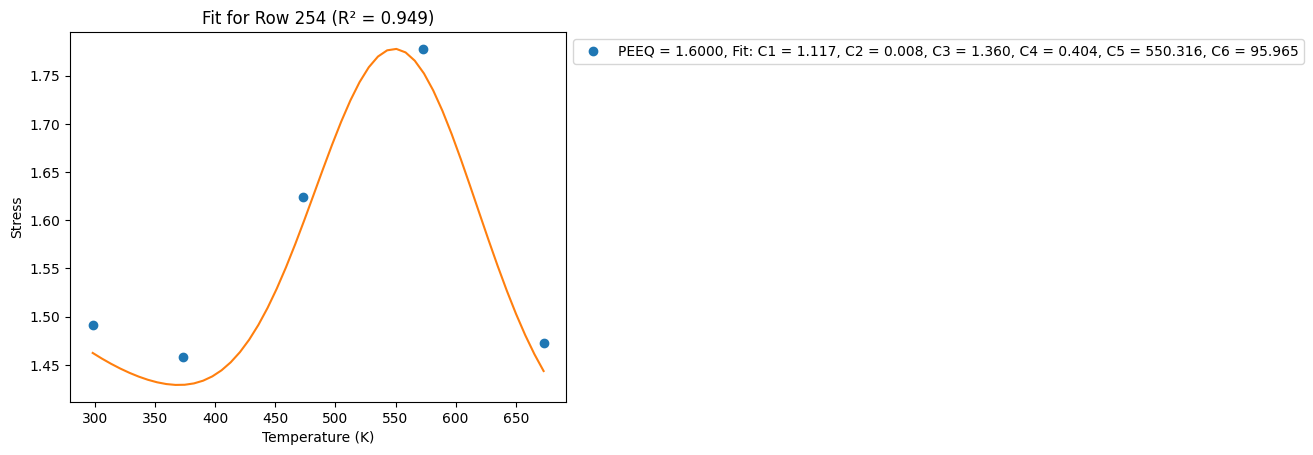

[1.49143573 1.45823215 1.6245291  1.77894519 1.47318712]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


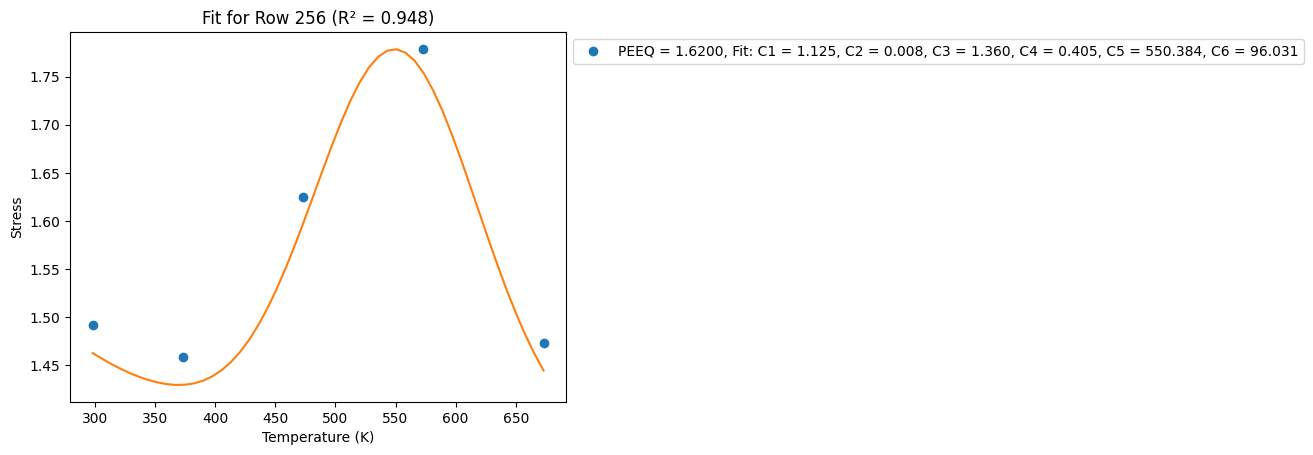

[1.49179493 1.45861594 1.62529143 1.78031019 1.47414366]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


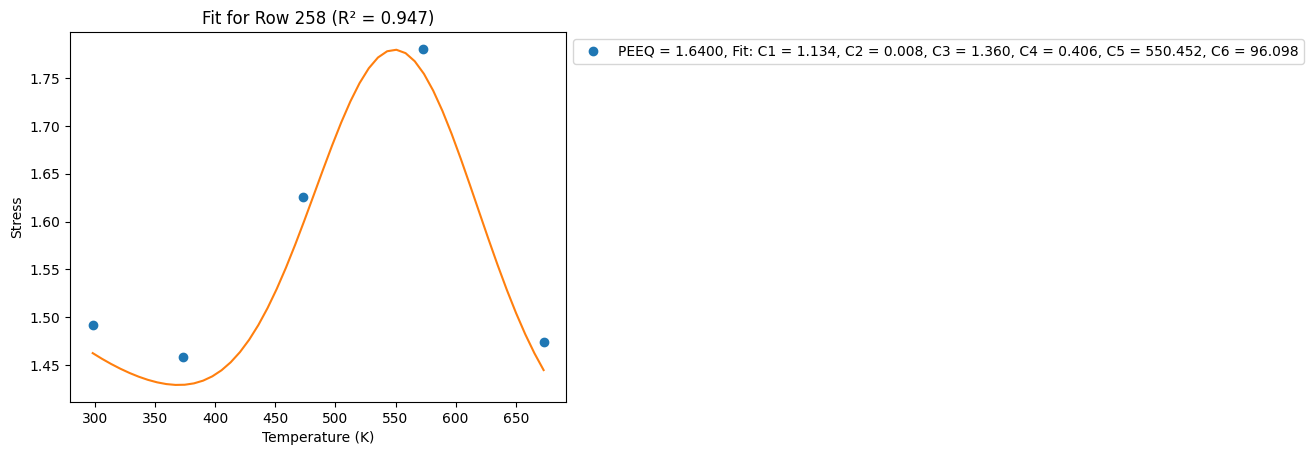

[1.49214888 1.45899424 1.62604342 1.7816583  1.47508853]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


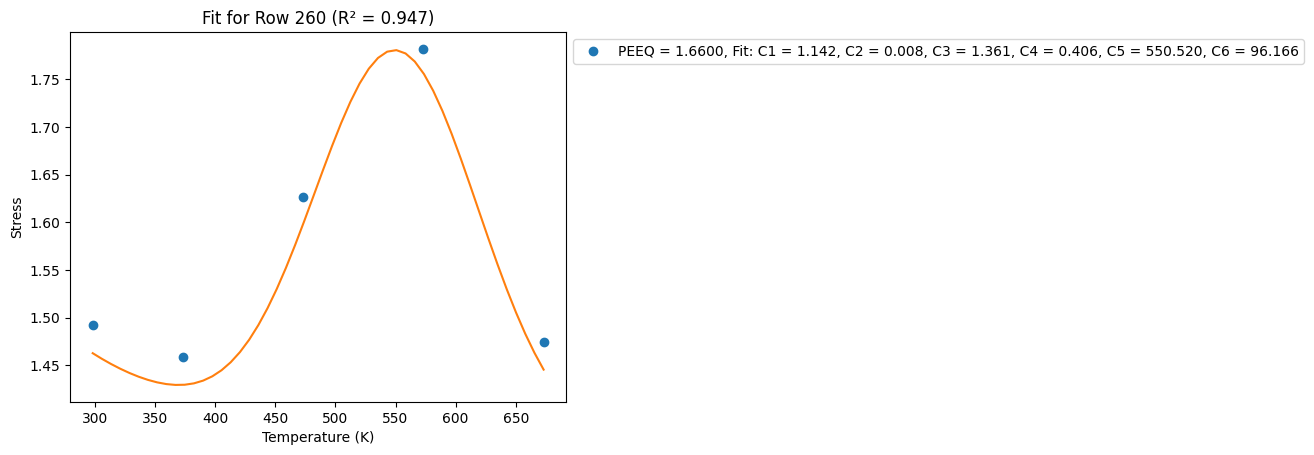

[1.4924977  1.45936721 1.6267853  1.7829899  1.47602202]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


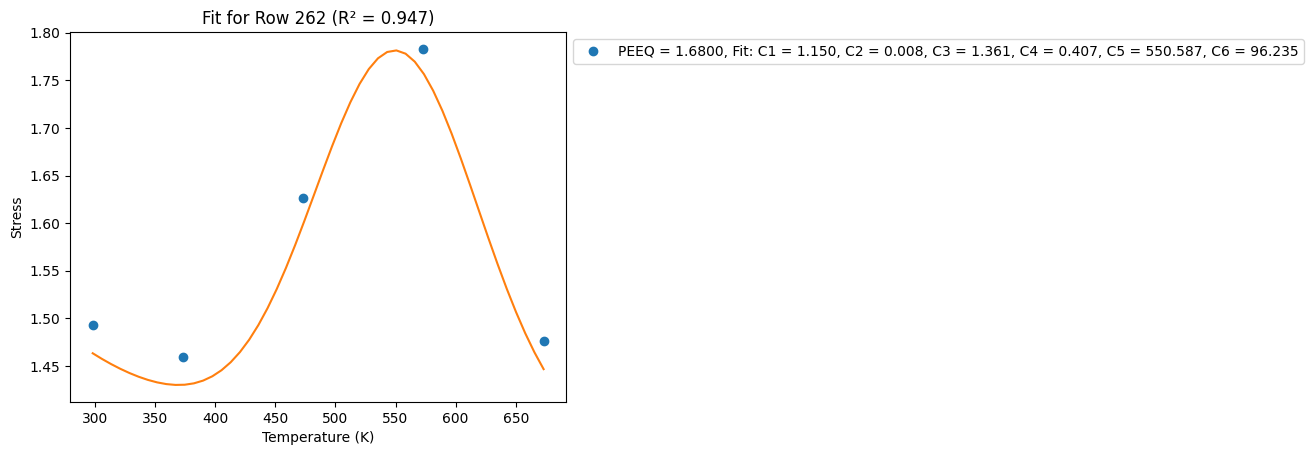

[1.49284154 1.45973497 1.62751735 1.78430541 1.47694441]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


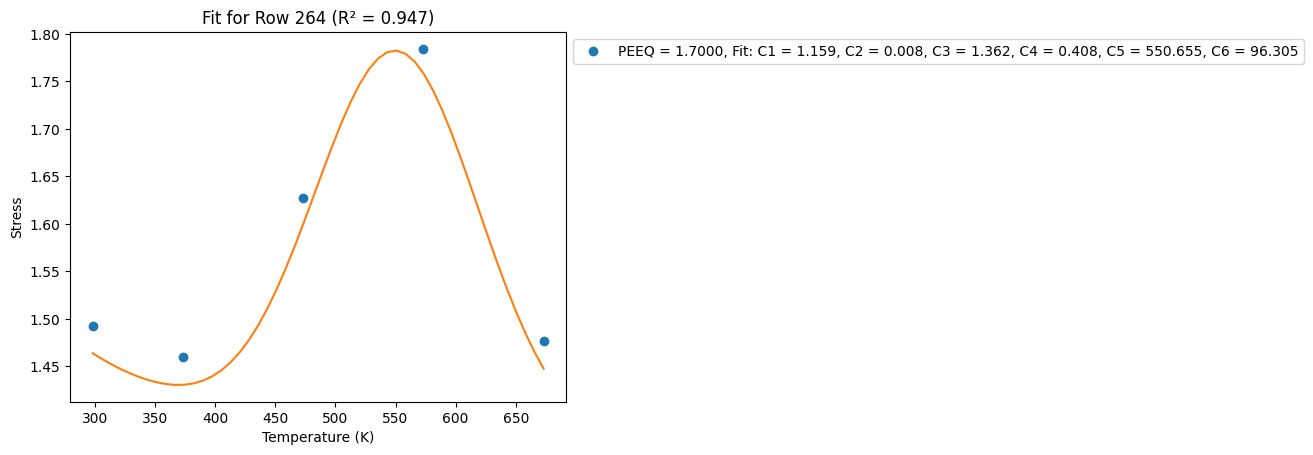

[1.49318052 1.46009766 1.6282398  1.7856052  1.47785594]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


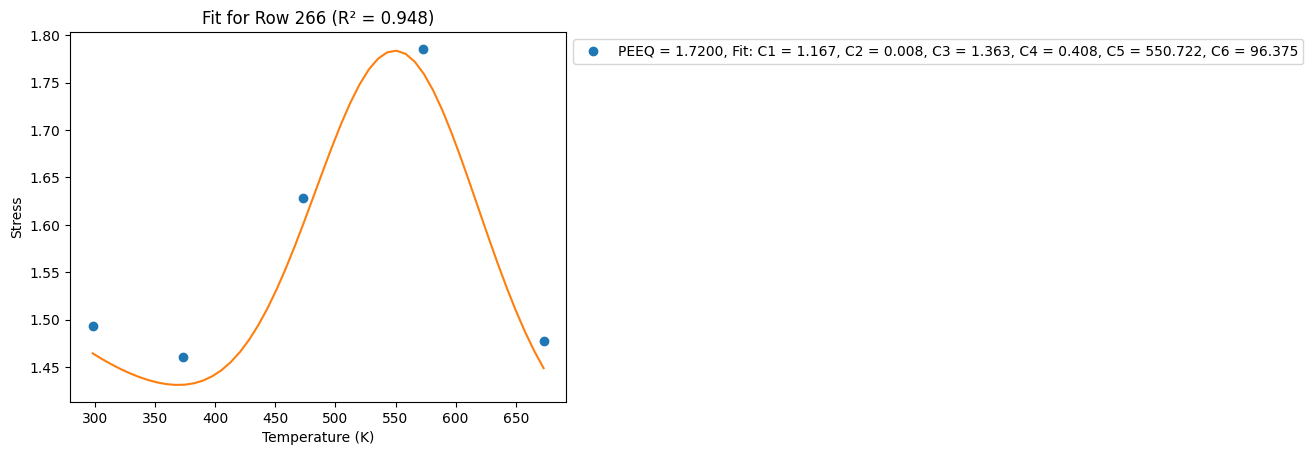

[1.49351477 1.4604554  1.62895289 1.78688965 1.47875687]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


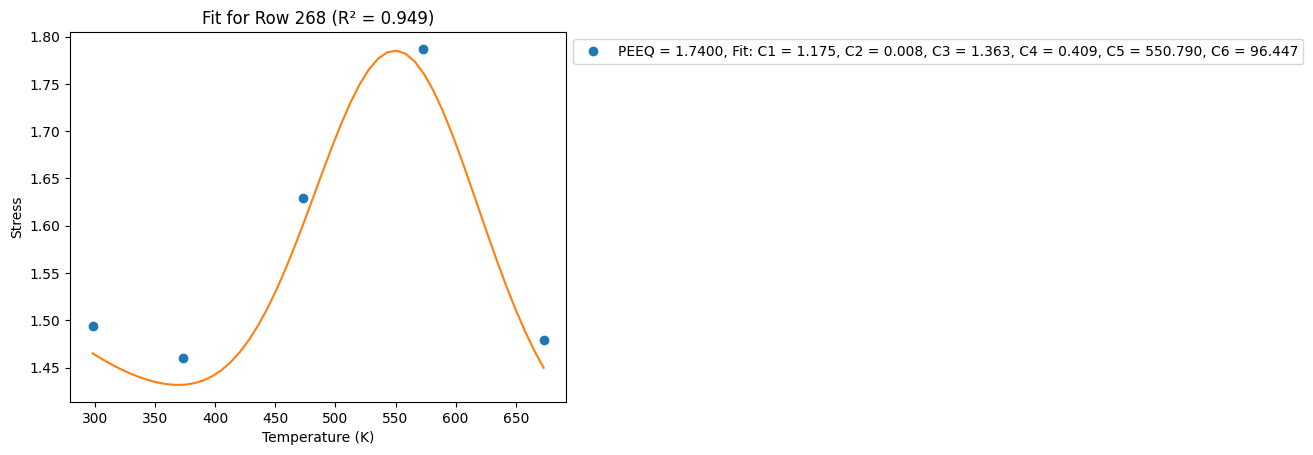

[1.4938444  1.46080833 1.62965684 1.7881591  1.47964745]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


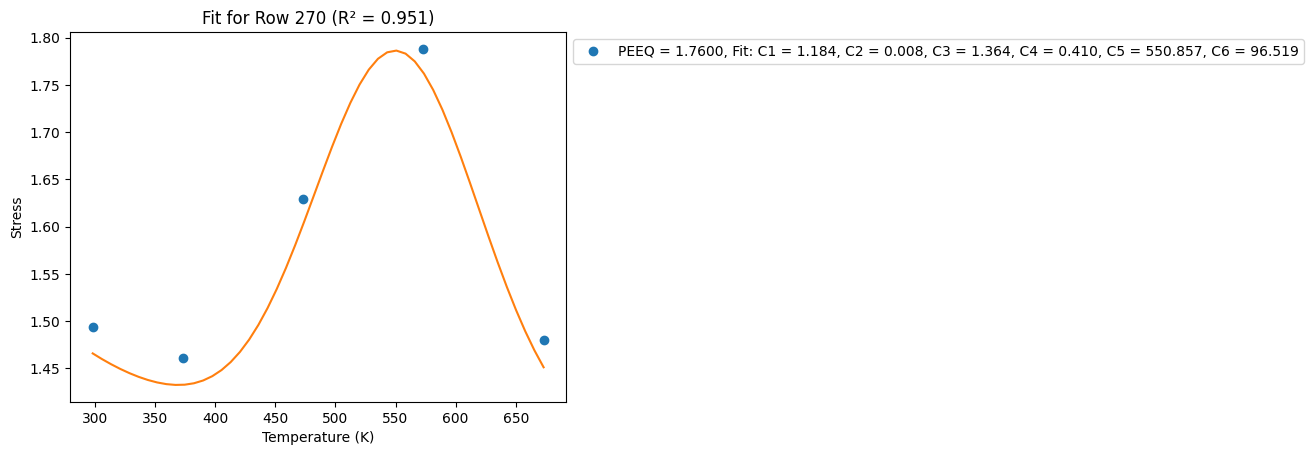

[1.49416954 1.46115656 1.63035189 1.7894139  1.48052791]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


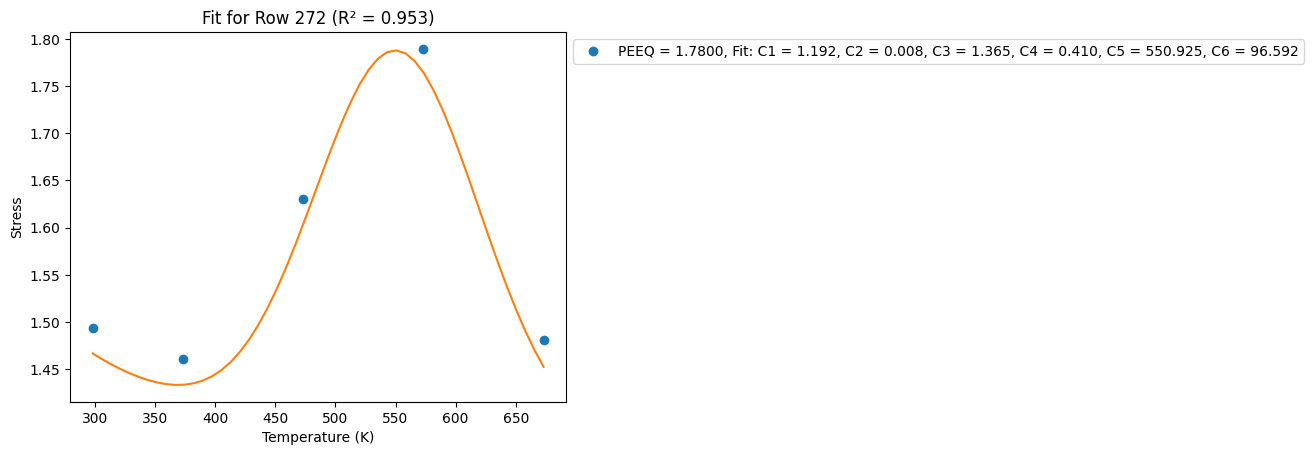

[1.49449029 1.46150021 1.63103823 1.79065438 1.48139848]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


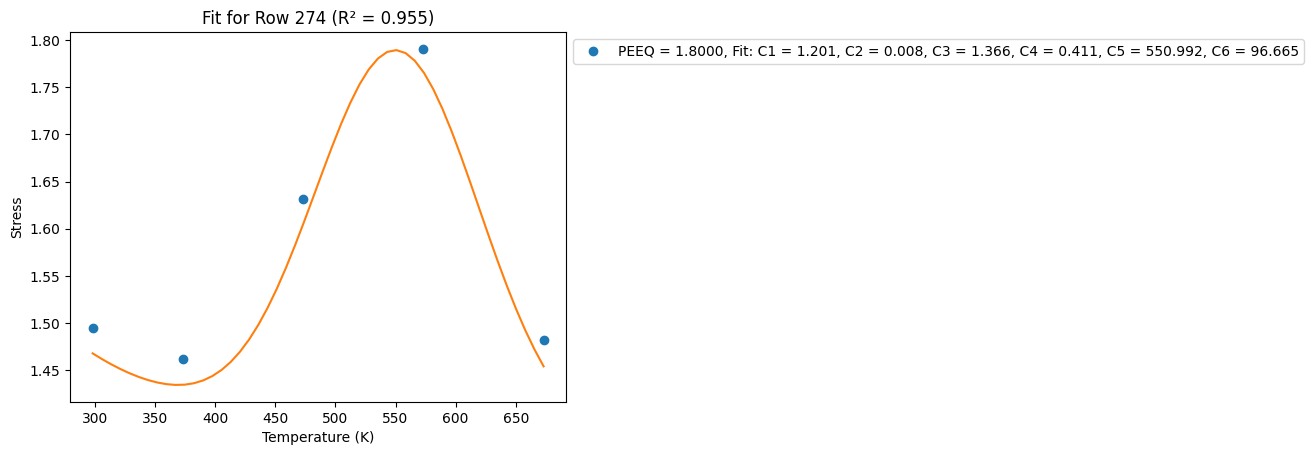

[1.49480676 1.46183938 1.63171607 1.79188086 1.48225938]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


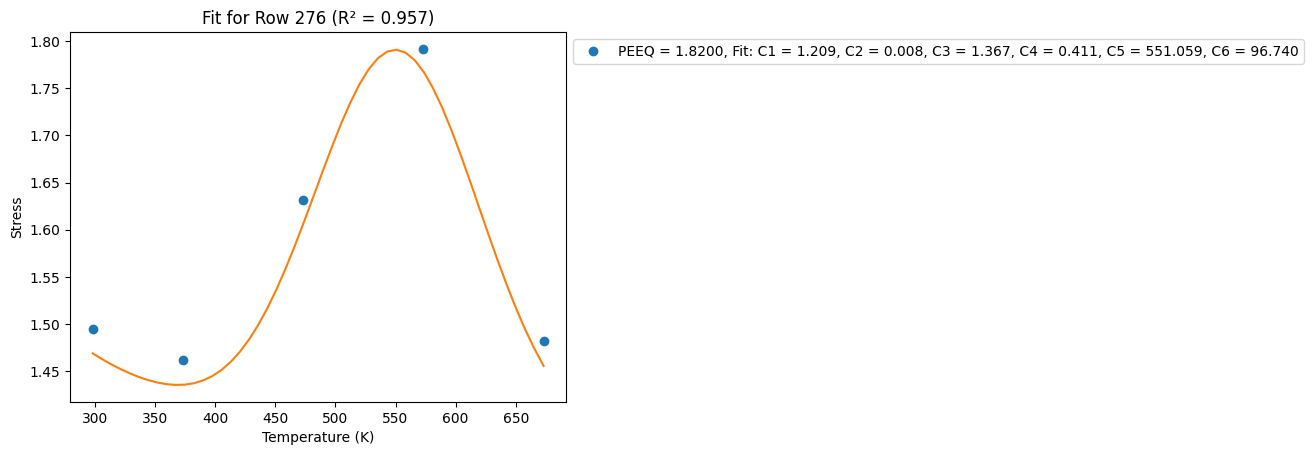

[1.49511905 1.46217418 1.63238562 1.79309366 1.48311082]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


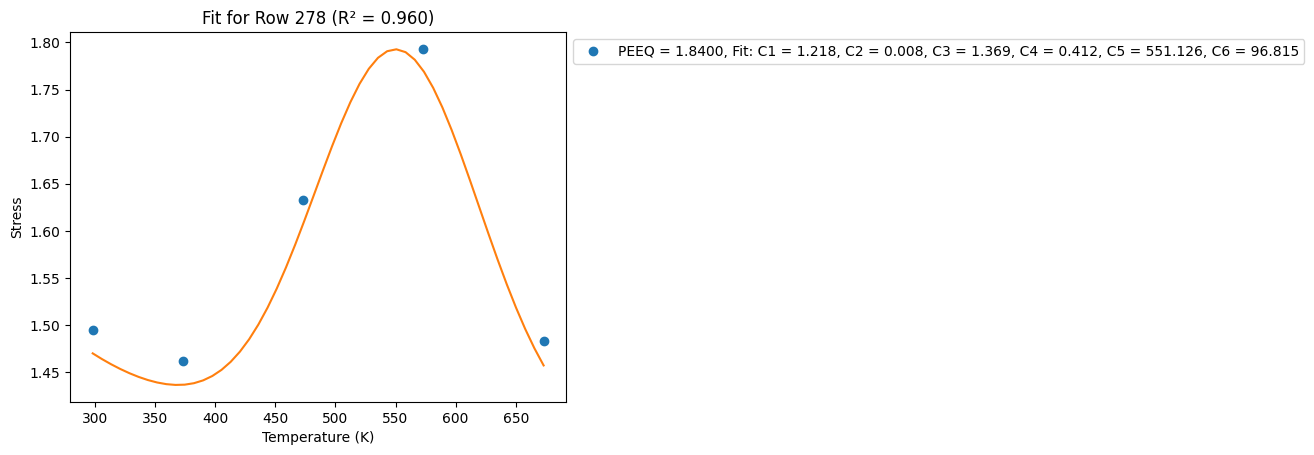

[1.49542727 1.46250472 1.63304705 1.79429307 1.483953  ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


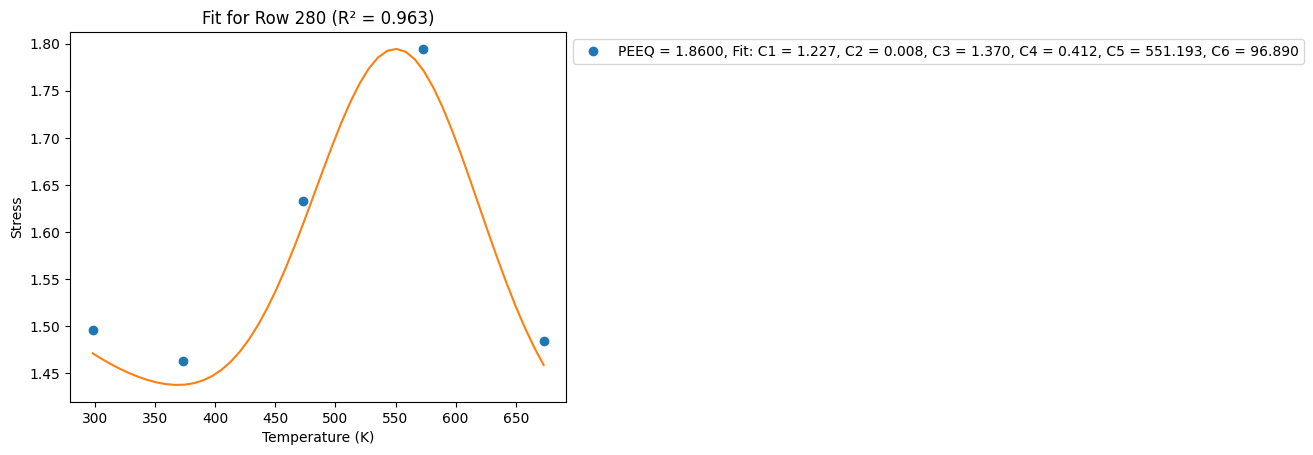

[1.49573151 1.4628311  1.63370056 1.79547938 1.48478613]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


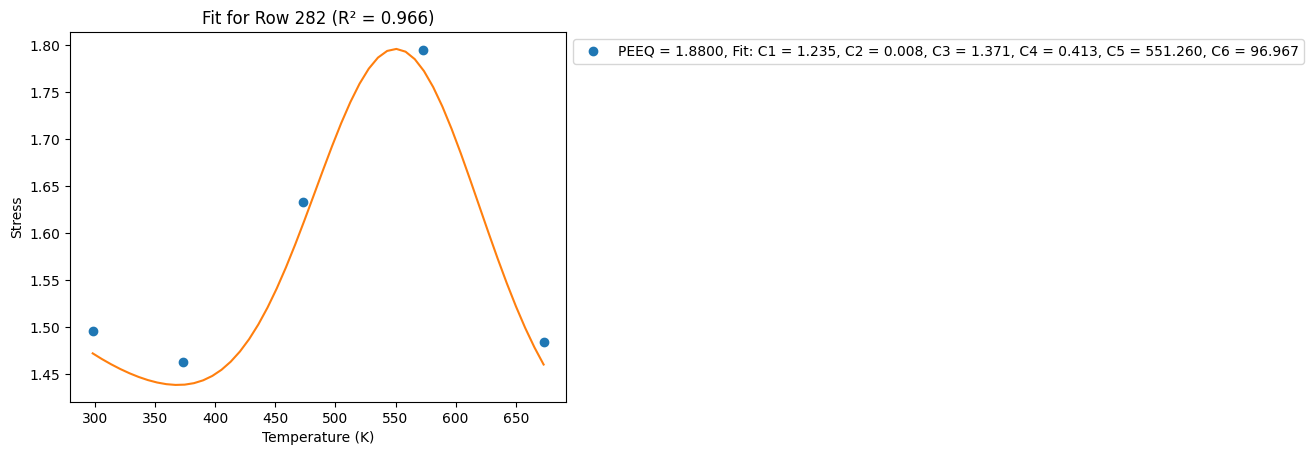

[1.49603186 1.4631534  1.63434632 1.79665287 1.4856104 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


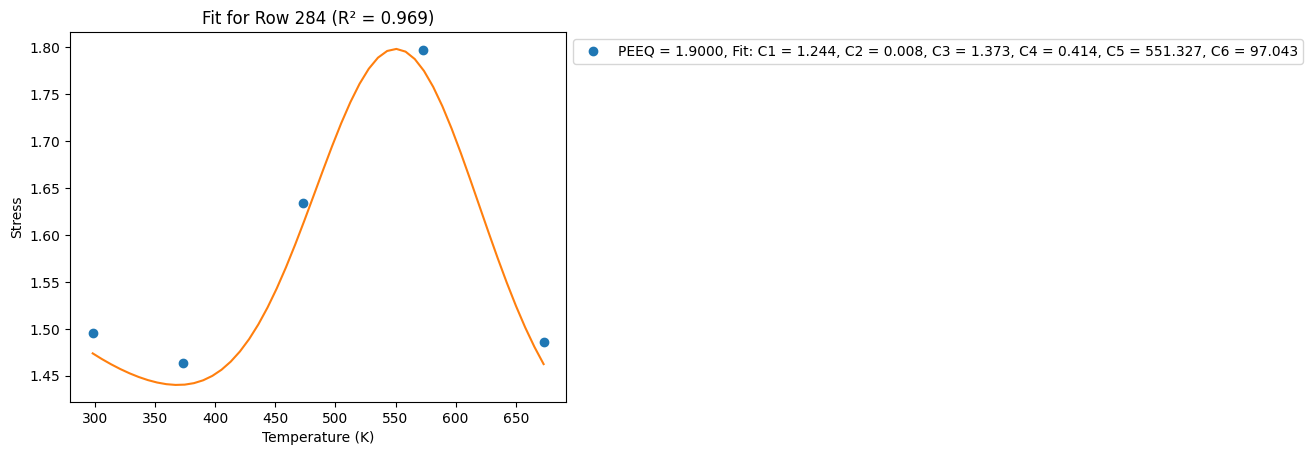

[1.49632841 1.46347173 1.63498451 1.79781382 1.48642599]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


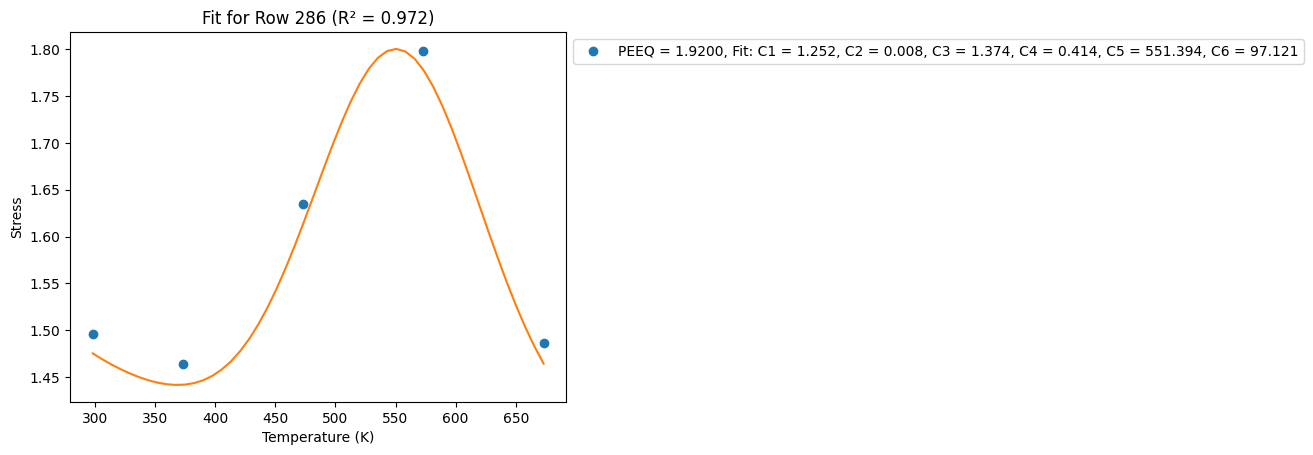

[1.49662125 1.46378617 1.63561529 1.79896249 1.48723309]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


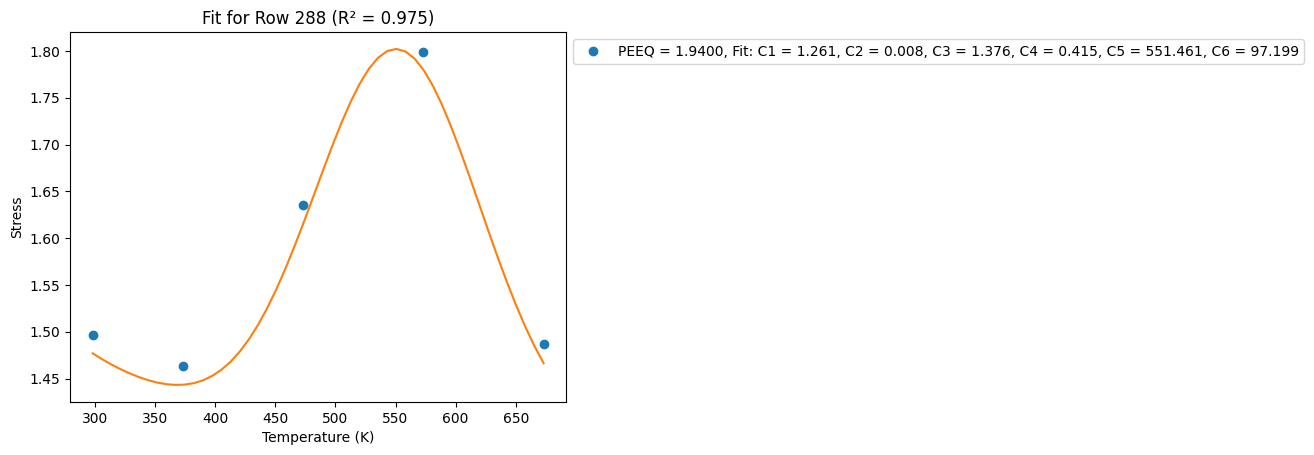

[1.49691047 1.46409681 1.63623882 1.80009913 1.48803187]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


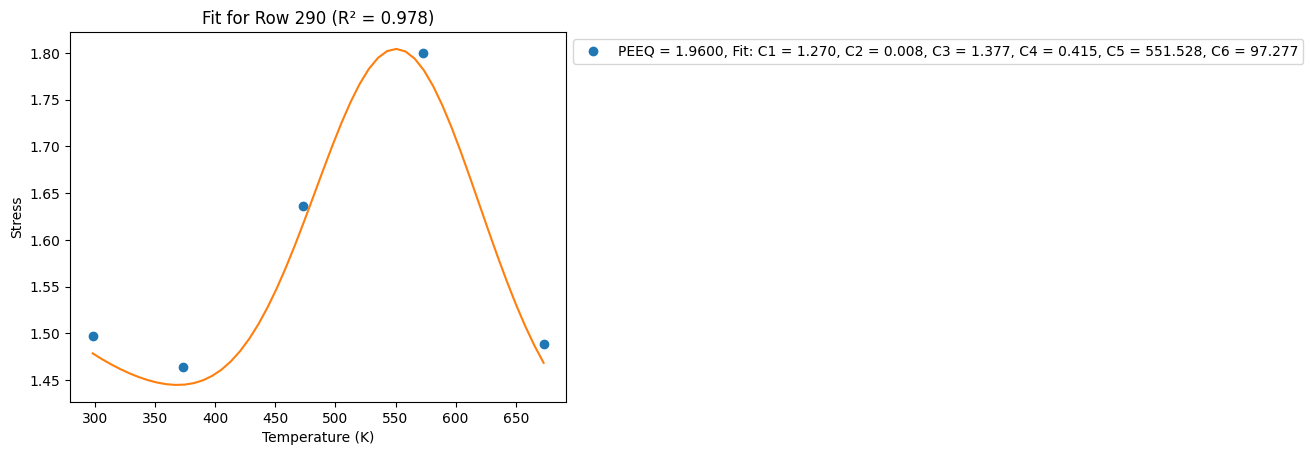

[1.49719615 1.46440374 1.63685526 1.801224   1.4888225 ]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


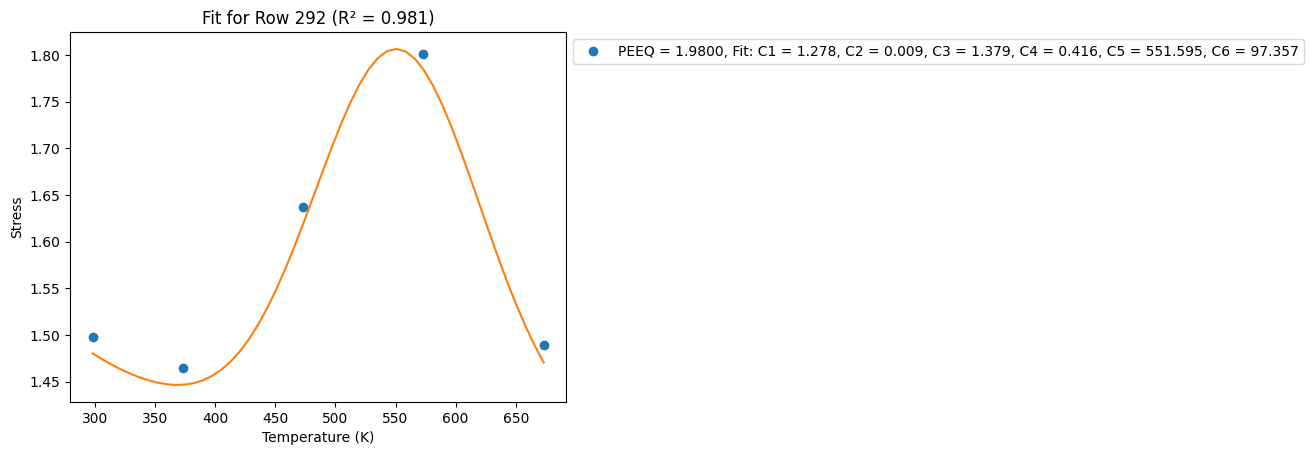

[1.49747836 1.46470704 1.63746476 1.80233732 1.48960514]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


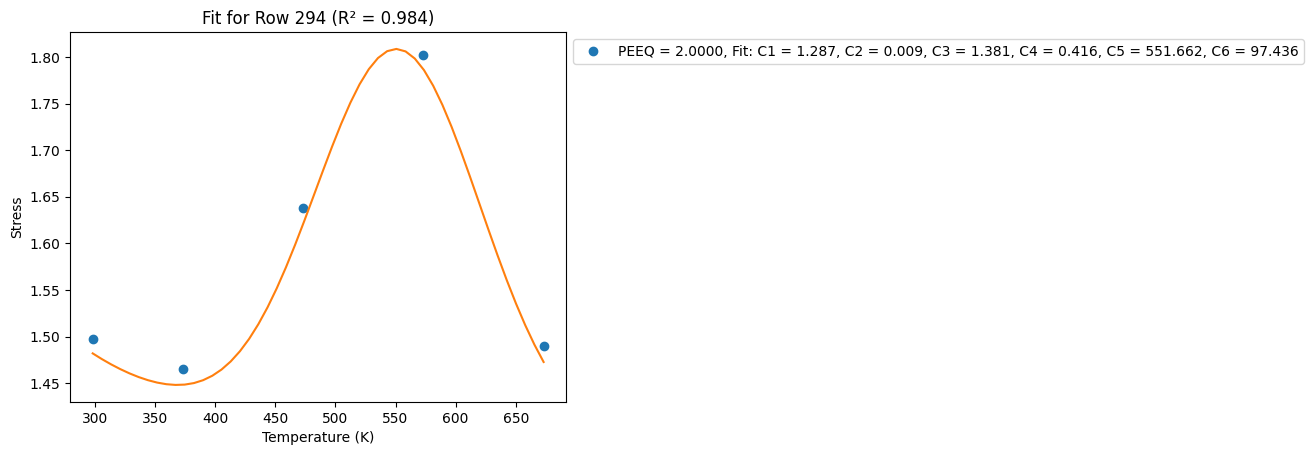

[1.49775718 1.46500678 1.63806748 1.80343934 1.49037996]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


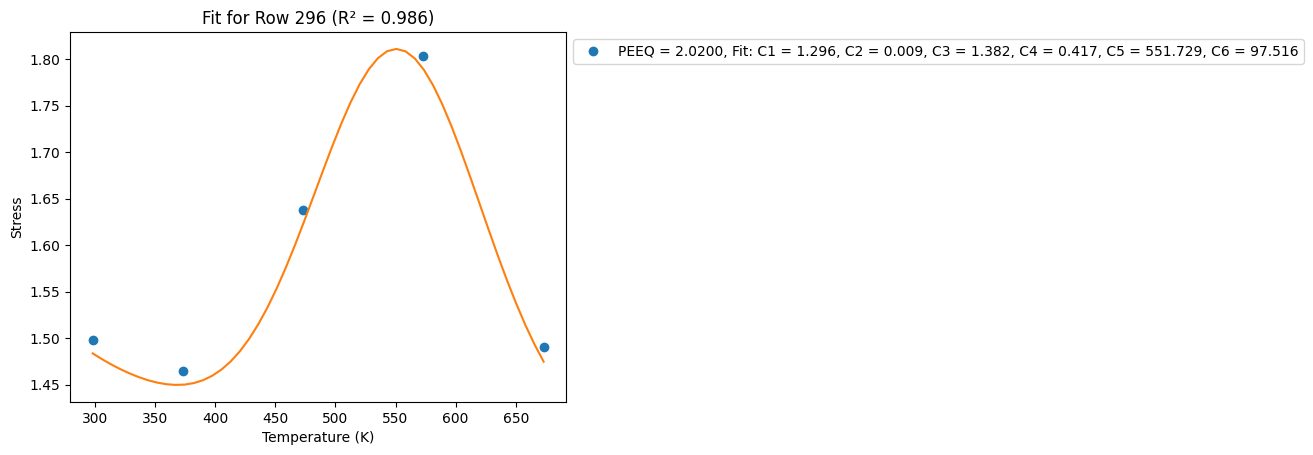

[1.49803268 1.46530304 1.63866354 1.80453027 1.49114711]


/tmp/ipykernel_2799/2417535246.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


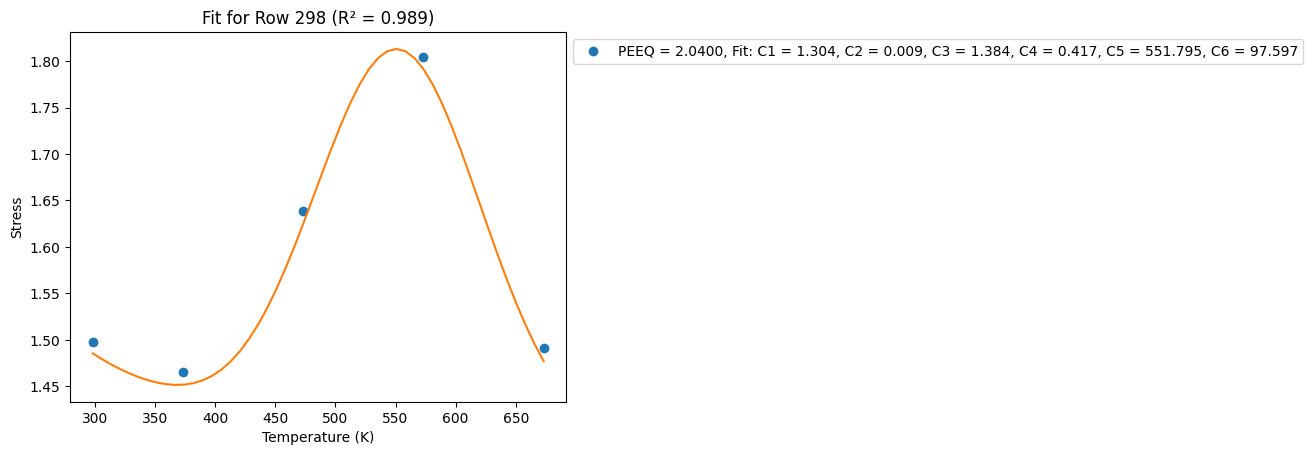

In [32]:
# Temperarute data points
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15])

# Temperature function
def f_func(T, cT1, cT2, cT3, cT4, cT5, cT6):
    return cT1*(np.exp(-cT2*T))+cT3+cT4*(np.exp(-((T-cT5)/cT6)**2))

for j, i in enumerate(np.arange(0,300,2)):
    T_fit = np.linspace(np.min(T), np.max(T), 50)
    [C1, C2, C3, C4, C5, C6] = fitted_para.iloc[i, 1:]
    y = stress_data.iloc[i, 6:].values
    print(y)
    gaussian_fit = f_func(T_fit, C1, C2, C3, C4, C5, C6)

    # Calculate residuals for error estimation
    y_pred = f_func(T, C1, C2, C3, C4, C5, C6)
    r_squared = r2_score(y, y_pred)

    plt.plot(T, y, 'o', T_fit, gaussian_fit)
    plt.xlabel("Temperature (K)")
    plt.ylabel("Stress")
    plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
    plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
else:
    str(0)